In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr, ttest_rel
#from adjustText import adjust_text
import seaborn as sns
import sys
import os

sys.path.append('../../../Code/')
from utils import read_dataset_log, starcat


In [2]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

## Prepare query

In [3]:
outdir = '../../../Data/PerDataset/Stimseq/'
figdir = '../../../Figures/Components/'

In [4]:
dataset_info = read_dataset_log(tabname='Dataset Paths')
dataset_info.index = dataset_info['dataset']
counts_fn = dataset_info.loc['Stimseq', 'raw_counts_filt_fn']

In [6]:
counts_fn

'/data/srlab1/TCAT/Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.h5ad'

In [6]:
query_adata = sc.read(counts_fn)
#query_adata = sc.AnnData(X=query_adata.raw.X, var=query_adata.raw.var, obs=query_adata.obs, obsm=query_adata.obsm)
#query_adata.var.index = query_adata.var['gene_name']
query_adata

Only considering the two last: ['.doubletfilt', '.h5ad'].
Only considering the two last: ['.doubletfilt', '.h5ad'].


AnnData object with n_obs × n_vars = 43222 × 36738
    obs: 'barcode', 'BRI', 'Run', 'Well', 'Batch', 'Biobank_ID', 'Sort_Status', 'HTO_Status', 'Demuxlet_Assignment', 'Total_RNA_Count', 'Total_ADT_Count', 'Total_HTO_Count', 'frac_ADT', 'A_cdr3', 'B_cdr3', 'DEMUX_RD.UNIQ', 'DEMUX_N.SNP', 'DEMUX_BEST', 'DEMUX_SNG.1ST', 'DEMUX_SNG.LLK1', 'DEMUX_DBL.1ST', 'DEMUX_DBL.2ND', 'DEMUX_LLK12', 'DEMUX_PRB.DBL', 'DEMUX_PRB.SNG1', 'batch_name', 'B_is_cell', 'B_high_confidence', 'B_full_length', 'B_productive', 'B_length', 'B_v_gene', 'B_d_gene', 'B_j_gene', 'B_c_gene', 'B_cdr1', 'B_cdr2', 'B_cdr3_nt', 'B_reads', 'B_umis', 'B_raw_clonotype_id', 'B_raw_consensus_id', 'B_Num_Hits_In_Barcode', 'B_Next_Highest_ReadCount', 'B_Num_Productive_In_Barcode', 'B_Has_Unproductive', 'A_is_cell', 'A_high_confidence', 'A_full_length', 'A_productive', 'A_length', 'A_v_gene', 'A_d_gene', 'A_j_gene', 'A_c_gene', 'A_cdr1', 'A_cdr2', 'A_cdr3_nt', 'A_reads', 'A_umis', 'A_raw_clonotype_id', 'A_raw_consensus_id', 'A_Num_H

In [8]:
vc = query_adata.var['gene_name'].value_counts()
tofilt = list(vc.index[vc>1])
tofilt

['TMSB15B',
 'GOLGA8M',
 'LINC01505',
 'ARMCX5-GPRASP2',
 'CYB561D2',
 'TBCE',
 'MATR3',
 'LINC01238',
 'GGT1',
 'HSPA14']

In [9]:
query_adata = query_adata[:,~query_adata.var['gene_name'].isin(tofilt)]
query_adata.var.index = query_adata.var['gene_name']

In [10]:
sc.pp.filter_genes(query_adata, min_cells=10)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
query_adata = query_adata[:,query_adata.var['feature_type']!='Antibody Capture']

In [12]:
metagepinfo = read_dataset_log('cGEP Paths').loc[0,:]
metagepinfo

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
correlation_matrix_tpm_renorm_varnorm        /data/srlab1/TCAT/Data/TCAT/R.TPMrenorm.VarNor...
correlation_matrix_spectra                   /data

In [13]:
tcat_dir = '/data/srlab1/TCAT/Data/TCAT'
ref_fn = metagepinfo['tpm_renorm_varnorm_spectra']
hvg_fn = metagepinfo['merged_hvgs']

ref = pd.read_csv(ref_fn, sep='\t', index_col=0)
hvgs = pd.read_csv(hvg_fn, sep='\t', header=None)[0]
ref = ref[hvgs]

In [14]:
tmod = starcat(tpm_norm=False, copy=True, var_norm=True)
rf_usage = tmod.fit_transform(query_adata, ref_spectra=ref)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

3254 out of 3412 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
tcatfn = os.path.join(outdir, 'TCAT.20231201.tsv')
tcatfn

'../../../Data/PerDataset/Stimseq/TCAT.20231201.tsv'

In [16]:
rf_usage.to_csv(tcatfn, sep='\t')

In [9]:
dataset_info.loc['Stimseq', 'tcat_fn']

'/data/srlab1/TCAT/Data/PerDataset/Stimseq/TCAT.20231201.tsv'

In [10]:
rf_usage = pd.read_csv(dataset_info.loc['Stimseq', 'tcat_fn'], index_col = 0, sep = '\t')

In [12]:
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

In [13]:
rf_usage_norm_annot = pd.merge(left=rf_usage_norm, right=query_adata.obs[['Biobank_ID', 'Sort_Status']],
         left_index=True, right_index=True, how='left')

In [8]:
labelfn = dataset_info.loc['Stimseq', 'manual_gating_fn'] #'../../../Data/PerDataset/Stimseq/ManualGating.Magic.FinalLabel.20230831.tsv'
print(labelfn)
gating_label = pd.read_csv(labelfn, sep='\t', index_col=0)['0']
gating_label.head()

/data/srlab1/TCAT/Data/PerDataset/Stimseq/ManualGating.Magic.FinalLabel.20240424.tsv


3_AAACCTGAGACCGGAT       CD4_CM
3_AAACCTGAGAGGGCTT    CD4_Naive
3_AAACCTGAGAGTCTGG       CD4_EM
3_AAACCTGAGCTAGCCC       CD4_CM
3_AAACCTGAGCTGCCCA       CD4_CM
Name: 0, dtype: object

In [14]:
rf_usage_norm_annot['lineage'] = gating_label.loc[rf_usage_norm_annot.index]

In [20]:
from scipy.stats import ttest_rel

def ttest_paired_allcols(X, Y):
    '''
    Takes 2 pandas.DataFrames X and Y with the same number of rows and columns.
    Performs a paired t-test for each column of X and Y. 
    
    Returns
    ---------------------------------
    Ts - pandas.Series of T statistics
    Ps - pandas.Series of P-values
    '''
    
    Ts = []
    Ps = []
    for g in X.columns:
        T, P = ttest_rel(X[g], Y[g])
        Ts.append(T)
        Ps.append(P)

    Ts = pd.Series(Ts, index=X.columns)
    Ps = pd.Series(Ps, index=X.columns)
    return(Ts, Ps)


def permute_within_group(df, group_col, vartopermute):
    permuted = df.groupby(group_col, group_keys=True).apply(lambda x: x.assign(permuted=np.random.permutation(x[vartopermute]))).reset_index(drop=True)
    return(permuted)

In [21]:
average_usage = rf_usage_norm_annot.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
average_usage_un = average_usage.xs('U', axis=0, level=1)

In [22]:
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)

In [23]:
Ts.sort_values(ascending=False)

ICOS/ACTG1                  18.580341
Th17                        17.880627
Metallothionein             16.888641
CellCycle-G2M               12.599586
Pan-Cancer:Tph_Single       11.840575
CTLA4+CD38+_IL26/CTSH       11.410887
COMBAT_Cytoskeleton         10.398685
HeatShock1                  10.182336
CellCycle-S                  9.696910
HeatShock2                   7.987586
EBI3-Activation              6.024799
High-Cytokine                5.482126
RGCC/MYADM_S100A10/LMNA      5.392560
ISG                          4.918717
CellCycle-Histone            4.753072
AMP-RA:Tph_Single            4.687145
S100A10/LMNA                 4.573267
BCL2/CDK6                    4.438357
Treg                         4.234083
TIMD4/CD38                   4.174681
CCR3+-Th2                    4.117633
AMP-RA_Tfh                   4.111449
IL26/CTSH                    4.095150
HLA                          2.727614
Doublet-Bcell                2.211312
Th2                          2.019730
IEG_IEG-Bloo

In [17]:
gepnameinfo = read_dataset_log('cGEP_Name')
name_dict = dict(zip(gepnameinfo['cGep_Name'], gepnameinfo['Short_Name']))
shorten_map = dict(zip(gepnameinfo['Short_Name'], gepnameinfo['Shortest_Name']))

In [62]:
16+5+25

46

In [61]:
for k,g in gepnameinfo.groupby('Class'):
    g = g.loc[~g['Short_Name'].isnull(), :]
    print(k, g.shape)
    display(g)
    print('\n\n')

Artifact (5, 10)


cGep_Name Old_Short_Name               Long_Name  \
13  IEG_IEG-Blood_IEG-Tissue            IEG    Immediate Early Gene   
14               MALAT1_TBRU         MALAT1            Poor Quality   
21               MALAT1_Mito           Mito     Mitochondrial Genes   
25          IEG_YPEL5/CREM_1           IEG2  Immediate Early Gene 2   
48          IEG_YPEL5/CREM_2     YPEL5/JUNB  Immediate Early Gene 3   

      Short_Name Shortest_Name     Class  Num_Datasets          Notes  \
13           IEG           IEG  Artifact           6.0            NaN   
14  Poor-Quality  Poor-Quality  Artifact           6.0            NaN   
21          Mito          Mito  Artifact           5.0            NaN   
25          IEG2          IEG2  Artifact           4.0            NaN   
48          IEG3          IEG3  Artifact           2.0  Seems sketchy   

   Reviewed Filter  
13        Y    NaN  
14        Y    NaN  
21        Y    NaN  
25        Y    NaN  
48        Y    NaN




Doublet Lineage (6, 10)


cGep_Name       Old_Short_Name            Long_Name  \
5             Doublet-RBC          Doublet-RBC          Doublet RBC   
18       Doublet-Platelet     Doublet-Platelet     Doublet Platelet   
22  AMP-RA_Doublet-Plasma  Doublet-Plasmablast  Doublet Plasmablast   
35          Doublet-Bcell        Doublet-Bcell        Doublet Bcell   
36        Doublet-Myeloid      Doublet-Myeloid      Doublet Myeloid   
45      AMP-RA_Pan-Cancer   Doublet-Fibroblast   Doublet Fibroblast   

             Short_Name    Shortest_Name            Class  Num_Datasets Notes  \
5           Doublet-RBC          Dbt-RBC  Doublet Lineage           7.0   NaN   
18     Doublet-Platelet     Dbt-Platelet  Doublet Lineage           5.0   NaN   
22  Doublet-Plasmablast  Dbt-Plasmablast  Doublet Lineage           4.0   NaN   
35        Doublet-Bcell        Dbt-Bcell  Doublet Lineage           3.0   NaN   
36      Doublet-Myeloid      Dbt-Myeloid  Doublet Lineage           3.0   NaN   
45   Doublet-Fibroblast   Dbt-Fibroblast  Doublet Lineage           2.0   NaN   

   Reviewed Filter  
5         Y    NaN  
18        Y    NaN  
22        Y    NaN  
35        Y    NaN  
36        Y    NaN  
45        Y    NaN




Functional (25, 10)


cGep_Name           Old_Short_Name  \
0       COMBAT_Cytoskeleton             Cytoskeleton   
2             CellCycle-G2M            CellCycle-G2M   
3               CellCycle-S              CellCycle-S   
4                 Cytotoxic                Cytotoxic   
6                       ISG                      ISG   
10        CellCycle-Histone         CellCycle-Late-S   
11                      HLA                      HLA   
12               HeatShock2         Early-Activation   
15    CD4-Naive_Translation              Translation   
19                IL10/CD38      IL10/IL19-Secretion   
20  RGCC/MYADM_S100A10/LMNA               RGCC/MYADM   
24          Metallothionein          Metallothionein   
26            High-Cytokine           Multi-Cytokine   
30                BCL2/CDK6            BCL2-Survival   
34    CTLA4+CD38+_IL26/CTSH  CTLA4+/CD38+-Activation   
37               HeatShock1                HeatShock   
39                CCR3+-Th2                    Th2-2   
40          EBI3-Activation     OX40/EBI3-Activation   
41               ICOS/ACTG1     ICOS/CD38-Activation   
42                IL26/CTSH                   Th17-2   
43                 SOX4/MME                SOX4/TOX2   
44               TIMD4/CD38    TIMD4/TIM3-Activation   
46   CH25H/DDIT4_Pan-Cancer             CD40LG/TXNIP   
47              HIV-Vaccine               TXNIP/H1FX   
51    Pan-Cancer:Tph_Single               Exhaustion   

                      Long_Name        Short_Name    Shortest_Name  \
0            Actin Cytoskeleton      Cytoskeleton          Cytosk.   
2          Cell Cycle G2M Phase     CellCycle-G2M        G2M-phase   
3            Cell Cycle S Phase       CellCycle-S          S-phase   
4                     Cytotoxic         Cytotoxic        Cytotoxic   
6   Interferon Stimulated Genes               ISG              ISG   
10      Cell Cycle Late S-phase  CellCycle-Late-S     Late-S-phase   
11                          HLA               HLA              HLA   
12                   NME1/FABP5        NME1/FABP5       NME1/FABP5   
15                  Translation       Translation      Translation   
19                    IL10/IL19         IL10/IL19        IL10/IL19   
20                   RGCC/MYADM        RGCC/MYADM       RGCC/MYADM   
24              Metallothionein   Metallothionein  Metallothionein   
26               Multi-Cytokine    Multi-Cytokine   Multi-Cytokine   
30     BCL2/FAM13A Pro-survival       BCL2/FAM13A      BCL2/FAM13A   
34        CTLA4/CD38 Activation        CTLA4/CD38       CTLA4/CD38   
37                    Heatshock         Heatshock        Heatshock   
39                Th2-Activated     Th2-Activated         Th2-Act.   
40         OX40/EBI3 Activation         OX40/EBI3        OX40/EBI3   
41         ICOS/CD38 Activation         ICOS/CD38        ICOS/CD38   
42               Th17-Activated    Th17-Activated        Th17-Act.   
43                    SOX4/TOX2         SOX4/TOX2        SOX4/TOX2   
44                   TIMD4/TIM3        TIMD4/TIM3       TIMD4/TIM3   
46                 CD40LG/TXNIP      CD40LG/TXNIP     CD40LG/TXNIP   
47                 CD172a/MERTK      CD172a/MERTK     CD172a/MERTK   
51                   Exhaustion        Exhaustion       Exhaustion   

         Class  Num_Datasets  \
0   Functional           7.0   
2   Functional           7.0   
3   Functional           7.0   
4   Functional           7.0   
6   Functional           7.0   
10  Functional           6.0   
11  Functional           6.0   
12  Functional           6.0   
15  Functional           6.0   
19  Functional           5.0   
20  Functional           5.0   
24  Functional           4.0   
26  Functional           4.0   
30  Functional           3.0   
34  Functional           3.0   
37  Functional           3.0   
39  Functional           2.0   
40  Functional           2.0   
41  Functional           2.0   
42  Functional           2.0   
43  Functional           2.0   
44  Functional           2.0   
46  




Lineage (16, 10)


cGep_Name   Old_Short_Name                   Long_Name  \
1                  CD8_EM           CD8-EM         CD8 Effector Memory   
7                    MAIT             MAIT                        MAIT   
8                    Treg             Treg                        Treg   
9          CD4-Naive_TBRU        CD4-Naive                   CD4 Naive   
16         KLRC2/GNLY_gdT          NK-like                       TEMRA   
17            CD4 TCM_Tfh           CD4-CM        CD4 T Central Memory   
23              gdT-Blood        gdT-Blood               Gamma Delta T   
27           S100A10/LMNA  CCR10-Migration                        Th22   
28                   Th17             Th17                Th17 Resting   
29                    Th2            Th2-1                 Th2 Resting   
31                CD4 TEM           CD4-EM                    Th1-Like   
32              CD8-Naive        CD8-Naive                   CD8 Naive   
33              CD8/KLRC2     CD8-Trm-Like  CD8 Tissue Resident Memory   
38             AMP-RA_Tfh            Tfh-2       T follicular helper 2   
49      AMP-RA:Tph_Single              Tph         T peripheral helper   
50  Pan-Cancer:Tfh_Single            Tfh-1       T follicular helper 1   

      Short_Name Shortest_Name    Class  Num_Datasets  \
1         CD8-EM        CD8-EM  Lineage           7.0   
7           MAIT          MAIT  Lineage           7.0   
8           Treg          Treg  Lineage           7.0   
9      CD4-Naive     CD4-Naive  Lineage           6.0   
16         TEMRA         TEMRA  Lineage           6.0   
17        CD4-CM        CD4-CM  Lineage           5.0   
23           gdT           gdT  Lineage           4.0   
27          Th22          Th22  Lineage           4.0   
28  Th17-Resting    Th17-Rest.  Lineage           4.0   
29   Th2-Resting     Th2-Rest.  Lineage           4.0   
31      Th1-Like      Th1-Like  Lineage           3.0   
32     CD8-Naive     CD8-Naive  Lineage           3.0   
33       CD8-Trm       CD8-Trm  Lineage           3.0   
38         Tfh-2         Tfh-2  Lineage           3.0   
49           Tph           Tph  Lineage           1.0   
50         Tfh-1         Tfh-1  Lineage           1.0   

                                                Notes Reviewed Filter  
1   Need to confirm overlap with gating since the ...        Y    NaN  
7                                                 NaN        Y    NaN  
8                                                 NaN        Y    NaN  
9                                                 NaN        Y    NaN  
16                                                NaN        Y    NaN  
17                                                NaN        Y    NaN  
23                                                NaN        Y    NaN  
27                                                NaN        Y    NaN  
28        Need to confirm enrichment for TH17 geneset        Y    NaN  
29                                                NaN        Y    NaN  
31  Need to confirm overlap with gating since the ...        Y    NaN  
32                                                NaN        Y    NaN  
33  Should probably confirm it is only a tiny port...        Y    NaN  
38               This vs the Pan-cancer singleton Tfh        Y    NaN  
49                                                NaN      NaN    NaN  
50                  Comparison with the AMPRA:Tfh GEP        Y    NaN




Suspected Activity (0, 10)


Empty DataFrame
Columns: [cGep_Name, Old_Short_Name, Long_Name, Short_Name, Shortest_Name, Class, Num_Datasets, Notes, Reviewed, Filter]
Index: []




Unclear (0, 10)


Empty DataFrame
Columns: [cGep_Name, Old_Short_Name, Long_Name, Short_Name, Shortest_Name, Class, Num_Datasets, Notes, Reviewed, Filter]
Index: []

In [25]:
from statsmodels.stats.multitest import fdrcorrection

r, qs = fdrcorrection(Ps, alpha=0.05, method='indep', is_sorted=False)

In [26]:
name_dict

{'COMBAT_Cytoskeleton': 'Cytoskeleton',
 'CD8_EM': 'CD8-EM',
 'CellCycle-G2M': 'CellCycle-G2M',
 'CellCycle-S': 'CellCycle-S',
 'Cytotoxic': 'Cytotoxic',
 'Doublet-RBC': 'Doublet-RBC',
 'ISG': 'ISG',
 'MAIT': 'MAIT',
 'Treg': 'Treg',
 'CD4-Naive_TBRU': 'CD4-Naive',
 'CellCycle-Histone': 'CellCycle-Late-S',
 'HLA': 'HLA',
 'HeatShock2': 'NME1/FABP5',
 'IEG_IEG-Blood_IEG-Tissue': 'IEG',
 'MALAT1_TBRU': 'Poor-Quality',
 'CD4-Naive_Translation': 'Translation',
 'KLRC2/GNLY_gdT': 'TEMRA',
 'CD4 TCM_Tfh': 'CD4-CM',
 'Doublet-Platelet': 'Doublet-Platelet',
 'IL10/CD38': 'IL10/IL19',
 'RGCC/MYADM_S100A10/LMNA': 'RGCC/MYADM',
 'MALAT1_Mito': 'Mito',
 'AMP-RA_Doublet-Plasma': 'Doublet-Plasmablast',
 'gdT-Blood': 'gdT',
 'Metallothionein': 'Metallothionein',
 'IEG_YPEL5/CREM_1': 'IEG2',
 'High-Cytokine': 'Multi-Cytokine',
 'S100A10/LMNA': 'Th22',
 'Th17': 'Th17-Resting',
 'Th2': 'Th2-Resting',
 'BCL2/CDK6': 'BCL2/FAM13A',
 'CD4 TEM': 'Th1-Like',
 'CD8-Naive': 'CD8-Naive',
 'CD8/KLRC2': 'CD8-Trm',

## Combined linear regression

In [30]:
import statsmodels.api as sm

In [31]:
totest = rf_usage_norm_annot.copy() #loc[rf_usage_norm_annot['Sort_Status']!='+',:]
totest = totest.rename(columns=name_dict)

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
predicter.index = average_usage.index
predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
predicter_dummy['Intercept'] = 1
summary = []

for g in average_usage.columns:
    mod = sm.OLS(average_usage[g], predicter_dummy)
    res = mod.fit()
    summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
summary = pd.DataFrame(summary)
summary.index = summary[0]
summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)


summary.head()

GEP        Stim_P         Pos_P    Stim_B     Pos_B  \
0                                                                              
CellCycle-G2M  CellCycle-G2M  2.084678e-02  1.908765e-09  0.000283  0.001698   
Translation      Translation  6.306483e-01  1.296259e-01  0.004763 -0.015709   
HLA                      HLA  2.087534e-01  1.233167e-02  0.001528  0.003384   
ISG                      ISG  8.920519e-07  3.091202e-05  0.023513  0.016553   
Mito                    Mito  8.792769e-01  6.591375e-01 -0.001350  0.003936   

                      Pos_Q    Stim_Q  Pos_logQ  
0                                                
CellCycle-G2M  8.741596e-08  0.180672  7.058409  
Translation    1.821770e-01  0.918643  0.739506  
HLA            2.211196e-02  0.516913  1.655373  
ISG            1.236481e-04  0.000046  3.907813  
Mito           6.994929e-01  0.952550  0.155217

In [32]:
pos = summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)]
stim = summary.index[(summary['Stim_Q']<.05) & (summary['Stim_B']>0)]


len(pos), len(stim), len(set(stim).intersection(set(pos)))

(24, 2, 2)

In [33]:
summary.loc[stim, :]

GEP        Stim_P         Pos_P    Stim_B  \
0                                                                        
ISG                          ISG  8.920519e-07  3.091202e-05  0.023513   
Metallothionein  Metallothionein  1.534019e-03  3.362152e-09  0.000899   

                    Pos_B         Pos_Q    Stim_Q  Pos_logQ  
0                                                            
ISG              0.016553  1.236481e-04  0.000046  3.907813  
Metallothionein  0.003351  8.741596e-08  0.039884  7.058409

In [34]:
summary.sort_values('Stim_P', ascending=True)

GEP        Stim_P         Pos_P  \
0                                                                      
ISG                                  ISG  8.920519e-07  3.091202e-05   
Metallothionein          Metallothionein  1.534019e-03  3.362152e-09   
IL10/IL19                      IL10/IL19  1.178950e-02  5.451387e-01   
ICOS/CD38                      ICOS/CD38  1.557219e-02  1.546842e-06   
IEG                                  IEG  1.969230e-02  5.754655e-01   
CellCycle-G2M              CellCycle-G2M  2.084678e-02  1.908765e-09   
CD4-Naive                      CD4-Naive  3.054397e-02  2.064950e-05   
Th17-Resting                Th17-Resting  3.116194e-02  3.300037e-07   
Th1-Like                        Th1-Like  4.504481e-02  7.520516e-05   
Doublet-Plasmablast  Doublet-Plasmablast  5.298684e-02  2.094795e-01   
Th2-Resting                  Th2-Resting  6.381560e-02  5.610806e-01   
CellCycle-Late-S        CellCycle-Late-S  6.445891e-02  3.612352e-04   
RGCC/MYADM                    RGCC/MYADM  6.957566e-02  8.605049e-05   
CD4-CM                            CD4-CM  7.770982e-02  2.034156e-01   
Exhaustion                    Exhaustion  1.153746e-01  9.295554e-05   
TIMD4/TIM3                    TIMD4/TIM3  1.183876e-01  5.021151e-04   
Heatshock                      Heatshock  1.226099e-01  1.742736e-07   
IEG2                                IEG2  1.675524e-01  1.705129e-01   
IEG3                                IEG3  1.860655e-01  5.202848e-01   
Th22                                Th22  2.024303e-01  2.163389e-04   
HLA                                  HLA  2.087534e-01  1.233167e-02   
CD8-Naive                      CD8-Naive  2.568103e-01  7.970661e-07   
Doublet-Bcell              Doublet-Bcell  3.793845e-01  6.279564e-02   
CellCycle-S                  CellCycle-S  3.818367e-01  4.440029e-07   
Th17-Activated            Th17-Activated  4.069836e-01  2.149004e-03   
Cytoskeleton                Cytoskeleton  4.341870e-01  3.338432e-08   
CD40LG/TXNIP                CD40LG/TXNIP  4.365977e-01  2.997693e-04   
Poor-Quality                Poor-Quality  4.826268e-01  1.699607e-01   
Tfh-1                              Tfh-1  5.648692e-01  4.028395e-01   
Tfh-2                              Tfh-2  5.805604e-01  6.237027e-03   
Doublet-RBC                  Doublet-RBC  6.028475e-01  9.448199e-02   
CD172a/MERTK                CD172a/MERTK  6.031087e-01  5.426553e-02   
Tph                                  Tph  6.065339e-01  1.974150e-03   
Treg                                Treg  6.073745e-01  5.434733e-04   
Translation                  Translation  6.306483e-01  1.296259e-01   
NME1/FABP5                    NME1/FABP5  6.359834e-01  2.026960e-06   
OX40/EBI3                      OX40/EBI3  6.567321e-01  2.614651e-05   
Multi-Cytokine            Multi-Cytokine  6.913244e-01  5.367424e-05   
Cytotoxic                      Cytotoxic  7.604231e-01  3.835751e-01   
gdT                                  gdT  7.708200e-01  3.570240e-01   
MAIT                                MAIT  7.769679e-01  6.885472e-01   
SOX4/TOX2                      SOX4/TOX2  7.794582e-01  8.988945e-02   
CD8-Trm                          CD8-Trm  7.895893e-01  6.937123e-02   
CTLA4/CD38                    CTLA4/CD38  8.000117e-01  9.656659e-09   
TEMRA                              TEMRA  8.370324e-01  9.867789e-01   
Doublet-Fibroblast    Doublet-Fibroblast  8.670727e-01  3.914691e-04   
CD8-EM                            CD8-EM  8.713158e-01  1.102214e-01   
Mito                                Mito  8.792769e-01  6.591375e-01   
Doublet-Platelet        Doublet-Platelet  9.021331e-01  1.096671e-01   
Th2-Activated              Th2-Activated  9.288435e-01  5.857901e-04   
BCL2/FAM13A                  BCL2/FAM13A  9.492477e-01  4.281498e-03   
Doublet-Myeloid          Doublet-Myeloid  9.955496e-01  9.455492e-01   

                       Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  
0                                                                       

In [35]:
summary.sort_values('Stim_B', ascending=True)

GEP        Stim_P         Pos_P  \
0                                                                      
CD4-Naive                      CD4-Naive  3.054397e-02  2.064950e-05   
Cytotoxic                      Cytotoxic  7.604231e-01  3.835751e-01   
CD8-Naive                      CD8-Naive  2.568103e-01  7.970661e-07   
Th1-Like                        Th1-Like  4.504481e-02  7.520516e-05   
Th2-Resting                  Th2-Resting  6.381560e-02  5.610806e-01   
CD4-CM                            CD4-CM  7.770982e-02  2.034156e-01   
Th17-Resting                Th17-Resting  3.116194e-02  3.300037e-07   
CD172a/MERTK                CD172a/MERTK  6.031087e-01  5.426553e-02   
Th22                                Th22  2.024303e-01  2.163389e-04   
MAIT                                MAIT  7.769679e-01  6.885472e-01   
IL10/IL19                      IL10/IL19  1.178950e-02  5.451387e-01   
CD40LG/TXNIP                CD40LG/TXNIP  4.365977e-01  2.997693e-04   
RGCC/MYADM                    RGCC/MYADM  6.957566e-02  8.605049e-05   
Mito                                Mito  8.792769e-01  6.591375e-01   
Tfh-1                              Tfh-1  5.648692e-01  4.028395e-01   
Th17-Activated            Th17-Activated  4.069836e-01  2.149004e-03   
CD8-Trm                          CD8-Trm  7.895893e-01  6.937123e-02   
SOX4/TOX2                      SOX4/TOX2  7.794582e-01  8.988945e-02   
BCL2/FAM13A                  BCL2/FAM13A  9.492477e-01  4.281498e-03   
CTLA4/CD38                    CTLA4/CD38  8.000117e-01  9.656659e-09   
Doublet-Myeloid          Doublet-Myeloid  9.955496e-01  9.455492e-01   
Doublet-Platelet        Doublet-Platelet  9.021331e-01  1.096671e-01   
Th2-Activated              Th2-Activated  9.288435e-01  5.857901e-04   
Doublet-Fibroblast    Doublet-Fibroblast  8.670727e-01  3.914691e-04   
Doublet-RBC                  Doublet-RBC  6.028475e-01  9.448199e-02   
CellCycle-G2M              CellCycle-G2M  2.084678e-02  1.908765e-09   
Doublet-Bcell              Doublet-Bcell  3.793845e-01  6.279564e-02   
CellCycle-Late-S        CellCycle-Late-S  6.445891e-02  3.612352e-04   
Multi-Cytokine            Multi-Cytokine  6.913244e-01  5.367424e-05   
Tfh-2                              Tfh-2  5.805604e-01  6.237027e-03   
Metallothionein          Metallothionein  1.534019e-03  3.362152e-09   
CellCycle-S                  CellCycle-S  3.818367e-01  4.440029e-07   
gdT                                  gdT  7.708200e-01  3.570240e-01   
Cytoskeleton                Cytoskeleton  4.341870e-01  3.338432e-08   
TEMRA                              TEMRA  8.370324e-01  9.867789e-01   
Tph                                  Tph  6.065339e-01  1.974150e-03   
Treg                                Treg  6.073745e-01  5.434733e-04   
TIMD4/TIM3                    TIMD4/TIM3  1.183876e-01  5.021151e-04   
Heatshock                      Heatshock  1.226099e-01  1.742736e-07   
HLA                                  HLA  2.087534e-01  1.233167e-02   
IEG3                                IEG3  1.860655e-01  5.202848e-01   
CD8-EM                            CD8-EM  8.713158e-01  1.102214e-01   
OX40/EBI3                      OX40/EBI3  6.567321e-01  2.614651e-05   
NME1/FABP5                    NME1/FABP5  6.359834e-01  2.026960e-06   
ICOS/CD38                      ICOS/CD38  1.557219e-02  1.546842e-06   
Exhaustion                    Exhaustion  1.153746e-01  9.295554e-05   
IEG                                  IEG  1.969230e-02  5.754655e-01   
Poor-Quality                Poor-Quality  4.826268e-01  1.699607e-01   
IEG2                                IEG2  1.675524e-01  1.705129e-01   
Doublet-Plasmablast  Doublet-Plasmablast  5.298684e-02  2.094795e-01   
Translation                  Translation  6.306483e-01  1.296259e-01   
ISG                                  ISG  8.920519e-07  3.091202e-05   

                       Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  
0                                                                       

Text(0, 0.5, 'E[Pos - M]')

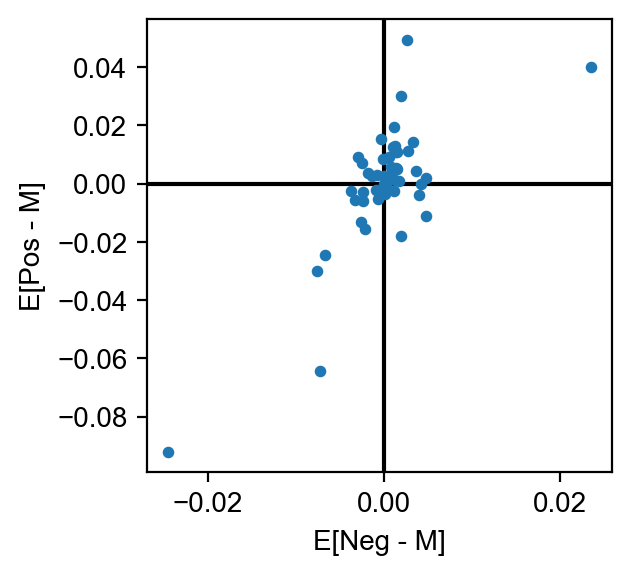

In [36]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(summary['Stim_B'], summary['Stim_B'] + summary['Pos_B'], s=10)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='k', zorder=-1)
ax.vlines(x=0, ymin=ylim[0], ymax=ylim[1], color='k', zorder=-1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('E[Neg - M]')
ax.set_ylabel('E[Pos - M]')

In [37]:
gepnameinfo_forplot = gepnameinfo.loc[~gepnameinfo['Short_Name'].isnull(), :]
gepnameinfo_forplot.index = gepnameinfo_forplot['Short_Name']
gepnameinfo_forplot = gepnameinfo_forplot.loc[summary.index,:]
gepnameinfo_forplot.head()

cGep_Name Old_Short_Name  \
0                                                     
CellCycle-G2M          CellCycle-G2M  CellCycle-G2M   
Translation    CD4-Naive_Translation    Translation   
HLA                              HLA            HLA   
ISG                              ISG            ISG   
Mito                     MALAT1_Mito           Mito   

                                 Long_Name     Short_Name Shortest_Name  \
0                                                                         
CellCycle-G2M         Cell Cycle G2M Phase  CellCycle-G2M     G2M-phase   
Translation                    Translation    Translation   Translation   
HLA                                    HLA            HLA           HLA   
ISG            Interferon Stimulated Genes            ISG           ISG   
Mito                   Mitochondrial Genes           Mito          Mito   

                    Class  Num_Datasets Notes Reviewed Filter  
0                                                              
CellCycle-G2M  Functional           7.0   NaN        Y    NaN  
Translation    Functional           6.0   NaN        Y    NaN  
HLA            Functional           6.0   NaN        Y    NaN  
ISG            Functional           7.0   NaN        Y    NaN  
Mito             Artifact           5.0   NaN        Y    NaN

 - Lineage AIM
 - Functional AIM
 - Functional Stim
 - Lineage Non-AIM
 - Other

In [38]:
summary['Category'] = 'Other'
summary['Class'] = gepnameinfo_forplot.loc[summary.index, 'Class']
ind = (summary['Pos_Q']<.05) & (summary['Class']=='Lineage')
summary.loc[ind, 'Category'] = 'AIM lineage'
ind = (summary['Pos_Q']<.05) & (summary['Pos_B']>0) & (summary['Class']=='Functional')
summary.loc[ind, 'Category'] = 'AIM functional'
#ind = (summary['Pos_Q']<.05) & (summary['Pos_B']<0) & (summary['Class']=='Lineage')
#summary.loc[ind, 'Category'] = 'AIM- lineage'
summary.loc[summary['GEP'].isin(['ISG', 'Metallothionein']), 'Category'] = 'Millieu'


summary

GEP        Stim_P         Pos_P  \
0                                                                      
CellCycle-G2M              CellCycle-G2M  2.084678e-02  1.908765e-09   
Translation                  Translation  6.306483e-01  1.296259e-01   
HLA                                  HLA  2.087534e-01  1.233167e-02   
ISG                                  ISG  8.920519e-07  3.091202e-05   
Mito                                Mito  8.792769e-01  6.591375e-01   
Doublet-RBC                  Doublet-RBC  6.028475e-01  9.448199e-02   
gdT                                  gdT  7.708200e-01  3.570240e-01   
CellCycle-S                  CellCycle-S  3.818367e-01  4.440029e-07   
Cytotoxic                      Cytotoxic  7.604231e-01  3.835751e-01   
Doublet-Platelet        Doublet-Platelet  9.021331e-01  1.096671e-01   
NME1/FABP5                    NME1/FABP5  6.359834e-01  2.026960e-06   
Th22                                Th22  2.024303e-01  2.163389e-04   
MAIT                                MAIT  7.769679e-01  6.885472e-01   
CellCycle-Late-S        CellCycle-Late-S  6.445891e-02  3.612352e-04   
Cytoskeleton                Cytoskeleton  4.341870e-01  3.338432e-08   
Heatshock                      Heatshock  1.226099e-01  1.742736e-07   
Multi-Cytokine            Multi-Cytokine  6.913244e-01  5.367424e-05   
TEMRA                              TEMRA  8.370324e-01  9.867789e-01   
Doublet-Myeloid          Doublet-Myeloid  9.955496e-01  9.455492e-01   
Metallothionein          Metallothionein  1.534019e-03  3.362152e-09   
CD4-CM                            CD4-CM  7.770982e-02  2.034156e-01   
IEG                                  IEG  1.969230e-02  5.754655e-01   
CD8-EM                            CD8-EM  8.713158e-01  1.102214e-01   
IEG2                                IEG2  1.675524e-01  1.705129e-01   
CD4-Naive                      CD4-Naive  3.054397e-02  2.064950e-05   
Treg                                Treg  6.073745e-01  5.434733e-04   
Th17-Resting                Th17-Resting  3.116194e-02  3.300037e-07   
Poor-Quality                Poor-Quality  4.826268e-01  1.699607e-01   
CD8-Naive                      CD8-Naive  2.568103e-01  7.970661e-07   
RGCC/MYADM                    RGCC/MYADM  6.957566e-02  8.605049e-05   
TIMD4/TIM3                    TIMD4/TIM3  1.183876e-01  5.021151e-04   
Doublet-Plasmablast  Doublet-Plasmablast  5.298684e-02  2.094795e-01   
BCL2/FAM13A                  BCL2/FAM13A  9.492477e-01  4.281498e-03   
IL10/IL19                      IL10/IL19  1.178950e-02  5.451387e-01   
Th2-Activated              Th2-Activated  9.288435e-01  5.857901e-04   
Th2-Resting                  Th2-Resting  6.381560e-02  5.610806e-01   
ICOS/CD38                      ICOS/CD38  1.557219e-02  1.546842e-06   
Doublet-Bcell              Doublet-Bcell  3.793845e-01  6.279564e-02   
Th1-Like                        Th1-Like  4.504481e-02  7.520516e-05   
CTLA4/CD38                    CTLA4/CD38  8.000117e-01  9.656659e-09   
CD8-Trm                          CD8-Trm  7.895893e-01  6.937123e-02   
Th17-Activated            Th17-Activated  4.069836e-01  2.149004e-03   
Tfh-2                              Tfh-2  5.805604e-01  6.237027e-03   
OX40/EBI3                      OX40/EBI3  6.567321e-01  2.614651e-05   
CD172a/MERTK                CD172a/MERTK  6.031087e-01  5.426553e-02   
IEG3                                IEG3  1.860655e-01  5.202848e-01   
Doublet-Fibroblast    Doublet-Fibroblast  8.670727e-01  3.914691e-04   
SOX4/TOX2                      SOX4/TOX2  7.794582e-01  8.988945e-02   
CD40LG/TXNIP                CD40LG/TXNIP  4.365977e-01  2.997693e-04   
Tph                                  Tph  6.065339e-01  1.974150e-03   
Exhaustion                    Exhaustion  1.153746e-01  9.295554e-05   
Tfh-1                              Tfh-1  5.648692e-01  4.028395e-01   

                       Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  \
0                                                                      

<AxesSubplot:xlabel='GEP', ylabel='0'>

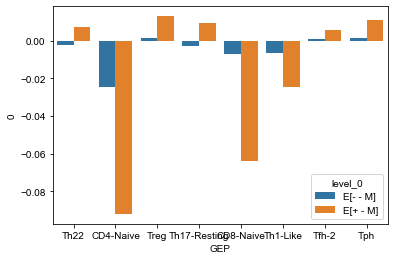

In [39]:
X = summary.loc[summary['Category']=='AIM lineage', ['Stim_B', 'Pos_B']]
X.index.name = 'GEP'


X['E[+ - M]' ] = X['Stim_B'] + X['Pos_B']
X['E[- - M]' ] = X['Stim_B']
Xflat = X[['E[- - M]', 'E[+ - M]' ]].unstack().reset_index()
sns.barplot(x='GEP', y=0, hue='level_0', data=Xflat)

In [40]:
summary['Category'].value_counts()

Other             25
AIM functional    17
AIM lineage        8
Millieu            2
Name: Category, dtype: int64

In [41]:
summary.loc[(summary['Category']=='AIM lineage') * (summary['Pos_B']>0), :].sort_values(by='Pos_P').index

Index(['Th17-Resting', 'Th22', 'Treg', 'Tph', 'Tfh-2'], dtype='object', name=0)

In [42]:
summary.loc[(summary['Category']=='AIM lineage') * (summary['Pos_B']<0), :].sort_values(by='Pos_P').index

Index(['CD8-Naive', 'CD4-Naive', 'Th1-Like'], dtype='object', name=0)

In [43]:
summary.loc[(summary['Category']=='AIM functional') * (summary['Pos_B']>0), :].sort_values(by='Pos_P').index

Index(['CellCycle-G2M', 'CTLA4/CD38', 'Cytoskeleton', 'Heatshock',
       'CellCycle-S', 'ICOS/CD38', 'NME1/FABP5', 'OX40/EBI3', 'Multi-Cytokine',
       'RGCC/MYADM', 'Exhaustion', 'CellCycle-Late-S', 'TIMD4/TIM3',
       'Th2-Activated', 'Th17-Activated', 'BCL2/FAM13A', 'HLA'],
      dtype='object', name=0)

In [44]:
'CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S',

'Exhaustion', 'Cytoskeleton', 'HeatShock', 'HLA'

[ 'CTLA4+/CD38+-Activation', 
        'ICOS/CD38-Activation', 'Early-Activation',
       'OX40/EBI3-Activation', 'Multi-Cytokine', 'RGCC/MYADM', 
       'CCR10-Migration',  'TIMD4/TIM3-Activation',
       'BCL2-Survival', 'HLA']

['CTLA4+/CD38+-Activation',
 'ICOS/CD38-Activation',
 'Early-Activation',
 'OX40/EBI3-Activation',
 'Multi-Cytokine',
 'RGCC/MYADM',
 'CCR10-Migration',
 'TIMD4/TIM3-Activation',
 'BCL2-Survival',
 'HLA']

In [45]:
summary.loc['Cytoskeleton', 'Pos_P']

3.3384316891618966e-08

In [46]:
summary.loc['Heatshock', 'Pos_P']

1.7427358871881898e-07

In [47]:
summary.loc['HLA', 'Pos_P']

0.01233167059760749

In [48]:
! ls -lah ../../../Data/TCAT/Proliferation/Proliferation.AllDataset.PerSamplePairedTtest.Metaanalysis.tsv

-rw-rw----. 1 dk718 srlab 2.6K Mar  1 12:18 ../../../Data/TCAT/Proliferation/Proliferation.AllDataset.PerSamplePairedTtest.Metaanalysis.tsv


In [49]:
prolif_assoc = pd.read_csv('../../../Data/TCAT/Proliferation/Proliferation.AllDataset.PerSamplePairedTtest.Metaanalysis.tsv',
            sep='\t', index_col=0)

In [51]:
prolif_associated = list(prolif_assoc.index[(prolif_assoc['Mean_Log2_Ratio']>0) & (prolif_assoc['P']<.05)])

In [52]:
len(set(prolif_associated)), len(set(prolif_associated).intersection(summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)]))

(12, 11)

In [53]:
set(prolif_associated) - set(summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)])

{'IL10/IL19'}

In [54]:
ct = pd.crosstab((summary.loc[prolif_assoc.index, 'Pos_Q']<.05) & (summary.loc[prolif_assoc.index, 'Pos_B']>0),
(prolif_assoc['Mean_Log2_Ratio']>0) & (prolif_assoc['P']<.05))

ct

col_0  False  True
row_0             
False     27     1
True      10    11

In [55]:
ct.loc[True, True]+= 3 # Include 3 cell cycle programs which were excluded from prolif_assoc since they defined the proliferation phenotype

In [56]:
ct

col_0  False  True
row_0             
False     27     1
True      10    14

In [57]:
from scipy.stats import fisher_exact
fisher_exact(ct)

(37.8, 2.0900883791749196e-05)

In [200]:
sorted(summary.index)

['BCL2/FAM13A',
 'CD172a/MERTK',
 'CD4-CM',
 'CD4-Naive',
 'CD40LG/TXNIP',
 'CD8-EM',
 'CD8-Naive',
 'CD8-Trm',
 'CTLA4/CD38',
 'CellCycle-G2M',
 'CellCycle-Late-S',
 'CellCycle-S',
 'Cytoskeleton',
 'Cytotoxic',
 'Doublet-Bcell',
 'Doublet-Fibroblast',
 'Doublet-Myeloid',
 'Doublet-Plasmablast',
 'Doublet-Platelet',
 'Doublet-RBC',
 'Exhaustion',
 'HLA',
 'Heatshock',
 'ICOS/CD38',
 'IEG',
 'IEG2',
 'IEG3',
 'IL10/IL19',
 'ISG',
 'MAIT',
 'Metallothionein',
 'Mito',
 'Multi-Cytokine',
 'NME1/FABP5',
 'OX40/EBI3',
 'Poor-Quality',
 'RGCC/MYADM',
 'SOX4/TOX2',
 'TEMRA',
 'TIMD4/TIM3',
 'Tfh-1',
 'Tfh-2',
 'Th1-Like',
 'Th17-Activated',
 'Th17-Resting',
 'Th2-Activated',
 'Th2-Resting',
 'Th22',
 'Tph',
 'Translation',
 'Treg',
 'gdT']

In [201]:
summary['Category'].unique()

array(['AIM functional', 'Other', 'Millieu', 'AIM lineage'], dtype=object)

In [202]:
pal = [sns.color_palette('colorblind')[3], sns.color_palette('colorblind')[2], sns.color_palette('colorblind')[1]]


In [203]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [204]:
cmap = {'AIM functional':sns.color_palette('colorblind')[3],  'AIM lineage': sns.color_palette('tab10')[4],
        'Millieu':sns.color_palette('tab10')[5], 'Other':sns.color_palette('tab10')[6]}

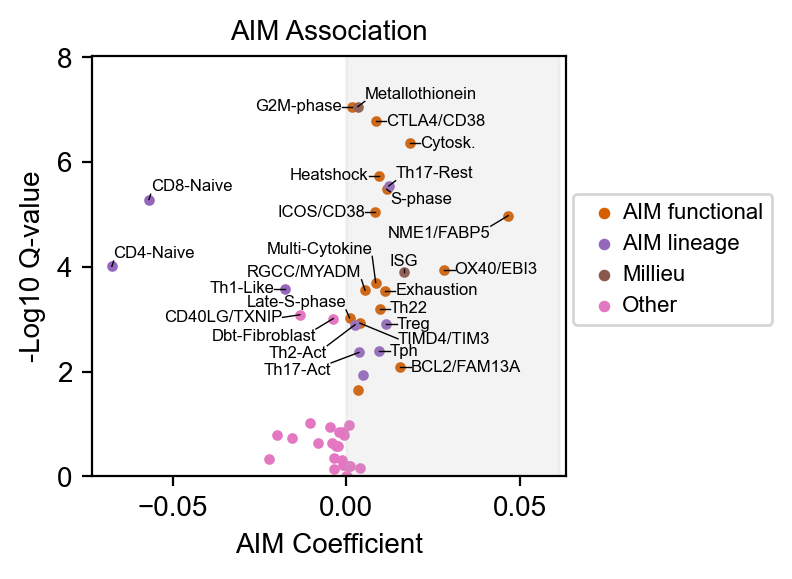

In [205]:
(fig,axes) = plt.subplots(1,2, figsize=(3.9,3), dpi=200, gridspec_kw={'left':0.12, 'bottom':0.2, 'top':0.9, 'width_ratios':[3, .5]})
#ind = (summary['Pos_B']>0) & (summary['Pos_Q']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')

xval = 'Pos_B'
yval = 'Pos_logQ'

ax = axes[0]
legax = axes[1]
for (k,g) in summary.groupby('Category'):
    ax.scatter(g[xval], g[yval], s=8,  label=k, color=cmap[k])
    legax.scatter([], [], s=10, label=k, color=cmap[k])
    
    
    
#ax.scatter(summary.loc[ind, xval], summary.loc[ind, yval], s=8, color='r', edgecolor='None')
#ax.scatter(summary.loc[~ind, xval], summary.loc[~ind, yval], s=8, color='b', edgecolor='None')
ax.set_ylabel('-Log10 Q-value', fontsize=10)
ax.set_xlabel('AIM Coefficient', fontsize=10)
ax.set_title('AIM Association', fontsize=10)

fs = 6



#toplot = summary.index[(summary['Pos_logQ']>3.5) | (summary['Pos_logQ']>2) & (summary['Pos_B']>.002) ]
toplot = summary.index[(summary['Pos_logQ']>2)]


for i,g in enumerate(toplot):
    lab = shorten_map[g]

    #if g in ['Th2-Activated']:
    #    continue
    
    if g in ['CellCycle-G2M', 'Heatshock', 'ICOS/CD38', 'Th1-Like']: deltax = -0.003; deltay =0; ha='right'; va='center' ## Left
    elif g in ['Metallothionein', 'Th17-Resting',]: deltax = 0.002; deltay = .1; ha='left'; va='bottom' ## Upper-right
    elif g in [ 'CD8-Naive', 'CD4-Naive']: deltax = 0.0005; deltay = .1; ha='left'; va='bottom' ## Upper-right

    elif g in ['CellCycle-S', ]: deltax = 0.001; deltay = -.05; ha='left'; va='top' ## Lower-right
    elif g in ['TIMD4/TIM3']: deltax = 0.011; deltay = -.3; ha='left'; va='center' ## Lower-right 2

    elif g in [ 'Th2-Activated', ]: deltax = -0.008; deltay =-0.4; ha='right'; va='top' ## Lower-Left
    elif g in ['Th17-Activated', ]: deltax = -0.008; deltay =-0.2; ha='right'; va='top' ## Lower-Left

    elif g in ['NME1/FABP5' ]: deltax = -0.005; deltay =-0.2; ha='right'; va='top' ## Lower-Left
    elif g in ['Doublet-Fibroblast',  ]: deltax = -0.005; deltay =-0.2; ha='right'; va='top' ## Lower-Left

    elif g in ['CD40LG/TXNIP']: deltax = -0.005; deltay =-0.05; ha='right'; va='center' ## Lower-Left

    elif g in ['ISG',]: deltax = 0; deltay =0.05; ha='center'; va='bottom' ## Above
    elif g in ['Multi-Cytokine',]: deltax = -0.001; deltay =0.5; ha='right'; va='bottom' ## Upper-Left
    elif g in ['CellCycle-Late-S',]: deltax = -0.001; deltay =0.15; ha='right'; va='bottom' ## Upper-Left

    elif g in ['RGCC/MYADM']: deltax = -0.001; deltay =0.2; ha='right'; va='bottom' ## Upper-Left 2

    else: deltax=.003; deltay=0; ha='left'; va='center' # Default to right

    if g not in ['Th2-2']:
        ax.text(summary.at[g, xval]+deltax, summary.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([summary.at[g, xval], summary.at[g, xval]+deltax], [summary.at[g, yval], summary.at[g, yval]+deltay], color='k', lw=.5)
        


ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1]+.5)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1]+.011)
ax.fill_between([0, xlim[1]+.009], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)


legax.axis('off')
legax.legend(bbox_to_anchor=(2.05, .7), fontsize=8, handletextpad=-.2)


plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.OLSpos.pdf'))
plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.OLSpos.png'))

In [208]:
toplot = summary.index[(summary['Pos_logQ']>2) & (summary['Pos_B']>0)]

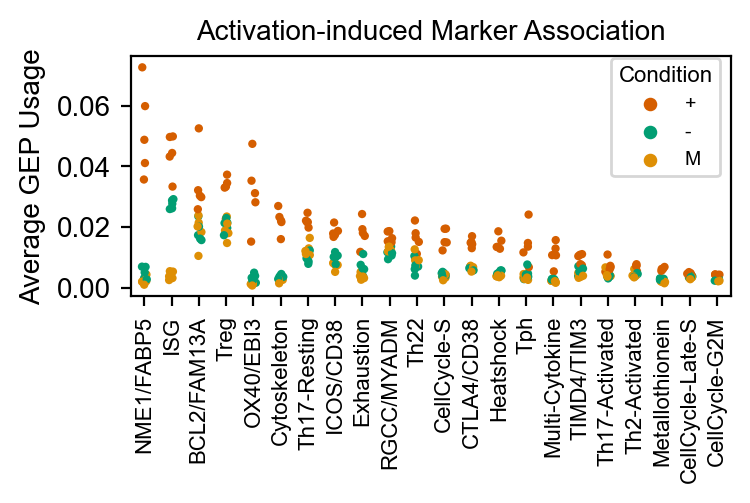

In [209]:
rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat['GEP'] = rf_usage_norm_annot_flat['level_0'].replace(name_dict)
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP'].isin(toplot),:]
rf_usage_norm_annot_flat['Sort_Status'] = rf_usage_norm_annot_flat['Sort_Status'].replace({'U':'M'})

plot_order = list(rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['Sort_Status'] == '+', :].groupby('GEP')[0].mean().sort_values(ascending=False).index)
#(fig,ax) = plt.subplots(1,1, figsize=(5,4), dpi=200, gridspec_kw={'bottom':.55})
(fig,ax) = plt.subplots(1,1, figsize=(4,2.5), dpi=200, gridspec_kw={'left':.2, 'bottom':.4, 'right':.95})

pal = [sns.color_palette('colorblind')[3], sns.color_palette('colorblind')[2], sns.color_palette('colorblind')[1]]
sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=plot_order, s=3, ax=ax, palette=pal,
             hue_order=['+', '-', 'M'])


plot_names = []
for x in plot_order:
    if x in rename2:
        plot_names.append(rename2[x])
    else:
        plot_names.append(x)
                        



ax.set_xticklabels(plot_names, rotation=90, fontsize=8)
ax.legend(loc=(.8,.5), title='Condition', fontsize=7, markerscale=.5, title_fontsize=8)
ax.set_ylabel('Average GEP Usage', fontsize=10)
ax.set_xlabel('')
ax.set_title('Activation-induced Marker Association', fontsize=10)

plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.png'))
plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.pdf'))


## Output supplementary table

In [156]:
column_relable = {'Stim_B':'CEFX Coef.', 'Stim_P':'CEFX P', 'Stim_Q':'CEFX Q', 'Pos_B':'AIM+ Coef.', 'Pos_P':'AIM+ P',  'Pos_Q':'AIM+ Q',
       'Category':'Activation Type', 'Class':'cGEP Class'}


summary_tooutput = summary.drop('GEP', axis=1).rename(column_relable, axis=1)
summary_tooutput = summary_tooutput[[ 'CEFX Coef.', 'CEFX P',   'CEFX Q',  'AIM+ Coef.', 'AIM+ P', 'AIM+ Q', 'Activation Type', 'cGEP Class']]
summary_tooutput.index.name = 'cGEP'

outfn = '../../../Tables/Table_S6_AIMAssociation.xlsx'

with pd.ExcelWriter(outfn, engine='xlsxwriter') as writer: 
    summary_tooutput.to_excel(writer, sheet_name='AIM Association')

    for column in summary_tooutput:
        column_length = max(summary_tooutput[column].astype(str).map(len).max(), len(column))
        col_idx = summary_tooutput.columns.get_loc(column)
        writer.sheets['AIM Association'].set_column(col_idx, col_idx, column_length)

## Per lineage separately 

In [157]:
allres = []

for lin in rf_usage_norm_annot['lineage'].unique():
    print(lin)
    ind = rf_usage_norm_annot['lineage'].isin([lin])
    totest = rf_usage_norm_annot.loc[ind, :]
    totest = totest.rename(columns=name_dict)

    totest['Sort_Status'] = totest['Sort_Status'].astype(str)
    
    average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

    predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
    average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
    predicter.index = average_usage.index
    predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
    predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
    predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
    predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
    predicter_dummy['Intercept'] = 1
    summary = []

    for g in average_usage.columns:
        mod = sm.OLS(average_usage[g], predicter_dummy)
        res = mod.fit()
        summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
    summary = pd.DataFrame(summary)
    summary.index = summary[0]
    summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


    r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
    r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
    summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)
    summary['lineage'] = lin
    allres.append(summary)
    
allres = pd.concat(allres, axis=0)

CD4_CM
CD4_Naive
CD4_EM
MAIT
CD8_CM
CD8_EM
Treg
gdT
CD8_TEMRA
CD8_Naive
DP
DN
CD4_TEMRA


In [158]:
renmap = {'OX40/EBI3-Activation': 'OX40/EBI3', 'TNFRSF18+-Treg':'TNFRSF18+', 'OX40/EBI3-Activation':'OX40/EBI3',
          'ICOS/CD38-Activation': 'ICOS/CD38', 'IL10/IL19-Secretion': 'IL10/IL19',
          'TIMD4/TIM3-Activation': 'TIMD4/TIM3',
          'CTLA4+/CD38+-Activation': 'CTLA4/CD38'}

allres['GEP'] = allres['GEP'].replace(renmap)

Text(0.5, 93.44444444444443, 'Lineage')

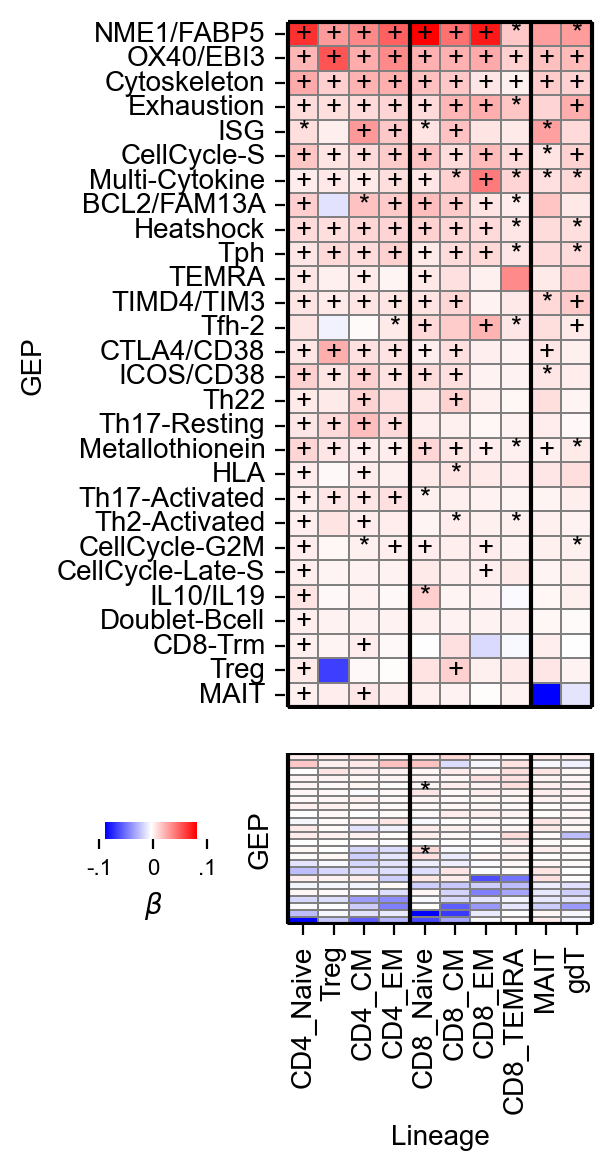

In [159]:
coef_pos = allres.pivot_table(index='GEP', columns='lineage', values='Pos_B')
P_pos = allres.pivot_table(index='GEP', columns='lineage', values='Pos_P')
Q_pos = allres.pivot_table(index='GEP', columns='lineage', values='Pos_Q')

vmax = max(coef_pos.max().max(), coef_pos.min().min()*-1)
vmin = vmax*-1
vmin = .08
vmax = -.08


top_ind = ((coef_pos>0) & (Q_pos<.05)).sum(axis=1)>0
(fig,axes) = plt.subplots(2,1, figsize=(2,6), dpi=200, gridspec_kw={'height_ratios':[4, 1], 'hspace':.1})

linorder = ['CD4_Naive',  'Treg', 'CD4_CM', 'CD4_EM', 
            'CD8_Naive', 'CD8_CM', 'CD8_EM', 'CD8_TEMRA', 
            'MAIT', 'gdT']

coef_pos_top = coef_pos.loc[top_ind, linorder]
top_order = coef_pos_top.mean(axis=1).sort_values(ascending=False).index
coef_pos_bottom = coef_pos.loc[~top_ind, linorder]
bottom_order = coef_pos_bottom.mean(axis=1).sort_values(ascending=False).index

cax = axes[1].inset_axes([-0.6, 0.5, .35, 0.1], transform=axes[1].transAxes, zorder=-1)

sns.heatmap(coef_pos_top.loc[top_order, :], ax=axes[0], cmap='bwr', vmin=vmin, vmax=vmax,
            xticklabels=False, yticklabels=True, linewidths=.1, linecolor='.5', cbar=True, cbar_ax=cax,
           cbar_kws={'orientation':'horizontal'})
sns.heatmap(coef_pos_bottom.loc[bottom_order, :], ax=axes[1], cmap='bwr', vmin=vmin, vmax=vmax,
            xticklabels=True, yticklabels=False, linewidths=.1, linecolor='.5', cbar=True, cbar_ax=cax,
           cbar_kws={'orientation':'horizontal', 'label':r'$ \beta $'})
axes[0].set_xlabel('')



for j,g in enumerate(top_order):
    for i,lin in enumerate(linorder):
        if (Q_pos.loc[g,lin] < .05) & (coef_pos.loc[g, lin]>0):
            axes[0].text(i+.5,j+.5, '+', ha='center', va='center')
        elif (P_pos.loc[g,lin] < .05)  & (coef_pos.loc[g, lin]>0):
            axes[0].text(i+.5,j+.5, '*', ha='center', va='center')    
            
            
for j,g in enumerate(bottom_order):
    for i,lin in enumerate(linorder):
        if (Q_pos.loc[g,lin] < .05) & (coef_pos.loc[g, lin]>0):
            axes[1].text(i+.5,j+.5, '+', ha='center', va='center')
        elif (P_pos.loc[g,lin] < .05)  & (coef_pos.loc[g, lin]>0):
            axes[1].text(i+.5,j+.5, '*', ha='center', va='center')    
            
cax.tick_params(labelsize=8)
cax.set_xticks([-.1, 0, .1])

cax.set_xticklabels(['-.1', '0', '.1'])

            
            

for i,order in enumerate([top_order, bottom_order]):
    axes[i].hlines(y=0, xmin=0, xmax=len(linorder), color='k')
    axes[i].hlines(y=len(order), xmin=0, xmax=len(linorder), color='k')
    axes[i].vlines(x=0, ymin=0, ymax=len(order), color='k')
    axes[i].vlines(x=4, ymin=0, ymax=len(order), color='k')
    axes[i].vlines(x=8, ymin=0, ymax=len(order), color='k')
    axes[i].vlines(x=10, ymin=0, ymax=len(order), color='k')
    axes[i].set_xlim([-.1, 10.1])
    axes[i].set_ylim([len(order) + 0.1, -.1])

    
axes[1].set_xlabel('Lineage')

In [160]:
from scipy.stats import ranksums
ranksumres = []
for lin, lindat in rf_usage_norm_annot.groupby('lineage'):
    for gep in lindat.columns[:-5]:
        (H,P) = ranksums(lindat.loc[lindat['Sort_Status']=='+', gep], lindat.loc[lindat['Sort_Status']!='+', gep])
        ranksumres.append([lin, name_dict[gep], H, P])

        
ranksumres = pd.DataFrame(ranksumres, columns=['Lineage', 'Gep', 'H', 'P'])
ranksumres.head()

Lineage            Gep          H              P
0  CD4_CM  CellCycle-G2M  31.234460  3.629572e-214
1  CD4_CM    Translation -22.341437  1.462606e-110
2  CD4_CM            HLA  46.477556   0.000000e+00
3  CD4_CM            ISG  57.820566   0.000000e+00
4  CD4_CM           Mito -18.552189   7.829788e-77

In [161]:
ranksumres.loc[ranksumres['Gep']=='Multi-Cytokine', :]

Lineage             Gep          H              P
16      CD4_CM  Multi-Cytokine  47.788655   0.000000e+00
66      CD4_EM  Multi-Cytokine  32.020089  5.728569e-225
116  CD4_Naive  Multi-Cytokine  28.206135  4.917373e-175
166  CD4_TEMRA  Multi-Cytokine   2.395049   1.661813e-02
216     CD8_CM  Multi-Cytokine   8.604572   7.660182e-18
266     CD8_EM  Multi-Cytokine  33.533427  1.570422e-246
316  CD8_Naive  Multi-Cytokine  10.112082   4.883531e-24
366  CD8_TEMRA  Multi-Cytokine  11.140698   7.949402e-29
416         DN  Multi-Cytokine   5.821177   5.843454e-09
466         DP  Multi-Cytokine  11.471362   1.837435e-30
516       MAIT  Multi-Cytokine  17.983653   2.616721e-72
566       Treg  Multi-Cytokine  16.717649   9.749066e-63
616        gdT  Multi-Cytokine  18.285164   1.086360e-74

In [162]:
persamp = rf_usage_norm_annot.rename(columns=name_dict).groupby(['Biobank_ID', 'Sort_Status', 'lineage']).mean().reset_index()

In [163]:
from scipy.stats import ranksums
ranksumres = []
for lin, lindat in persamp.groupby('lineage'):
    for gep in lindat.columns[3:]:
        (H,P) = ranksums(lindat.loc[lindat['Sort_Status']=='+', gep], lindat.loc[lindat['Sort_Status']!='+', gep])
        ranksumres.append([lin, gep, H, P])

ranksumres = pd.DataFrame(ranksumres, columns=['Lineage', 'Gep', 'H', 'P'])
ranksumres.head()

Lineage            Gep         H         P
0  CD4_CM  CellCycle-G2M  2.082066  0.037336
1  CD4_CM    Translation -2.082066  0.037336
2  CD4_CM            HLA  3.061862  0.002200
3  CD4_CM            ISG  3.061862  0.002200
4  CD4_CM           Mito  0.612372  0.540291

In [164]:
ranksumres.loc[ranksumres['Gep']=='Multi-Cytokine', :]

Lineage             Gep         H         P
16      CD4_CM  Multi-Cytokine  3.061862  0.002200
68      CD4_EM  Multi-Cytokine  3.061862  0.002200
120  CD4_Naive  Multi-Cytokine  3.061862  0.002200
172  CD4_TEMRA  Multi-Cytokine  1.102270  0.270344
224     CD8_CM  Multi-Cytokine  2.449490  0.014306
276     CD8_EM  Multi-Cytokine  3.061862  0.002200
328  CD8_Naive  Multi-Cytokine  3.061862  0.002200
380  CD8_TEMRA  Multi-Cytokine  1.959592  0.050044
432         DN  Multi-Cytokine  1.959592  0.050044
484         DP  Multi-Cytokine  2.082066  0.037336
536       MAIT  Multi-Cytokine  2.816913  0.004849
588       Treg  Multi-Cytokine  3.061862  0.002200
640        gdT  Multi-Cytokine  2.816913  0.004849

In [15]:
rename2 = {'OX40/EBI3-Activation': 'OX40/EBI3',
'TNFRSF18+-Treg':  'TNFRSF18+',
'OX40/EBI3-Activation':  'OX40/EBI3',
'ICOS/CD38-Activation':  'ICOS/CD38',
'IL10/IL19-Secretion':  'IL10/IL19',
'TIMD4/TIM3-Activation':  'TIMD4/TIM3',
'CTLA4+/CD38+-Activation': 'CTLA4/CD38',
'Early-Activation':'NME1/FABP5'}

In [19]:

linorder = ['CD4_Naive',  'Treg', 'CD4_CM', 'CD4_EM', 
            'CD8_Naive', 'CD8_CM', 'CD8_EM', 'CD8_TEMRA', 
            'MAIT', 'gdT']

In [25]:
rf_usage_norm_annot['lineage'].value_counts()

CD4_CM       9922
CD4_Naive    9273
CD8_EM       5565
CD8_Naive    4868
CD4_EM       4767
CD8_TEMRA    1752
DP           1535
gdT          1508
MAIT         1428
CD8_CM       1219
Treg          945
DN            292
CD4_TEMRA     148
Name: lineage, dtype: int64

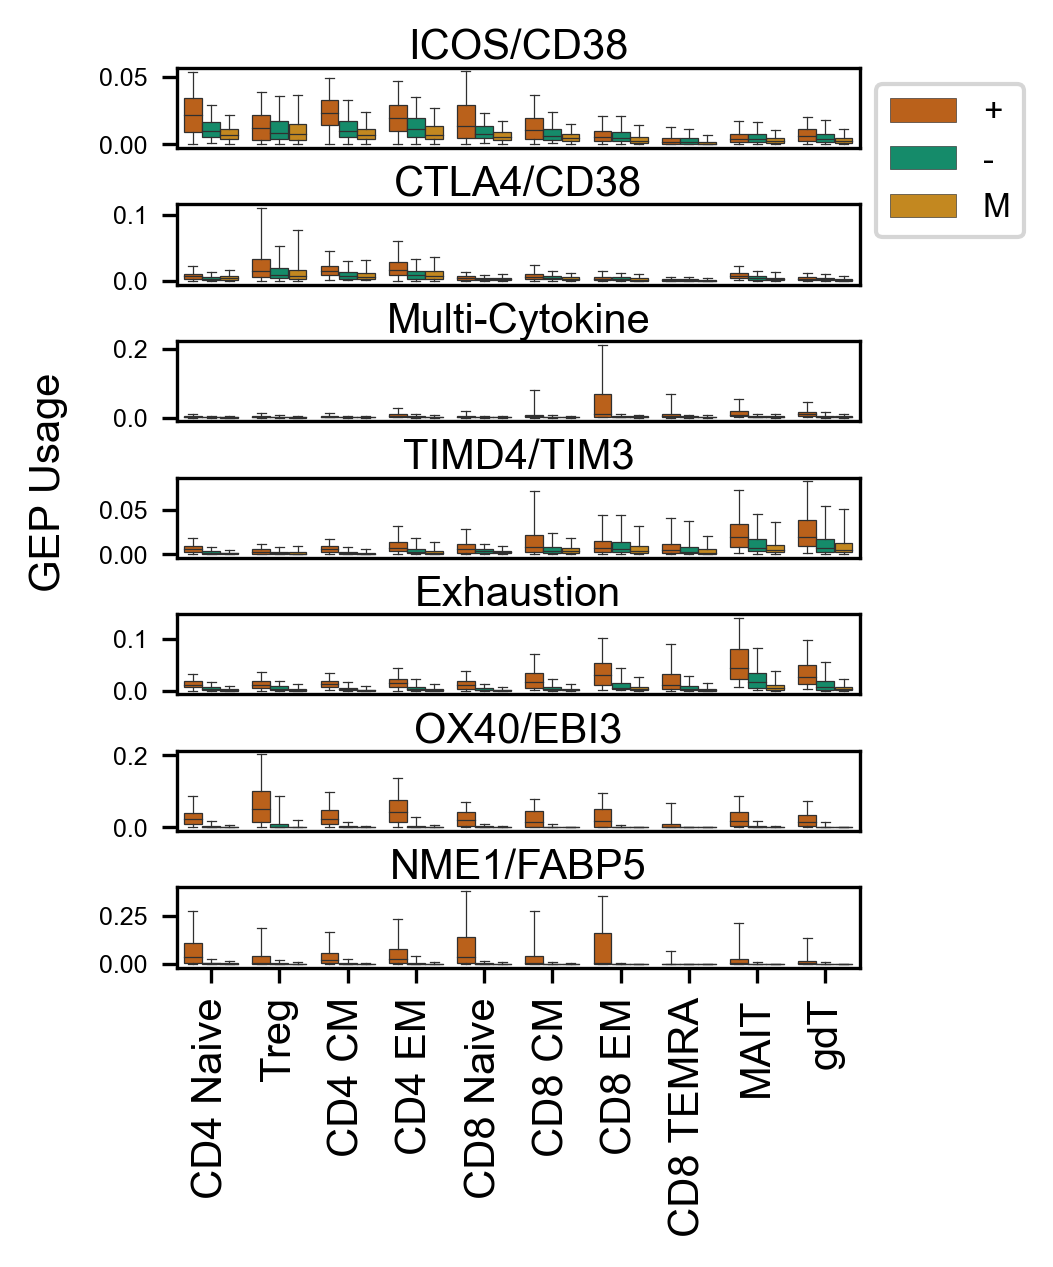

In [26]:
geps = ['ICOS/CD38', 'CTLA4/CD38', 'Multi-Cytokine', 'TIMD4/TIM3', 'Exhaustion', 'OX40/EBI3', 'NME1/FABP5']

pal = [sns.color_palette('colorblind')[3], sns.color_palette('colorblind')[2], sns.color_palette('colorblind')[1]]

toplot = rf_usage_norm_annot.rename(columns=name_dict) #.rename(columns=rename2)
toplot['Sort_Status'] = toplot['Sort_Status'].replace({'U':'M'})
(fig,axes) = plt.subplots(len(geps),1, figsize=(3.5,4), dpi=300, gridspec_kw={'hspace':.7, 'left':0.15, 'right':.8, 'bottom':.2, 'top':.95})
for i,g in enumerate(geps):
    
    ax = sns.boxplot(x='lineage', y=g, hue='Sort_Status', whis=[5, 95], linewidth=0.3, palette=pal,
            data=toplot, order=linorder, ax=axes[i], showfliers=False)
    if i != 0:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1,1), fontsize=8)
        #ax.set_yticks([0, 0.03])

    
    
    if (i == len(axes) - 1):
        ax.set_xticklabels([x.replace('_', ' ') for x in linorder], rotation=90, fontsize=10)
    else:
        ax.set_xticks([])
        
        
    ax.tick_params(axis='y', which='major', labelsize=6)        
    ax.set_xlabel('')

    
    axes[i].set_title(g, fontsize=10, pad=-2)
    axes[i].set_ylabel('')
    
plt.figtext(0.01, 0.52, 'GEP Usage', rotation = 90, fontsize=10)
    
plt.savefig(os.path.join(figdir, 'AIM_Markers_GEPs.Boxplot.pdf'))
plt.savefig(os.path.join(figdir, 'AIM_Markers_GEPs.Boxplot.png'))

In [27]:
persamp = toplot.groupby(['Biobank_ID', 'Sort_Status', 'lineage']).mean().reset_index()

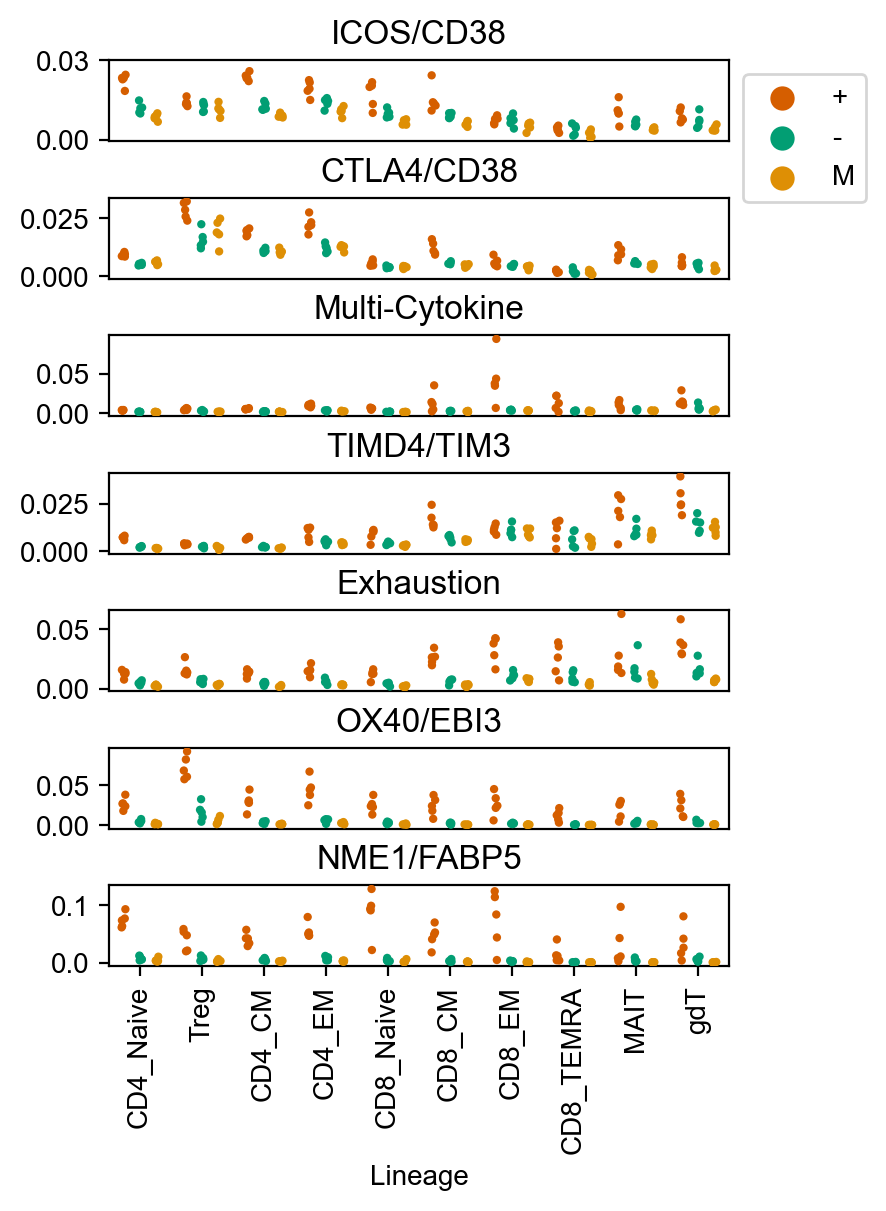

In [28]:
geps = ['ICOS/CD38', 'CTLA4/CD38', 'Multi-Cytokine', 'TIMD4/TIM3', 'Exhaustion', 'OX40/EBI3', 'NME1/FABP5']
pal = [sns.color_palette('colorblind')[3], sns.color_palette('colorblind')[2], sns.color_palette('colorblind')[1]]


(fig,axes) = plt.subplots(len(geps),1, figsize=(4,6), dpi=200, gridspec_kw={'hspace':.7})
for i,g in enumerate(geps):
    
    ax = sns.stripplot(x='lineage', y=g, hue='Sort_Status', dodge=True,
            data=persamp, order=linorder, ax=axes[i], size=3, palette=pal)
    if i != 0:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_yticks([0, 0.03])

    
    
    if (i == len(axes) - 1):
        ax.set_xticklabels(linorder, rotation=90)
        ax.set_xlabel('Lineage')
    else:
        ax.set_xticks([])
        ax.set_xlabel('')
        
    axes[i].set_title(g)
    axes[i].set_ylabel('')
    

## Repeat for CD4 EM only

In [360]:
#gepnameinfo.loc[summary.index, :]


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.05, 3.922279925849233)

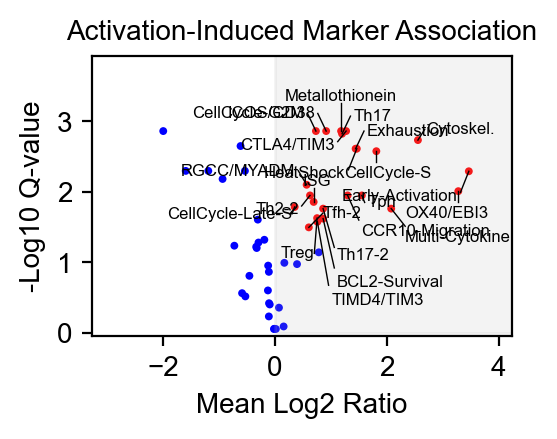

In [281]:
totest = rf_usage_norm_annot.loc[(rf_usage_norm_annot['Sort_Status']!='U') & (rf_usage_norm_annot['lineage']!='CD4_EM'),:]

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
mean_pos = average_usage_pos.mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)


summary = pd.concat([Ps, Ts, lograt, mean_pos], axis=1)
summary.columns = ['P', 'T', 'lograt', 'MeanPos']


r, summary['Q'] = fdrcorrection(summary['P'], alpha=0.05, method='indep', is_sorted=False)

summary['renamed'] = [name_dict[x] for x in summary.index]
summary.index = summary['renamed']

summary['logP'] = summary['Q'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)






(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.2, 'top':0.9})
ind = (summary['T']>0) & (summary['Q']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=8, color='r', edgecolor='None')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=8, color='b', edgecolor='None')
ax.set_ylabel('-Log10 Q-value', fontsize=10)
ax.set_xlabel('Mean Log2 Ratio', fontsize=10)
ax.set_title('Activation-Induced Marker Association', fontsize=10)

fs = 6



toplot = summary.loc[ind, 'logP'].sort_values(ascending=False).index

for i,g in enumerate(toplot):
    lab = summary.at[g, 'renamed']
    if lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'TNFRSF18+-Treg': lab = 'TNFRSF18+'
    elif lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'ICOS/CD38-Activation': lab = 'ICOS/CD38'
    elif lab == 'IL10/IL19-Secretion': lab = 'IL10/IL19'
    elif lab == 'TIMD4/TIM3-Activation': lab = 'TIMD4/TIM3'
    elif lab == 'CTLA4+/CD38+-Activation': lab='CTLA4/TIM3'
    elif lab == 'Cytoskeleton': lab='Cytoskel.'

    ## Up
    if g in ['Metallothionein']:
        ax.text(summary.at[g, 'lograt'], summary.at[g, 'logP']+.5, lab, ha='center', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']], [summary.at[g, 'logP'], summary.at[g, 'logP']+.4], color='k', lw=.5)

    ## Up
    elif g in ['ISG']:
        ax.text(summary.at[g, 'lograt']+.05, summary.at[g, 'logP']+.3, lab, ha='center', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']], [summary.at[g, 'logP'], summary.at[g, 'logP']+.2], color='k', lw=.5)
        
    
    ## Right
    elif g in ['Tph']:
        ax.text(summary.at[g, 'lograt']+.1, summary.at[g, 'logP']-.1, lab, ha='left', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.05], [summary.at[g, 'logP'], summary.at[g, 'logP']-.1], color='k', lw=.5)

    ## Low Left
    elif g in ['CellCycle-Late-S']:
        ax.text(summary.at[g, 'lograt']-.05, summary.at[g, 'logP']-.1, lab, ha='right', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']-.05], [summary.at[g, 'logP'],summary.at[g, 'logP']-.1], color='k', lw=.5)

    ## Low Left 2
    elif g in [ 'Treg']:
        ax.text(summary.at[g, 'lograt']-.05, summary.at[g, 'logP']-.5, lab, ha='right', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']-.05], [summary.at[g, 'logP'],summary.at[g, 'logP']-.5], color='k', lw=.5)
  


    
    ## Upper right
    elif g in ['Th17', 'Exhaustion']:
        ax.text(summary.at[g, 'lograt']+.2, summary.at[g, 'logP']+.25, lab, ha='left', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.15], [summary.at[g, 'logP'], summary.at[g, 'logP']+.25], color='k', lw=.5)

    ## Upper right
    elif g in ['Cytoskeleton']:
        ax.text(summary.at[g, 'lograt']+.15, summary.at[g, 'logP']+.15, lab, ha='left', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.12], [summary.at[g, 'logP'], summary.at[g, 'logP']+.15], color='k', lw=.5)
    
    ## Far upper right
    elif g in ['Tfh-2']:
        ax.text(summary.at[g, 'lograt']+.25, summary.at[g, 'logP']+.2, lab, ha='left', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.25], [summary.at[g, 'logP'], summary.at[g, 'logP']+.2], color='k', lw=.5)

    ## Upper Left
    elif g in ['ICOS/CD38-Activation', 'CellCycle-G2M']:
        ax.text(summary.at[g, 'lograt']-.2, summary.at[g, 'logP']+.25, lab, ha='right', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']-.15], [summary.at[g, 'logP'], summary.at[g, 'logP']+.25], color='k', lw=.5)

    ## Upper Left
    elif g in [ 'RGCC/MYADM']:
        ax.text(summary.at[g, 'lograt']-.2, summary.at[g, 'logP']+.2, lab, ha='right', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']-.15], [summary.at[g, 'logP'], summary.at[g, 'logP']+.2], color='k', lw=.5)
    
    
    
    
    ## Lower Left
    elif g in ['CTLA4+/CD38+-Activation', 'Th2-2']:
        ax.text(summary.at[g, 'lograt']-.2, summary.at[g, 'logP']-.2, lab, ha='right', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']-.15], [summary.at[g, 'logP'], summary.at[g, 'logP']-.15], color='k', lw=.5)
    
    ## Lower Left 2
    elif g in ['HeatShock', 'Early-Activation']:
        ax.text(summary.at[g, 'lograt']-.2, summary.at[g, 'logP']-.35, lab, ha='right', va='center', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']-.15], [summary.at[g, 'logP'], summary.at[g, 'logP']-.3], color='k', lw=.5)
    
    ## Lower Right
    elif g in ['CellCycle-S', ]:
        ax.text(summary.at[g, 'lograt']+.2, summary.at[g, 'logP']-.2, lab, ha='center', va='top', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']], [summary.at[g, 'logP'], summary.at[g, 'logP']-.15], color='k', lw=.5)      

    ## Lower Right
    elif g in ['Multi-Cytokine']:
        ax.text(summary.at[g, 'lograt']+.25, summary.at[g, 'logP']-.3, lab, ha='left', va='top', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.25], [summary.at[g, 'logP'], summary.at[g, 'logP']-.25], color='k', lw=.5)      
    ## Lower Right
    elif g in [ 'CCR10-Migration']:
        ax.text(summary.at[g, 'lograt']+.25, summary.at[g, 'logP']-.4, lab, ha='left', va='top', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.2], [summary.at[g, 'logP'], summary.at[g, 'logP']-.35], color='k', lw=.5)      

    elif g in ['Th17-2']:
        ax.text(summary.at[g, 'lograt']+.25, summary.at[g, 'logP']-.55, lab, ha='left', va='top', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.2], [summary.at[g, 'logP'], summary.at[g, 'logP']-.55], color='k', lw=.5)    
        
    elif g in ['BCL2-Survival']:
        ax.text(summary.at[g, 'lograt']+.25, summary.at[g, 'logP']-.8, lab, ha='left', va='top', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.2], [summary.at[g, 'logP'], summary.at[g, 'logP']-.7], color='k', lw=.5)      

    elif g in ['TIMD4/TIM3-Activation']:
        ax.text(summary.at[g, 'lograt']+.25, summary.at[g, 'logP']-1, lab, ha='left', va='top', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']+.2], [summary.at[g, 'logP'], summary.at[g, 'logP']-.9], color='k', lw=.5)      







    
    ## Lower Left 3
    elif g in [ 'OX40/EBI3-Activation']:
        ax.text(summary.at[g, 'lograt']-.2, summary.at[g, 'logP']-.2, lab, ha='center', va='top', fontsize=fs)
        ax.plot([summary.at[g, 'lograt'], summary.at[g, 'lograt']], [summary.at[g, 'logP'], summary.at[g, 'logP']-.15], color='k', lw=.5)           
    else:
        ax.text(summary.at[g, 'lograt'], summary.at[g, 'logP']+.05, lab, ha='center', va='bottom', fontsize=fs)

    if i > 21:
        break

ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.5)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0]-1, xlim[1]+.5)

ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)
ax.set_ylim(-0.05, ylim[1]+.5)

#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))
#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))

In [282]:
summary

P          T    lograt   MeanPos         Q  \
renamed                                                                      
CTLA4+/CD38+-Activation  0.000073  16.832371  1.271070  0.014302  0.001374   
ICOS/CD38-Activation     0.000084  16.242451  0.914517  0.018258  0.001374   
Metallothionein          0.000131  14.502243  1.181371  0.006509  0.001374   
CellCycle-G2M            0.000132  14.482709  0.731077  0.004223  0.001374   
Th17                     0.000173  13.520120  1.198922  0.019355  0.001501   
Cytoskeleton             0.000248  12.332246  2.555831  0.020488  0.001845   
HeatShock                0.000453  10.572218  1.462355  0.014360  0.002444   
Exhaustion               0.000470  10.471644  1.441390  0.018549  0.002444   
CellCycle-S              0.000561  10.003224  1.811976  0.015928  0.002653   
Early-Activation         0.001475   7.775750  3.466160  0.051301  0.005113   
RGCC/MYADM               0.002598   6.689251  0.565126  0.015320  0.007945   
OX40/EBI3-Activation     0.003388   6.226377  3.278323  0.029960  0.009789   
CCR10-Migration          0.004171   5.883576  1.298184  0.013648  0.011248   
Th2-2                    0.004344   5.818428  0.625557  0.006411  0.011248   
Tph                      0.004543   5.747519  1.553174  0.012763  0.011248   
ISG                      0.005889   5.349066  0.690974  0.044711  0.013920   
CellCycle-Late-S         0.007248   5.046661  0.351482  0.004634  0.016387   
Th17-2                   0.008273   4.861000  0.859837  0.006398  0.017321   
Multi-Cytokine           0.008327   4.851980  2.077811  0.011475  0.017321   
Treg                     0.011807   4.387342  0.752463  0.035154  0.023614   
BCL2-Survival            0.012459   4.318843  0.860195  0.033867  0.023995   
TIMD4/TIM3-Activation    0.014856   4.099790  0.757663  0.009333  0.026638   
Tfh-2                    0.018426   3.842132  0.604279  0.015518  0.031938   
HLA                      0.049983   2.776774  0.782204  0.009258  0.072198   
Th2-1                    0.072389   2.424770  0.166510  0.015240  0.101736   
Doublet-Bcell            0.077520   2.361687  0.393418  0.003962  0.106080   
IEG                      0.397534   0.946398  0.070379  0.013330  0.439825   
NK-like                  0.766405   0.317985  0.153612  0.022097  0.813328   
Doublet-Myeloid          0.843861   0.210096 -0.011014  0.006118  0.877615   
Mito                     0.882738  -0.157153  0.014486  0.035818  0.882738   
IL10/IL19-Secretion      0.875882  -0.166445 -0.019266  0.011377  0.882738   
YPEL5/JUNB               0.540851  -0.667740 -0.110626  0.010855  0.585922   
Tfh-1                    0.350703  -1.055565 -0.094503  0.012402  0.396447   
CD4-CM                   0.329326  -1.109751 -0.107521  0.017000  0.380554   
CD8-EM                   0.257625  -1.318952 -0.530764  0.037978  0.304466   
Cytotoxic                0.226581  -1.427616 -0.589537  0.028173  0.274005   
MALAT1                   0.202438  -1.522945 -0.127424  0.107605  0.250638   
CD8-Trm-Like             0.122605  -1.952501 -0.458508  0.012018  0.155499   
Doublet-RBC              0.105049  -2.088156 -0.110478  0.009836  0.136564   
Doublet-Platelet         0.083556  -2.293270 -0.123110  0.005013  0.111407   
MAIT                     0.042201  -2.944465 -0.328180  0.016895  0.062699   
gdT-Blood                0.039320  -3.015934 -0.336396  0.014741  0.060137   
Translation              0.036889  -3.081173 -0.727849  0.027551  0.058129   
SOX4/TOX2                0.032258  -3.220741 -0.296324  0.007329  0.052419   
Doublet-Plasmablast      0.028556  -3.350485 -0.191356  0.023188  0.047900   
IEG2                     0.013356  -4.231353 -0.308001  0.015034  0.024803   
CD4-EM                   0.002022  -7.152113 -0.938232  0.017867  0.006572   
TXNIP/H1FX               0.001359  -7.944578 -1.193615  0.009023  0.005049   
CD4-Naive                0.001323  -8.001471 -1.597507  0.034829  0.005049   
CD40LG/TXNIP             0.001314  -8.015729 -0.538906

In [280]:
rf_usage_norm_annot

CellCycle-G2M  CD4-Naive_Translation       HLA       ISG  \
3_AAACCTGAGACCGGAT   2.207194e-07           1.599028e-15  0.000004  0.001446   
3_AAACCTGAGAGGGCTT   2.136073e-04           3.865115e-02  0.003301  0.001185   
3_AAACCTGAGAGTCTGG   3.436558e-03           6.817934e-04  0.005287  0.009419   
3_AAACCTGAGCTAGCCC   1.402335e-03           1.147645e-01  0.000772  0.004953   
3_AAACCTGAGCTGCCCA   1.104927e-02           1.053522e-02  0.009217  0.048063   
...                           ...                    ...       ...       ...   
2_TTTGTCATCAGGCCCA   1.201801e-03           7.139465e-02  0.000808  0.012745   
2_TTTGTCATCATATCGG   6.479560e-04           4.512221e-05  0.029663  0.165494   
2_TTTGTCATCATTATCC   6.078535e-04           9.106892e-03  0.000099  0.017798   
2_TTTGTCATCGGCTACG   1.454049e-04           1.022878e-05  0.000008  0.006616   
2_TTTGTCATCTCCAGGG   2.486448e-03           7.871207e-05  0.066662  0.012586   

                    MALAT1_Mito  Doublet-RBC  gdT-Blood  CellCycle-S  \
3_AAACCTGAGACCGGAT     0.127975     0.000143   0.000016     0.000315   
3_AAACCTGAGAGGGCTT     0.014555     0.074690   0.001620     0.001004   
3_AAACCTGAGAGTCTGG     0.000071     0.006249   0.004440     0.013084   
3_AAACCTGAGCTAGCCC     0.008637     0.006519   0.002362     0.012470   
3_AAACCTGAGCTGCCCA     0.010430     0.007770   0.007430     0.006543   
...                         ...          ...        ...          ...   
2_TTTGTCATCAGGCCCA     0.050127     0.008902   0.005658     0.012563   
2_TTTGTCATCATATCGG     0.079985     0.008070   0.085719     0.002794   
2_TTTGTCATCATTATCC     0.040624     0.004677   0.000719     0.000385   
2_TTTGTCATCGGCTACG     0.412421     0.000954   0.000110     0.000383   
2_TTTGTCATCTCCAGGG     0.000261     0.006011   0.130981     0.005746   

                    Cytotoxic  Doublet-Platelet  ...  IEG_YPEL5/CREM_2  \
3_AAACCTGAGACCGGAT   0.000118          0.000033  ...          0.000002   
3_AAACCTGAGAGGGCTT   0.007318          0.003466  ...          0.006633   
3_AAACCTGAGAGTCTGG   0.009319          0.002775  ...          0.012106   
3_AAACCTGAGCTAGCCC   0.003324          0.004506  ...          0.006554   
3_AAACCTGAGCTGCCCA   0.011547          0.003583  ...          0.016645   
...                       ...               ...  ...               ...   
2_TTTGTCATCAGGCCCA   0.010216          0.004751  ...          0.019848   
2_TTTGTCATCATATCGG   0.356239          0.001591  ...          0.003766   
2_TTTGTCATCATTATCC   0.002256          0.003739  ...          0.006618   
2_TTTGTCATCGGCTACG   0.000106          0.001240  ...          0.000096   
2_TTTGTCATCTCCAGGG   0.075020          0.005779  ...          0.003274   

                    AMP-RA_Pan-Cancer  SOX4/MME  CH25H/DDIT4_Pan-Cancer  \
3_AAACCTGAGACCGGAT           0.000569  0.000049                0.206148   
3_AAACCTGAGAGGGCTT           0.029273  0.003448                0.032758   
3_AAACCTGAGAGTCTGG           0.002812  0.002873                0.013711   
3_AAACCTGAGCTAGCCC           0.004991  0.005291                0.081442   
3_AAACCTGAGCTGCCCA           0.004515  0.003832                0.026727   
...                               ...       ...                     ...   
2_TTTGTCATCAGGCCCA           0.005736  0.024348                0.069969   
2_TTTGTCATCATATCGG           0.007599  0.000898                0.002190   
2_TTTGTCATCATTATCC           0.005390  0.003252                0.036267   
2_TTTGTCATCGGCTACG           0.003874  0.009163                0.014893   
2_TTTGTCATCTCCAGGG           0.000439  0.001876                0.003106   

                    AMP-RA:Tph_Single  Pan-Cancer:Tph_Single  \
3_AAACCTGAGACCGGAT           0.017511               0.000914   
3_AAACCTGAGAGGGCTT           0.000056               0.000037   
3_AAACCTGAGAGTCTGG           0.036896               0.025580   
3_AAACCTGAGCTAGCCC           0.002071               0.000615   
3_AAACCTGAGCTGCCCA           0.005186               0.011213   
...                 

## Test simple stim vs. mock

In [461]:
totest = rf_usage_norm_annot.copy() #loc[rf_usage_norm_annot['Sort_Status']!='+',:]
totest = totest.rename(columns=name_dict)

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
predicter.index = average_usage.index
predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
predicter_dummy = predicter_dummy[['CEFX_Stimulated']]
predicter_dummy['Intercept'] = 1
summary_onlystim = []

for g in average_usage.columns:
    mod = sm.OLS(average_usage[g], predicter_dummy)
    res = mod.fit()
    summary_onlystim.append([g, res.pvalues['CEFX_Stimulated'], res.params['CEFX_Stimulated']])
    
summary_onlystim = pd.DataFrame(summary_onlystim)
summary_onlystim.index = summary_onlystim[0]
summary_onlystim.columns = ['GEP', 'Stim_P', 'Stim_B']


#r, summary_onlystim['Pos_Q'] = fdrcorrection(summary_onlystim['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
r, summary_onlystim['Stim_Q'] = fdrcorrection(summary_onlystim['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
#summary_onlystim['Pos_logQ'] = -1*summary_onlystim['Pos_Q'].apply(np.log10)


summary_onlystim.head()

GEP    Stim_P    Stim_B    Stim_Q
0                                                         
CellCycle-G2M  CellCycle-G2M  0.017781  0.001132  0.077049
Translation      Translation  0.733123 -0.003092  0.811115
HLA                      HLA  0.023542  0.003220  0.087441
ISG                      ISG  0.000009  0.031790  0.000453
Mito                    Mito  0.933875  0.000618  0.971230

In [462]:
summary_onlystim

GEP    Stim_P    Stim_B    Stim_Q
0                                                                             
CellCycle-G2M                      CellCycle-G2M  0.017781  0.001132  0.077049
Translation                          Translation  0.733123 -0.003092  0.811115
HLA                                          HLA  0.023542  0.003220  0.087441
ISG                                          ISG  0.000009  0.031790  0.000453
Mito                                        Mito  0.933875  0.000618  0.971230
Doublet-RBC                          Doublet-RBC  0.697423 -0.000191  0.788392
gdT-Blood                              gdT-Blood  0.837208 -0.000676  0.888465
CellCycle-S                          CellCycle-S  0.036818  0.006921  0.119660
Cytotoxic                              Cytotoxic  0.390349 -0.018756  0.534162
Doublet-Platelet                Doublet-Platelet  0.441449 -0.000237  0.546556
Early-Activation                Early-Activation  0.051150  0.025993  0.138246
CCR10-Migration                  CCR10-Migration  0.417500  0.002318  0.541742
MAIT                                        MAIT  0.564745 -0.004120  0.667426
CellCycle-Late-S                CellCycle-Late-S  0.008259  0.000877  0.053684
Cytoskeleton                        Cytoskeleton  0.041133  0.010334  0.119683
HeatShock                              HeatShock  0.022181  0.006217  0.087441
Multi-Cytokine                    Multi-Cytokine  0.060941  0.004812  0.138246
NK-like                                  NK-like  0.796820  0.001260  0.863221
Doublet-Myeloid                  Doublet-Myeloid  0.961857  0.000031  0.980717
Metallothionein                  Metallothionein  0.008144  0.002575  0.053684
CD4-CM                                    CD4-CM  0.012062 -0.004375  0.066278
IEG                                          IEG  0.003697  0.003974  0.053684
CD8-EM                                    CD8-EM  0.466768 -0.008050  0.564463
IEG2                                        IEG2  0.427143  0.002135  0.541742
CD4-Naive                              CD4-Naive  0.006999 -0.058296  0.053684
Treg                                        Treg  0.061147  0.007113  0.138246
Th17                                        Th17  0.328543  0.003157  0.461736
MALAT1                                    MALAT1  0.995245 -0.000030  0.995245
CD8-Naive                              CD8-Naive  0.029178 -0.035709  0.101150
RGCC/MYADM                            RGCC/MYADM  0.587004  0.000845  0.678316
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  0.013030  0.003382  0.066278
Doublet-Plasmablast          Doublet-Plasmablast  0.119840  0.003275  0.214886
BCL2-Survival                      BCL2-Survival  0.177070  0.007497  0.287738
IL10/IL19-Secretion          IL10/IL19-Secretion  0.001909 -0.002645  0.049622
Th2-2                                      Th2-2  0.106960  0.001325  0.198641
Th2-1                                      Th2-1  0.059582 -0.003198  0.138246
ICOS/CD38-Activation        ICOS/CD38-Activation  0.007178  0.006939  0.053684
Doublet-Bcell                      Doublet-Bcell  0.066323  0.000803  0.143398
CD4-EM                                    CD4-EM  0.007547 -0.015588  0.053684
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  0.073874  0.004118  0.145459
CD8-Trm-Like                        CD8-Trm-Like  0.208716 -0.002958  0.328886
Th17-2                                    Th17-2  0.401290  0.001019  0.535053
Tfh-2                                      Tfh-2  0.075527  0.003267  0.145459
OX40/EBI3-Activation        OX40/EBI3-Activation  0.056105  0.016067  0.138246
TXNIP/H1FX                            TXNIP/H1FX  0.125402 -0.007859  0.217363
YPEL5/JUNB                            YPEL5/JUNB  0.228137  0.001309  0.338947
Doublet-Fibroblast            Doublet-Fibroblast  0.139072 -0.001730  0.233283
SOX4/TOX2                              SOX4/TOX2  0.222143 -0.001409  0.338947
CD40LG/TXNIP                        CD40LG/TXNIP  0.041429 -0.008802  0.119683
Tph             

## CD4 memory and CD8 memory separately 

In [ ]:
allres = {}

for name,lin in [('CD4', ['CD4_EM', 'CD4_CM']), ('CD8',['CD8_EM', 'CD8_CM'])]:

    ind = rf_usage_norm_annot['lineage'].isin([lin])
    totest = rf_usage_norm_annot.loc[ind, :]
    totest = totest.rename(columns=name_dict)

    totest['Sort_Status'] = totest['Sort_Status'].astype(str)
    average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

    predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
    average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
    predicter.index = average_usage.index
    predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
    predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
    predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
    predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
    predicter_dummy['Intercept'] = 1
    summary = []

    for g in average_usage.columns:
        mod = sm.OLS(average_usage[g], predicter_dummy)
        res = mod.fit()
        summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
    summary = pd.DataFrame(summary)
    summary.index = summary[0]
    summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


    r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
    r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
    summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)
    summary['lineage'] = lin
    allres.append(summary)
    
allres = pd.concat(allres, axis=0)

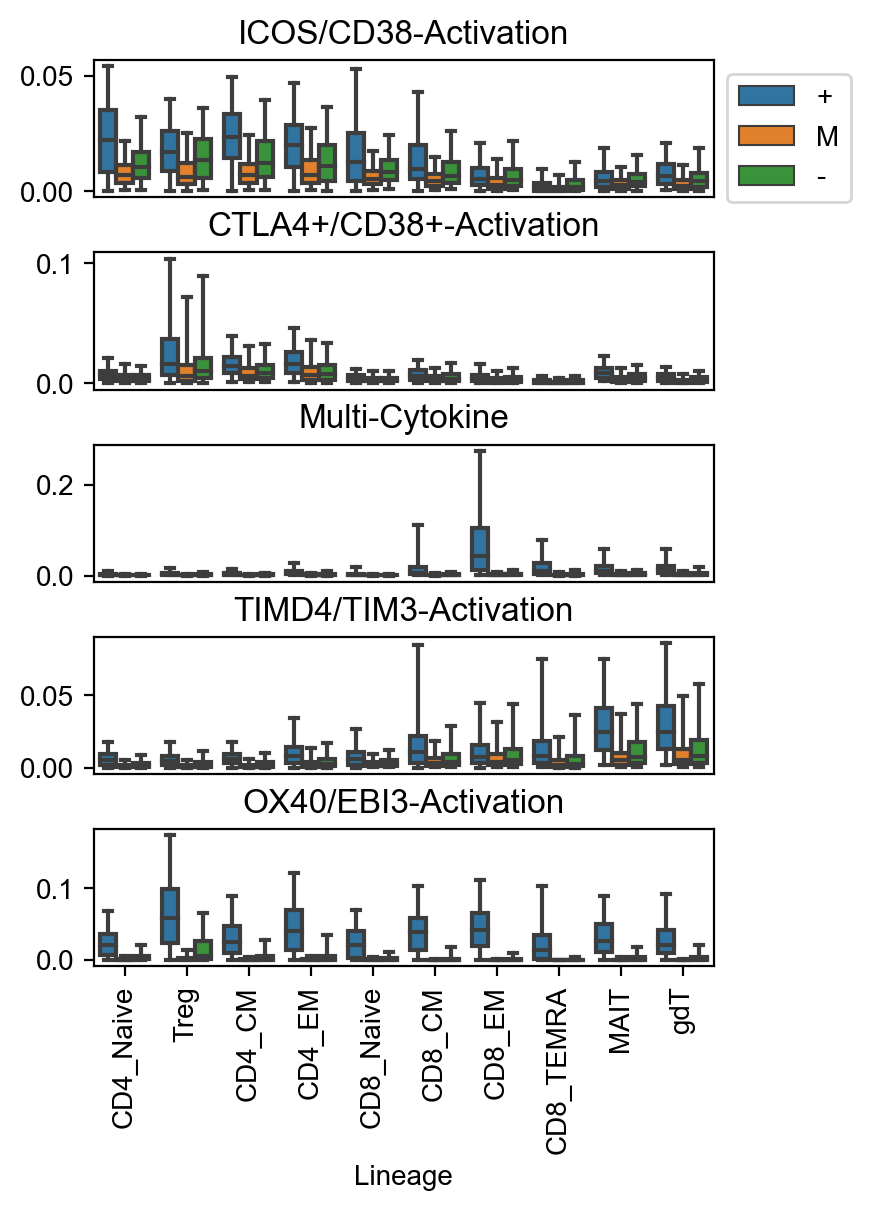

In [799]:
geps = ['ICOS/CD38-Activation', 'CTLA4+/CD38+-Activation', 'Multi-Cytokine', 'TIMD4/TIM3-Activation', 'OX40/EBI3-Activation']

(fig,axes) = plt.subplots(len(geps),1, figsize=(4,6), dpi=200, gridspec_kw={'hspace':.4})
for i,g in enumerate(geps):
    
    ax = sns.boxplot(x='lineage', y=g, hue='Reclassified', whis=[5, 95],
            data=rf_usage_norm_annot.rename(columns=name_dict), order=linorder, ax=axes[i], showfliers=False)
    if i != 0:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1,1))
        #ax.set_yticks([0, 0.03])

    
    
    if (i == len(axes) - 1):
        ax.set_xticklabels(linorder, rotation=90)
        ax.set_xlabel('Lineage')
    else:
        ax.set_xticks([])
        ax.set_xlabel('')
        
    axes[i].set_title(g)
    axes[i].set_ylabel('')

In [754]:
persamp = rf_usage_norm_annot.rename(columns=name_dict).groupby(['Biobank_ID', 'Reclassified', 'lineage']).mean().reset_index()

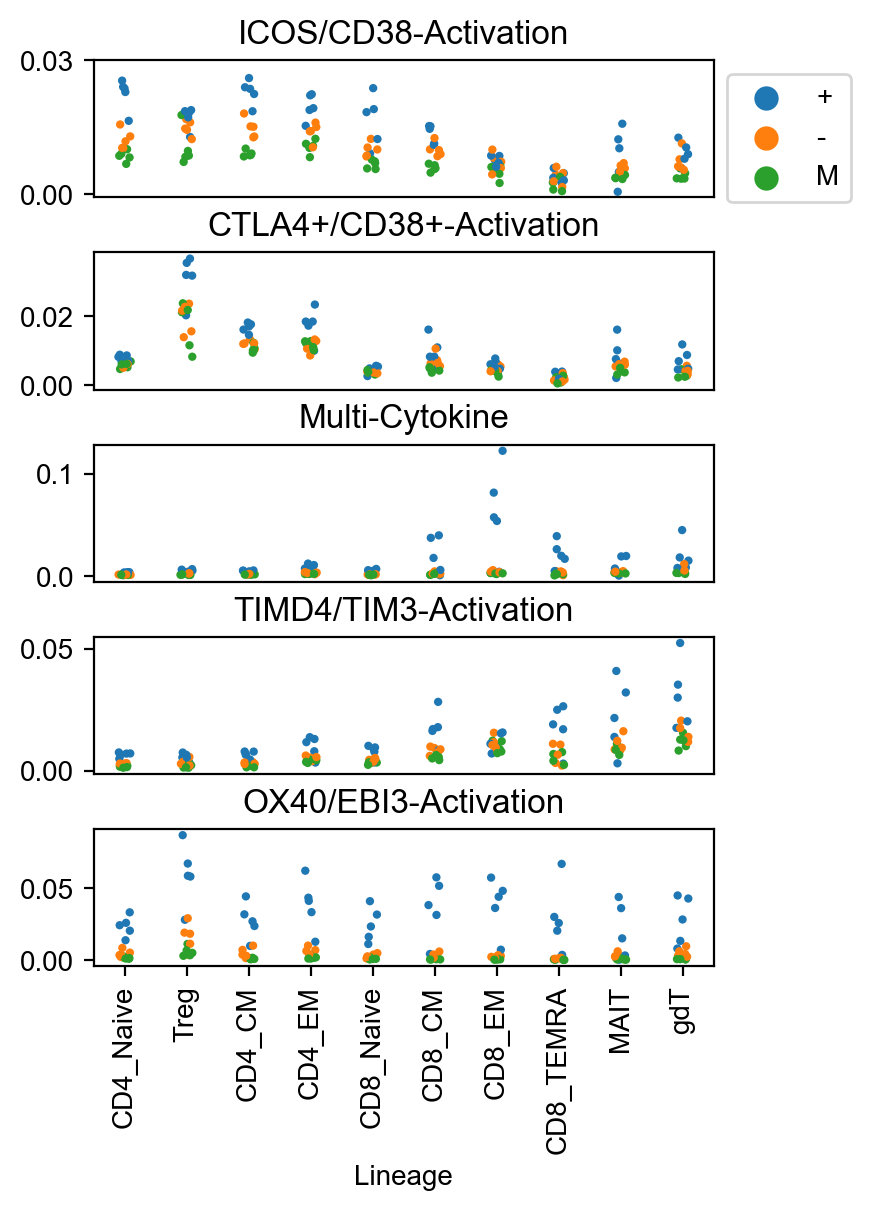

In [755]:
geps = ['ICOS/CD38-Activation', 'CTLA4+/CD38+-Activation', 'Multi-Cytokine', 'TIMD4/TIM3-Activation', 'OX40/EBI3-Activation']

(fig,axes) = plt.subplots(len(geps),1, figsize=(4,6), dpi=200, gridspec_kw={'hspace':.4})
for i,g in enumerate(geps):
    
    ax = sns.stripplot(x='lineage', y=g, hue='Reclassified',
            data=persamp, order=linorder, ax=axes[i], size=3)
    if i != 0:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_yticks([0, 0.03])

    
    
    if (i == len(axes) - 1):
        ax.set_xticklabels(linorder, rotation=90)
        ax.set_xlabel('Lineage')
    else:
        ax.set_xticks([])
        ax.set_xlabel('')
        
    axes[i].set_title(g)
    axes[i].set_ylabel('')
    
    

In [773]:
persamp = rf_usage_norm_annot.rename(columns=name_dict).groupby(['Biobank_ID', 'Sort_Status', 'lineage']).mean().reset_index()

In [767]:
from scipy.stats import ranksums
ranksumres = []
for lin, lindat in persamp.groupby('lineage'):
    for gep in lindat.columns[3:]:
        (H,P) = ranksums(lindat.loc[lindat['Sort_Status']=='+', gep], lindat.loc[lindat['Sort_Status']!='+', gep])
        ranksumres.append([lin, H, P])



SystemExit: -1

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


[Text(0, 0, 'CD4_Naive'),
 Text(1, 0, 'Treg'),
 Text(2, 0, 'CD4_CM'),
 Text(3, 0, 'CD4_EM'),
 Text(4, 0, 'CD8_Naive'),
 Text(5, 0, 'CD8_CM'),
 Text(6, 0, 'CD8_EM'),
 Text(7, 0, 'CD8_TEMRA'),
 Text(8, 0, 'MAIT'),
 Text(9, 0, 'gdT')]

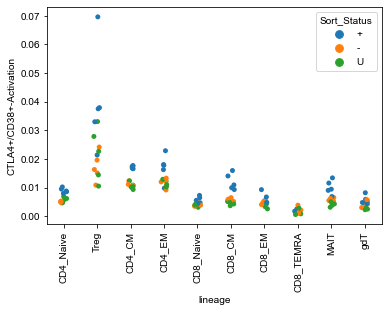

In [710]:
ax = sns.stripplot(x='lineage', y='CTLA4+/CD38+-Activation', hue='Sort_Status',
            data=persamp, order=linorder)
#ax.set_ylim([0, .15])
ax.set_xticklabels(linorder, rotation=90)

[Text(0, 0, 'CD4_Naive'),
 Text(1, 0, 'Treg'),
 Text(2, 0, 'CD4_CM'),
 Text(3, 0, 'CD4_EM'),
 Text(4, 0, 'CD8_Naive'),
 Text(5, 0, 'CD8_CM'),
 Text(6, 0, 'CD8_EM'),
 Text(7, 0, 'CD8_TEMRA'),
 Text(8, 0, 'MAIT'),
 Text(9, 0, 'gdT')]

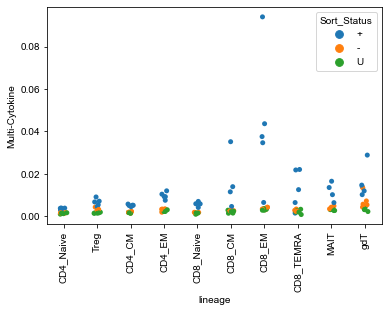

In [711]:
ax = sns.stripplot(x='lineage', y='Multi-Cytokine', hue='Sort_Status',
            data=persamp, order=linorder)
#ax.set_ylim([0, .15])
ax.set_xticklabels(linorder, rotation=90)

[Text(0, 0, 'CD4_Naive'),
 Text(1, 0, 'Treg'),
 Text(2, 0, 'CD4_CM'),
 Text(3, 0, 'CD4_EM'),
 Text(4, 0, 'CD8_Naive'),
 Text(5, 0, 'CD8_CM'),
 Text(6, 0, 'CD8_EM'),
 Text(7, 0, 'CD8_TEMRA'),
 Text(8, 0, 'MAIT'),
 Text(9, 0, 'gdT')]

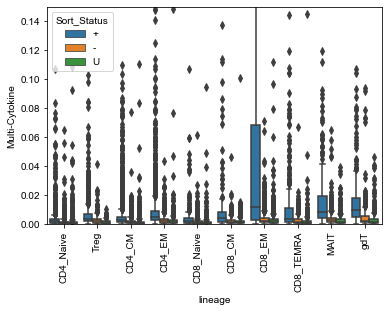

In [727]:
ax = sns.boxplot(x='lineage', y='Multi-Cytokine', hue='Sort_Status',
            data=rf_usage_norm_annot.rename(columns=name_dict), order=linorder)
ax.set_ylim([0, .15])
ax.set_xticklabels(linorder, rotation=90)

[Text(0, 0, 'CD4_Naive'),
 Text(1, 0, 'Treg'),
 Text(2, 0, 'CD4_CM'),
 Text(3, 0, 'CD4_EM'),
 Text(4, 0, 'CD8_Naive'),
 Text(5, 0, 'CD8_CM'),
 Text(6, 0, 'CD8_EM'),
 Text(7, 0, 'CD8_TEMRA'),
 Text(8, 0, 'MAIT'),
 Text(9, 0, 'gdT')]

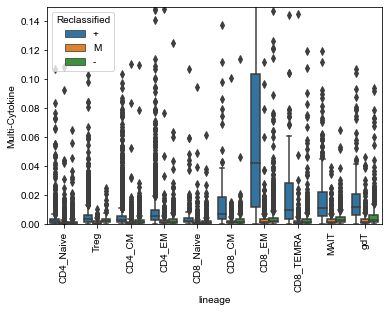

In [726]:
ax = sns.boxplot(x='lineage', y='Multi-Cytokine', hue='Reclassified',
            data=rf_usage_norm_annot.rename(columns=name_dict), order=linorder)
ax.set_ylim([0, .15])
ax.set_xticklabels(linorder, rotation=90)

In [699]:
rf_usage_norm_annot.rename(columns=name_dict).columns

Index(['CellCycle-G2M', 'Translation', 'HLA', 'ISG', 'Mito', 'Doublet-RBC',
       'gdT-Blood', 'CellCycle-S', 'Cytotoxic', 'Doublet-Platelet',
       'Early-Activation', 'CCR10-Migration', 'MAIT', 'CellCycle-Late-S',
       'Cytoskeleton', 'HeatShock', 'Multi-Cytokine', 'NK-like',
       'Doublet-Myeloid', 'Metallothionein', 'CD4-CM', 'IEG', 'CD8-EM', 'IEG2',
       'CD4-Naive', 'Treg', 'Th17', 'MALAT1', 'CD8-Naive', 'RGCC/MYADM',
       'TIMD4/TIM3-Activation', 'Doublet-Plasmablast', 'BCL2-Survival',
       'IL10/IL19-Secretion', 'Th2-2', 'Th2-1', 'ICOS/CD38-Activation',
       'Doublet-Bcell', 'CD4-EM', 'CTLA4+/CD38+-Activation', 'CD8-Trm-Like',
       'Th17-2', 'Tfh-2', 'OX40/EBI3-Activation', 'TXNIP/H1FX', 'YPEL5/JUNB',
       'Doublet-Fibroblast', 'SOX4/TOX2', 'CD40LG/TXNIP', 'Tph', 'Exhaustion',
       'Tfh-1', 'Biobank_ID', 'Sort_Status', 'lineage'],
      dtype='object')

In [ ]:
rf_usage_norm_annot.co

In [274]:
allres.loc[allres['lineage'] == 'CD4_Naive', :].sort_values(by='Pos_Q').head(50)

GEP    Stim_P         Pos_P  \
0                                                                          
Metallothionein                  Metallothionein  0.001049  2.240389e-08   
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  0.913343  1.859574e-08   
Cytoskeleton                        Cytoskeleton  0.463068  2.210860e-07   
HeatShock                              HeatShock  0.122797  4.739959e-07   
CD8-Naive                              CD8-Naive  0.378275  1.435302e-06   
ICOS/CD38-Activation        ICOS/CD38-Activation  0.021379  2.353685e-06   
Th17                                        Th17  0.034258  2.860341e-06   
CellCycle-S                          CellCycle-S  0.463260  4.466022e-06   
ISG                                          ISG  0.000006  6.830250e-06   
Early-Activation                Early-Activation  0.683435  1.739532e-05   
CellCycle-G2M                      CellCycle-G2M  0.163277  1.833470e-05   
CD4-EM                                    CD4-EM  0.011687  1.892780e-05   
OX40/EBI3-Activation        OX40/EBI3-Activation  0.702269  4.034254e-05   
Multi-Cytokine                    Multi-Cytokine  0.686638  4.601055e-05   
CD4-Naive                              CD4-Naive  0.245033  7.521818e-05   
Exhaustion                            Exhaustion  0.099204  8.478732e-05   
CCR10-Migration                  CCR10-Migration  0.175468  5.294572e-04   
Doublet-Fibroblast            Doublet-Fibroblast  0.982400  7.705612e-04   
RGCC/MYADM                            RGCC/MYADM  0.125620  7.538222e-04   
Th2-2                                      Th2-2  0.921555  9.472440e-04   
Treg                                        Treg  0.883989  1.007067e-03   
CD40LG/TXNIP                        CD40LG/TXNIP  0.404000  1.382060e-03   
CellCycle-Late-S                CellCycle-Late-S  0.074009  1.722593e-03   
Tfh-2                                      Tfh-2  0.644554  2.760107e-03   
BCL2-Survival                      BCL2-Survival  0.914828  2.652087e-03   
Tph                                          Tph  0.567998  3.062078e-03   
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  0.136727  4.002041e-03   
Th17-2                                    Th17-2  0.345015  4.417360e-03   
HLA                                          HLA  0.297867  3.104657e-02   
CD8-Trm-Like                        CD8-Trm-Like  0.675082  3.080938e-02   
IL10/IL19-Secretion          IL10/IL19-Secretion  0.004124  4.545141e-02   
Doublet-Platelet                Doublet-Platelet  0.947075  5.078684e-02   
TXNIP/H1FX                            TXNIP/H1FX  0.698097  6.647565e-02   
CD8-EM                                    CD8-EM  0.987899  7.313735e-02   
SOX4/TOX2                              SOX4/TOX2  0.856891  9.076174e-02   
Doublet-Bcell                      Doublet-Bcell  0.351993  9.372156e-02   
IEG2                                        IEG2  0.158060  1.068819e-01   
MALAT1                                    MALAT1  0.755385  1.392526e-01   
IEG                                          IEG  0.030895  2.116563e-01   
Doublet-RBC                          Doublet-RBC  0.150574  2.276357e-01   
Translation                          Translation  0.616979  2.612217e-01   
gdT-Blood                              gdT-Blood  0.947530  2.750128e-01   
Cytotoxic                              Cytotoxic  0.715465  3.188751e-01   
CD4-CM                                    CD4-CM  0.159526  3.422853e-01   
MAIT                                        MAIT  0.695190  5.692531e-01   
NK-like                                  NK-like  0.903356  6.890028e-01   
Doublet-Myeloid                  Doublet-Myeloid  0.994705  7.013620e-01   
Doublet-Plasmablast          Doublet-Plasmablast  0.041680  7.259860e-01   
YPEL5/JUNB                            YPEL5/JUNB  0.296892  8.371561e-01   
Mito                                        Mito  0.948639  8.272127e-01   

                           Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  \
0          

In [272]:
allres.loc[allres['lineage'] == 'CD4_EM', :].sort_values(by='Pos_Q').head(20)

GEP        Stim_P         Pos_P  \
0                                                                              
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  8.773602e-01  2.612042e-10   
CellCycle-G2M                      CellCycle-G2M  1.778271e-02  2.034190e-09   
Cytoskeleton                        Cytoskeleton  3.699081e-01  9.229403e-09   
Metallothionein                  Metallothionein  4.188750e-03  1.130481e-08   
HeatShock                              HeatShock  1.112730e-01  1.186870e-07   
CellCycle-S                          CellCycle-S  3.418208e-01  3.437198e-07   
CD8-Naive                              CD8-Naive  2.033595e-01  5.836375e-07   
ICOS/CD38-Activation        ICOS/CD38-Activation  1.790936e-02  1.991189e-06   
Th17                                        Th17  1.238991e-01  2.015877e-06   
Early-Activation                Early-Activation  6.536277e-01  2.615263e-06   
ISG                                          ISG  4.377065e-07  1.161506e-05   
CD4-Naive                              CD4-Naive  2.382805e-02  2.002035e-05   
OX40/EBI3-Activation        OX40/EBI3-Activation  6.351249e-01  2.044353e-05   
RGCC/MYADM                            RGCC/MYADM  7.440665e-02  5.649744e-05   
Exhaustion                            Exhaustion  1.302247e-01  1.175400e-04   
Multi-Cytokine                    Multi-Cytokine  7.329092e-01  1.342958e-04   
CD4-EM                                    CD4-EM  7.653545e-02  1.534202e-04   
CCR10-Migration                  CCR10-Migration  2.859247e-01  1.728431e-04   
Th2-2                                      Th2-2  6.449644e-01  1.908986e-04   
CellCycle-Late-S                CellCycle-Late-S  5.179851e-02  1.935877e-04   

                           Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  \
0                                                                               
CTLA4+/CD38+-Activation -0.000070  0.008375  1.358262e-08  0.912120  7.867016   
CellCycle-G2M            0.000289  0.001672  5.288895e-08  0.164457  7.276635   
Cytoskeleton             0.001139  0.016993  1.469625e-07  0.782439  6.832793   
Metallothionein          0.000940  0.003643  1.469625e-07  0.108907  6.832793   
HeatShock                0.001425  0.009173  1.234345e-06  0.398334  5.908564   
CellCycle-S              0.001126  0.011423  2.978905e-06  0.772812  5.525943   
CD8-Naive               -0.008324 -0.059123  4.335593e-06  0.528735  5.362951   
ICOS/CD38-Activation     0.002745  0.008521  1.164729e-05  0.164457  4.933775   
Th17                    -0.002123  0.010901  1.164729e-05  0.398334  4.933775   
Early-Activation         0.002581  0.046484  1.359937e-05  0.901425  4.866481   
ISG                      0.023610  0.017202  5.490755e-05  0.000023  4.260368   
CD4-Naive               -0.026155 -0.068413  8.177413e-05  0.177008  4.087384   
OX40/EBI3-Activation     0.001936  0.026841  8.177413e-05  0.901425  4.087384   
RGCC/MYADM              -0.001587  0.004924  2.098476e-04  0.331654  3.678096   
Exhaustion               0.003344  0.011512  4.074721e-04  0.398334  3.389902   
Multi-Cytokine           0.000566  0.008929  4.364613e-04  0.910539  3.360054   
CD4-EM                  -0.005734 -0.016056  4.692854e-04  0.331654  3.328563   
CCR10-Migration         -0.001670  0.008005  4.993246e-04  0.675822  3.301617   
Th2-2                    0.000200  0.002240  5.033281e-04  0.901425  3.298149   
CellCycle-Late-S         0.000412  0.001009  5.033281e-04  0.299280  3.298149   

                        lineage  
0                                
CTLA4+/CD38+-Activation  CD4_EM  
CellCycle-G2M            CD4_EM  
Cytoskeleton             CD4_EM  
Metallothionein          CD4_EM  
HeatShock                CD4_EM  
CellCycle-S              CD4_EM  
CD8-Naive                CD4_EM  
ICOS/CD38-Activation     CD4_EM  
Th17                     CD4_EM  
Early-Activation         CD4_EM  
ISG                      CD4_EM  
CD4-Naive                CD4_EM  
OX40/EBI3-Activation     

## Repeat but excluding naives

In [200]:
ind = ~rf_usage_norm_annot['lineage'].isin(['CD4_Naive', 'CD8_Naive'])
totest = rf_usage_norm_annot.loc[ind, :]
totest = totest.rename(columns=name_dict)

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
predicter.index = average_usage.index
predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
predicter_dummy['Intercept'] = 1
summary = []

for g in average_usage.columns:
    mod = sm.OLS(average_usage[g], predicter_dummy)
    res = mod.fit()
    summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
summary = pd.DataFrame(summary)
summary.index = summary[0]
summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)


summary.head()

GEP    Stim_P     Pos_P    Stim_B     Pos_B  \
0                                                                      
CellCycle-G2M  CellCycle-G2M  0.092834  0.000039  0.000380  0.001313   
Translation      Translation  0.838150  0.526476  0.001847 -0.005772   
HLA                      HLA  0.251308  0.116955  0.001734  0.002431   
ISG                      ISG  0.000016  0.000003  0.018747  0.022277   
Mito                    Mito  0.942379  0.694641 -0.000603  0.003286   

                  Pos_Q    Stim_Q  Pos_logQ  
0                                            
CellCycle-G2M  0.000192  0.358519  3.715719  
Translation    0.595147  0.942379  0.225376  
HLA            0.164369  0.622286  0.784180  
ISG            0.000024  0.000822  4.616547  
Mito           0.714932  0.942379  0.145735

In [201]:
pos = summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)]
stim = summary.index[(summary['Stim_Q']<.05) & (summary['Stim_B']>0)]


len(pos), len(stim)

(23, 1)

"\n\nax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)\nax.set_ylim(-0.05, ylim[1]+.5)\n\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))\n"

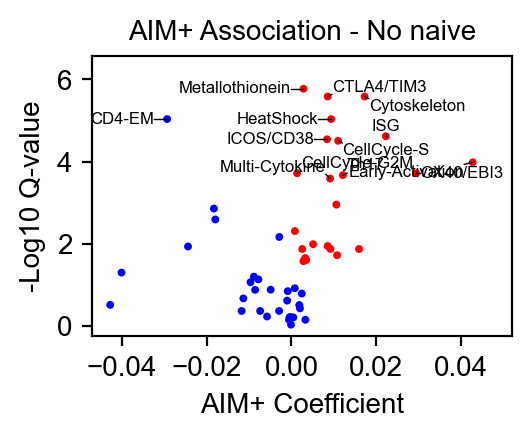

In [206]:
(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.2, 'top':0.9})
ind = (summary['Pos_B']>0) & (summary['Pos_Q']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')

xval = 'Pos_B'
yval = 'Pos_logQ'

ax.scatter(summary.loc[ind, xval], summary.loc[ind, yval], s=8, color='r', edgecolor='None')
ax.scatter(summary.loc[~ind, xval], summary.loc[~ind, yval], s=8, color='b', edgecolor='None')
ax.set_ylabel('-Log10 Q-value', fontsize=10)
ax.set_xlabel('AIM+ Coefficient', fontsize=10)
ax.set_title('AIM+ Association - No naive', fontsize=10)

fs = 6



toplot = summary.index[(summary['Pos_logQ']>3.5)]

for i,g in enumerate(toplot):
    lab = summary.at[g, 'GEP']
    if lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'TNFRSF18+-Treg': lab = 'TNFRSF18+'
    elif lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'ICOS/CD38-Activation': lab = 'ICOS/CD38'
    elif lab == 'IL10/IL19-Secretion': lab = 'IL10/IL19'
    elif lab == 'TIMD4/TIM3-Activation': lab = 'TIMD4/TIM3'
    elif lab == 'CTLA4+/CD38+-Activation': lab='CTLA4/TIM3'

    
    if g in ['Metallothionein', 'HeatShock', 'ICOS/CD38-Activation', 'CD4-EM']: deltax = -0.003; deltay =0; ha='right'; va='center' ## Left
    elif g in ['CTLA4+/CD38+-Activation', 'CellCycle-G2M', 'Th17']: deltax = 0.001; deltay = .05; ha='left'; va='bottom' ## Upper-right
    elif g in ['CellCycle-S', 'Cytoskeleton']: deltax = 0.001; deltay = -.05; ha='left'; va='top' ## Lower-right
    elif g in ['Early-Activation']: deltax = -0.002; deltay =-0.05; ha='right'; va='top' ## Lower-Left
    elif g in ['ISG']: deltax = 0; deltay =0.05; ha='center'; va='bottom' ## Above
    elif g in ['Multi-Cytokine']: deltax = -0.001; deltay =0.1; ha='right'; va='bottom' ## Upper-Left
    else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

    if g not in ['Exhaustion', 'RGCC/MYADM']:
        ax.text(summary.at[g, xval]+deltax, summary.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([summary.at[g, xval], summary.at[g, xval]+deltax], [summary.at[g, yval], summary.at[g, yval]+deltay], color='k', lw=.5)
        


ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.5)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1]+.005)
'''

ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)
ax.set_ylim(-0.05, ylim[1]+.5)

#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))
#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))
'''

## Repeat but excluding non CD4s

In [218]:
ind = ~rf_usage_norm_annot['lineage'].isin(['CD8_CM', 'CD8_EM', 'CD8_Naive', 'gdT', 'CD8_TEMRA', 'DP', 'DN', 'MAIT'])
totest = rf_usage_norm_annot.loc[ind, :]
totest = totest.rename(columns=name_dict)

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
predicter.index = average_usage.index
predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
predicter_dummy['Intercept'] = 1
summary = []

for g in average_usage.columns:
    mod = sm.OLS(average_usage[g], predicter_dummy)
    res = mod.fit()
    summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
summary = pd.DataFrame(summary)
summary.index = summary[0]
summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)


summary.head()

GEP    Stim_P     Pos_P    Stim_B     Pos_B  \
0                                                                      
CellCycle-G2M  CellCycle-G2M  0.129192  0.000003  0.000305  0.001523   
Translation      Translation  0.589791  0.017900  0.005218 -0.025820   
HLA                      HLA  0.048696  0.000366  0.001521  0.003398   
ISG                      ISG  0.000003  0.000356  0.029623  0.017874   
Mito                    Mito  0.591456  0.302006 -0.004347  0.008503   

                  Pos_Q    Stim_Q  Pos_logQ  
0                                            
CellCycle-G2M  0.000014  0.353578  4.858026  
Translation    0.027377  0.788608  1.562620  
HLA            0.000866  0.229926  3.062376  
ISG            0.000866  0.000162  3.062376  
Mito           0.348985  0.788608  0.457193

In [219]:
pos = summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)]
stim = summary.index[(summary['Stim_Q']<.05) & (summary['Stim_B']>0)]


len(pos), len(stim), stim

(24,
 3,
 Index(['ISG', 'Metallothionein', 'ICOS/CD38-Activation'], dtype='object', name=0))

"\n\nax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)\nax.set_ylim(-0.05, ylim[1]+.5)\n\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))\n"

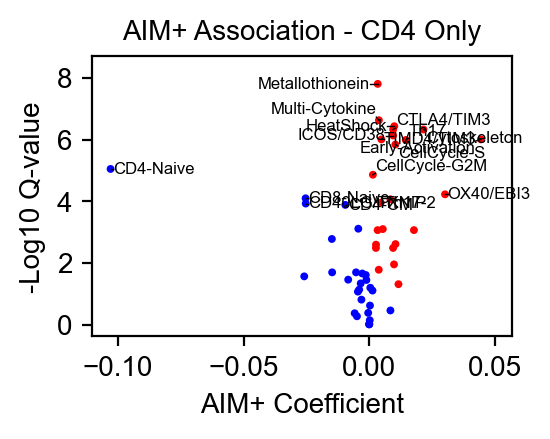

In [220]:
(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.2, 'top':0.9})
ind = (summary['Pos_B']>0) & (summary['Pos_Q']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')

xval = 'Pos_B'
yval = 'Pos_logQ'

ax.scatter(summary.loc[ind, xval], summary.loc[ind, yval], s=8, color='r', edgecolor='None')
ax.scatter(summary.loc[~ind, xval], summary.loc[~ind, yval], s=8, color='b', edgecolor='None')
ax.set_ylabel('-Log10 Q-value', fontsize=10)
ax.set_xlabel('AIM+ Coefficient', fontsize=10)
ax.set_title('AIM+ Association - CD4 Only', fontsize=10)

fs = 6



toplot = summary.index[(summary['Pos_logQ']>3.5)]

for i,g in enumerate(toplot):
    lab = summary.at[g, 'GEP']
    if lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'TNFRSF18+-Treg': lab = 'TNFRSF18+'
    elif lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'ICOS/CD38-Activation': lab = 'ICOS/CD38'
    elif lab == 'IL10/IL19-Secretion': lab = 'IL10/IL19'
    elif lab == 'TIMD4/TIM3-Activation': lab = 'TIMD4/TIM3'
    elif lab == 'CTLA4+/CD38+-Activation': lab='CTLA4/TIM3'

    
    if g in ['Metallothionein', 'HeatShock', 'ICOS/CD38-Activation', 'CD4-EM']: deltax = -0.003; deltay =0; ha='right'; va='center' ## Left
    elif g in ['CTLA4+/CD38+-Activation', 'CellCycle-G2M', 'Th17']: deltax = 0.001; deltay = .05; ha='left'; va='bottom' ## Upper-right
    elif g in ['CellCycle-S', 'Cytoskeleton']: deltax = 0.001; deltay = -.05; ha='left'; va='top' ## Lower-right
    elif g in ['Early-Activation']: deltax = -0.002; deltay =-0.05; ha='right'; va='top' ## Lower-Left
    elif g in ['ISG']: deltax = 0; deltay =0.05; ha='center'; va='bottom' ## Above
    elif g in ['Multi-Cytokine']: deltax = -0.001; deltay =0.1; ha='right'; va='bottom' ## Upper-Left
    else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

    if g not in ['Exhaustion', 'RGCC/MYADM']:
        ax.text(summary.at[g, xval]+deltax, summary.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([summary.at[g, xval], summary.at[g, xval]+deltax], [summary.at[g, yval], summary.at[g, yval]+deltay], color='k', lw=.5)
        


ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.5)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1]+.005)
'''

ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)
ax.set_ylim(-0.05, ylim[1]+.5)

#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))
#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))
'''

In [221]:
summary.loc[pos, :]

GEP    Stim_P         Pos_P  \
0                                                                          
CellCycle-G2M                      CellCycle-G2M  0.129192  3.200016e-06   
HLA                                          HLA  0.048696  3.664743e-04   
ISG                                          ISG  0.000003  3.559070e-04   
CellCycle-S                          CellCycle-S  0.305641  2.783492e-07   
Early-Activation                Early-Activation  0.414149  1.523924e-07   
CCR10-Migration                  CCR10-Migration  0.171795  1.133832e-03   
MAIT                                        MAIT  0.826478  9.308347e-03   
Cytoskeleton                        Cytoskeleton  0.459584  4.541392e-08   
HeatShock                              HeatShock  0.075855  2.130915e-08   
Multi-Cytokine                    Multi-Cytokine  0.206079  9.100317e-09   
NK-like                                  NK-like  0.123827  1.232495e-03   
Metallothionein                  Metallothionein  0.000115  3.015602e-10   
Treg                                        Treg  0.551289  6.027191e-03   
Th17                                        Th17  0.004607  1.791949e-07   
RGCC/MYADM                            RGCC/MYADM  0.017095  3.081200e-04   
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  0.142967  1.445666e-07   
BCL2-Survival                      BCL2-Survival  0.902343  3.588218e-02   
Th2-2                                      Th2-2  0.833104  1.646948e-03   
ICOS/CD38-Activation        ICOS/CD38-Activation  0.002300  8.564596e-08   
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  0.639335  4.529159e-08   
Th17-2                                    Th17-2  0.414187  3.456748e-05   
OX40/EBI3-Activation        OX40/EBI3-Activation  0.563985  1.493432e-05   
Tph                                          Tph  0.671631  1.705419e-03   
Exhaustion                            Exhaustion  0.091125  2.500281e-05   

                           Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  
0                                                                              
CellCycle-G2M            0.000305  0.001523  1.386674e-05  0.353578  4.858026  
HLA                      0.001521  0.003398  8.662120e-04  0.229926  3.062376  
ISG                      0.029623  0.017874  8.662120e-04  0.000162  3.062376  
CellCycle-S              0.001095  0.010471  1.447416e-06  0.573911  5.839407  
Early-Activation         0.003486  0.044569  9.905504e-07  0.684028  6.004123  
CCR10-Migration         -0.003602  0.010525  2.456635e-03  0.388406  2.609659  
MAIT                    -0.000280  0.003865  1.669083e-02  0.902529  1.777522  
Cytoskeleton             0.001372  0.021668  4.723048e-07  0.684028  6.325778  
HeatShock                0.001511  0.010042  3.693586e-07  0.281749  6.432552  
Multi-Cytokine           0.000376  0.003918  2.366082e-07  0.428644  6.625970  
NK-like                  0.001088  0.002762  2.563590e-03  0.353578  2.591151  
Metallothionein          0.001034  0.003453  1.568113e-08  0.002987  7.804623  
Treg                     0.001831  0.009939  1.119336e-02  0.788608  1.951040  
Th17                    -0.004760  0.014609  1.035348e-06  0.059889  5.984913  
RGCC/MYADM              -0.003027  0.005475  8.011121e-04  0.111117  3.096307  
TIMD4/TIM3-Activation    0.000706  0.004895  9.905504e-07  0.362580  6.004123  
BCL2-Survival            0.000621  0.011708  4.910193e-02  0.938436  1.308901  
Th2-2                   -0.000146  0.002730  3.284511e-03  0.902529  2.483529  
ICOS/CD38-Activation     0.003234  0.009569  7.422650e-07  0.039867  6.129441  
CTLA4+/CD38+-Activation -0.000382  0.009590  4.723048e-07  0.816610  6.325778  
Th17-2                  -0.000611  0.004617  1.123443e-04  0.684028  3.949449  
OX40/EBI3-Activation     0.002575  0.030254  5.973727e-05  0.788608  4.223755  
Tph                      0.001034  0.009562  3.284511e-03  0.816610  2.483529  
Exhaustion               0.002370  0.008528  8.667642e-05  0.296156 

## Repeat but CD4 memory only

In [222]:
ind = ~rf_usage_norm_annot['lineage'].isin(['CD8_CM', 'CD8_EM', 'CD8_Naive', 'gdT', 'CD8_TEMRA', 'DP', 'DN', 'CD4_Naive', 'MAIT'])
totest = rf_usage_norm_annot.loc[ind, :]
totest = totest.rename(columns=name_dict)

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
predicter.index = average_usage.index
predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
predicter_dummy['Intercept'] = 1
summary = []

for g in average_usage.columns:
    mod = sm.OLS(average_usage[g], predicter_dummy)
    res = mod.fit()
    summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
summary = pd.DataFrame(summary)
summary.index = summary[0]
summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)


summary.head()

GEP    Stim_P     Pos_P    Stim_B     Pos_B  \
0                                                                      
CellCycle-G2M  CellCycle-G2M  0.286831  0.008522  0.000361  0.001018   
Translation      Translation  0.814916  0.057591  0.001930 -0.016932   
HLA                      HLA  0.137560  0.015089  0.001586  0.002824   
ISG                      ISG  0.000027  0.000047  0.026037  0.024546   
Mito                    Mito  0.770109  0.354796 -0.002099  0.006757   

                  Pos_Q    Stim_Q  Pos_logQ  
0                                            
CellCycle-G2M  0.017224  0.535067  1.763877  
Translation    0.093585  0.931596  1.028795  
HLA            0.029060  0.397395  1.536708  
ISG            0.000151  0.000693  3.820279  
Mito           0.419304  0.925380  0.377471

In [223]:
pos = summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)]
stim = summary.index[(summary['Stim_Q']<.05) & (summary['Stim_B']>0)]


len(pos), len(stim), stim

(19,
 3,
 Index(['ISG', 'Metallothionein', 'ICOS/CD38-Activation'], dtype='object', name=0))

"\n\nax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)\nax.set_ylim(-0.05, ylim[1]+.5)\n\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))\n"

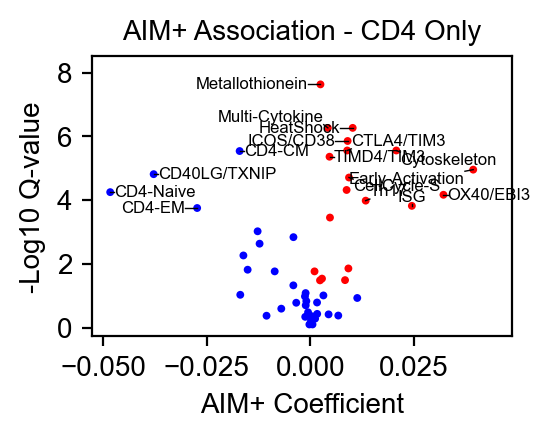

In [224]:
(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.2, 'top':0.9})
ind = (summary['Pos_B']>0) & (summary['Pos_Q']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')

xval = 'Pos_B'
yval = 'Pos_logQ'

ax.scatter(summary.loc[ind, xval], summary.loc[ind, yval], s=8, color='r', edgecolor='None')
ax.scatter(summary.loc[~ind, xval], summary.loc[~ind, yval], s=8, color='b', edgecolor='None')
ax.set_ylabel('-Log10 Q-value', fontsize=10)
ax.set_xlabel('AIM+ Coefficient', fontsize=10)
ax.set_title('AIM+ Association - CD4 Only', fontsize=10)

fs = 6



toplot = summary.index[(summary['Pos_logQ']>3.5)]

for i,g in enumerate(toplot):
    lab = summary.at[g, 'GEP']
    if lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'TNFRSF18+-Treg': lab = 'TNFRSF18+'
    elif lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'ICOS/CD38-Activation': lab = 'ICOS/CD38'
    elif lab == 'IL10/IL19-Secretion': lab = 'IL10/IL19'
    elif lab == 'TIMD4/TIM3-Activation': lab = 'TIMD4/TIM3'
    elif lab == 'CTLA4+/CD38+-Activation': lab='CTLA4/TIM3'

    
    if g in ['Metallothionein', 'HeatShock', 'ICOS/CD38-Activation', 'CD4-EM']: deltax = -0.003; deltay =0; ha='right'; va='center' ## Left
    elif g in ['CTLA4+/CD38+-Activation', 'CellCycle-G2M', 'Th17']: deltax = 0.001; deltay = .05; ha='left'; va='bottom' ## Upper-right
    elif g in ['CellCycle-S', 'Cytoskeleton']: deltax = 0.001; deltay = -.05; ha='left'; va='top' ## Lower-right
    elif g in ['Early-Activation']: deltax = -0.002; deltay =-0.05; ha='right'; va='top' ## Lower-Left
    elif g in ['ISG']: deltax = 0; deltay =0.05; ha='center'; va='bottom' ## Above
    elif g in ['Multi-Cytokine']: deltax = -0.001; deltay =0.1; ha='right'; va='bottom' ## Upper-Left
    else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

    if g not in ['Exhaustion', 'RGCC/MYADM']:
        ax.text(summary.at[g, xval]+deltax, summary.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([summary.at[g, xval], summary.at[g, xval]+deltax], [summary.at[g, yval], summary.at[g, yval]+deltay], color='k', lw=.5)
        


ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.5)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1]+.005)
'''

ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)
ax.set_ylim(-0.05, ylim[1]+.5)

#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))
#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))
'''

In [225]:
totest['lineage'].value_counts()

CD4_CM       9486
CD4_EM       4428
Treg         2073
CD4_TEMRA     151
Name: lineage, dtype: int64

In [226]:
summary.loc[pos, :]

GEP    Stim_P         Pos_P  \
0                                                                          
CellCycle-G2M                      CellCycle-G2M  0.286831  8.522364e-03   
HLA                                          HLA  0.137560  1.508872e-02   
ISG                                          ISG  0.000027  4.654121e-05   
CellCycle-S                          CellCycle-S  0.389809  4.129630e-06   
Early-Activation                Early-Activation  0.394832  1.912280e-06   
CCR10-Migration                  CCR10-Migration  0.089143  1.746128e-02   
Cytoskeleton                        Cytoskeleton  0.446288  3.192907e-07   
HeatShock                              HeatShock  0.045672  3.114820e-08   
Multi-Cytokine                    Multi-Cytokine  0.178967  2.480726e-08   
Metallothionein                  Metallothionein  0.000022  4.477576e-10   
Th17                                        Th17  0.002312  2.994970e-05   
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  0.212939  6.678635e-07   
Th2-2                                      Th2-2  0.783014  1.838386e-02   
ICOS/CD38-Activation        ICOS/CD38-Activation  0.001582  1.071606e-07   
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  0.882502  2.856655e-07   
Th17-2                                    Th17-2  0.236743  1.220384e-04   
OX40/EBI3-Activation        OX40/EBI3-Activation  0.570156  1.828919e-05   
Tph                                          Tph  0.519591  6.164297e-03   
Exhaustion                            Exhaustion  0.073653  1.107868e-05   

                           Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  
0                                                                              
CellCycle-G2M            0.000361  0.001018  1.722356e-02  0.535067  1.763877  
HLA                      0.001586  0.002824  2.905976e-02  0.397395  1.536708  
ISG                      0.026037  0.024546  1.512589e-04  0.000693  3.820279  
CellCycle-S              0.001053  0.009353  1.952189e-05  0.679694  4.709478  
Early-Activation         0.004069  0.039379  1.104873e-05  0.679694  4.956688  
CCR10-Migration         -0.005636  0.008394  3.242809e-02  0.297198  1.489079  
Cytoskeleton             0.001619  0.020782  2.767186e-06  0.684329  5.557962  
HeatShock                0.001830  0.010245  5.399022e-07  0.215611  6.267685  
Multi-Cytokine           0.000475  0.004238  5.399022e-07  0.489804  6.267685  
Metallothionein          0.000908  0.002451  2.328340e-08  0.000693  7.632954  
Th17                    -0.007944  0.013386  1.038256e-04  0.030058  3.983695  
TIMD4/TIM3-Activation    0.000647  0.004643  4.341112e-06  0.513704  5.362399  
Th2-2                   -0.000242  0.002343  3.296416e-02  0.925380  1.481958  
ICOS/CD38-Activation     0.003277  0.009016  1.393087e-06  0.027423  5.856022  
CTLA4+/CD38+-Activation -0.000132  0.008917  2.767186e-06  0.936533  5.557962  
Th17-2                  -0.001062  0.004750  3.525553e-04  0.513704  3.452773  
OX40/EBI3-Activation     0.002752  0.032183  6.793128e-05  0.760208  4.167930  
Tph                      0.001842  0.009204  1.393667e-02  0.717676  1.855841  
Exhaustion               0.002392  0.008772  4.800762e-05  0.273570  4.318690

## Repeat but CD4 EM only

In [227]:
ind = rf_usage_norm_annot['lineage'].isin(['CD4_EM'])
totest = rf_usage_norm_annot.loc[ind, :]
totest = totest.rename(columns=name_dict)

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
predicter.index = average_usage.index
predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
predicter_dummy['Intercept'] = 1
summary = []

for g in average_usage.columns:
    mod = sm.OLS(average_usage[g], predicter_dummy)
    res = mod.fit()
    summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
summary = pd.DataFrame(summary)
summary.index = summary[0]
summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)


summary.head()

GEP    Stim_P     Pos_P    Stim_B     Pos_B  \
0                                                                      
CellCycle-G2M  CellCycle-G2M  0.594410  0.000179  0.000178  0.001736   
Translation      Translation  0.696271  0.174072  0.004048 -0.014628   
HLA                      HLA  0.297176  0.547734  0.001441  0.000818   
ISG                      ISG  0.000071  0.003144  0.022220  0.013821   
Mito                    Mito  0.753640  0.165334 -0.003635  0.016723   

                  Pos_Q    Stim_Q  Pos_logQ  
0                                            
CellCycle-G2M  0.000777  0.813404  3.109797  
Translation    0.244642  0.883075  0.611470  
HLA            0.619177  0.735865  0.208185  
ISG            0.010899  0.003668  1.962618  
Mito           0.244642  0.896687  0.611470

In [228]:
pos = summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)]
stim = summary.index[(summary['Stim_Q']<.05) & (summary['Stim_B']>0)]


len(pos), len(stim), stim

(17, 1, Index(['ISG'], dtype='object', name=0))

"\n\nax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)\nax.set_ylim(-0.05, ylim[1]+.5)\n\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))\n"

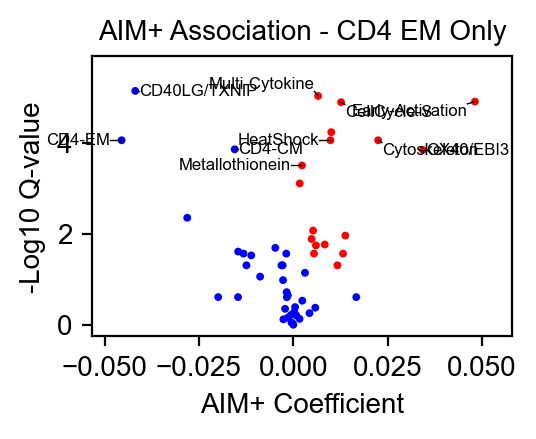

In [232]:
(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.2, 'top':0.9})
ind = (summary['Pos_B']>0) & (summary['Pos_Q']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')

xval = 'Pos_B'
yval = 'Pos_logQ'

ax.scatter(summary.loc[ind, xval], summary.loc[ind, yval], s=8, color='r', edgecolor='None')
ax.scatter(summary.loc[~ind, xval], summary.loc[~ind, yval], s=8, color='b', edgecolor='None')
ax.set_ylabel('-Log10 Q-value', fontsize=10)
ax.set_xlabel('AIM+ Coefficient', fontsize=10)
ax.set_title('AIM+ Association - CD4 EM Only', fontsize=10)

fs = 6



toplot = summary.index[(summary['Pos_logQ']>3.5)]

for i,g in enumerate(toplot):
    lab = summary.at[g, 'GEP']
    if lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'TNFRSF18+-Treg': lab = 'TNFRSF18+'
    elif lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'ICOS/CD38-Activation': lab = 'ICOS/CD38'
    elif lab == 'IL10/IL19-Secretion': lab = 'IL10/IL19'
    elif lab == 'TIMD4/TIM3-Activation': lab = 'TIMD4/TIM3'
    elif lab == 'CTLA4+/CD38+-Activation': lab='CTLA4/TIM3'

    
    if g in ['Metallothionein', 'HeatShock', 'ICOS/CD38-Activation', 'CD4-EM']: deltax = -0.003; deltay =0; ha='right'; va='center' ## Left
    elif g in ['CTLA4+/CD38+-Activation', 'CellCycle-G2M', 'Th17']: deltax = 0.001; deltay = .05; ha='left'; va='bottom' ## Upper-right
    elif g in ['CellCycle-S', 'Cytoskeleton']: deltax = 0.001; deltay = -.05; ha='left'; va='top' ## Lower-right
    elif g in ['Early-Activation']: deltax = -0.002; deltay =-0.05; ha='right'; va='top' ## Lower-Left
    elif g in ['ISG']: deltax = 0; deltay =0.05; ha='center'; va='bottom' ## Above
    elif g in ['Multi-Cytokine']: deltax = -0.001; deltay =0.1; ha='right'; va='bottom' ## Upper-Left
    else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

    if g not in ['Exhaustion', 'RGCC/MYADM']:
        ax.text(summary.at[g, xval]+deltax, summary.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([summary.at[g, xval], summary.at[g, xval]+deltax], [summary.at[g, yval], summary.at[g, yval]+deltay], color='k', lw=.5)
        


ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.5)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1]+.005)
'''

ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)
ax.set_ylim(-0.05, ylim[1]+.5)

#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))
#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))
'''

In [230]:
totest['lineage'].value_counts()

CD4_EM    4428
Name: lineage, dtype: int64

In [231]:
summary.loc[pos, :]

GEP    Stim_P         Pos_P  \
0                                                                          
CellCycle-G2M                      CellCycle-G2M  0.594410  1.792175e-04   
ISG                                          ISG  0.000071  3.143907e-03   
CellCycle-S                          CellCycle-S  0.584403  9.871008e-07   
Early-Activation                Early-Activation  0.444208  7.146578e-07   
Cytoskeleton                        Cytoskeleton  0.468933  1.348471e-05   
HeatShock                              HeatShock  0.127711  1.323572e-05   
Multi-Cytokine                    Multi-Cytokine  0.342282  3.582144e-07   
Metallothionein                  Metallothionein  0.379819  6.633132e-05   
Th17                                        Th17  0.000810  5.591745e-03   
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  0.534630  3.974555e-03   
BCL2-Survival                      BCL2-Survival  0.493725  1.213611e-02   
ICOS/CD38-Activation        ICOS/CD38-Activation  0.044148  2.278514e-03   
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  0.837764  1.192258e-02   
Th17-2                                    Th17-2  0.126466  6.194222e-03   
OX40/EBI3-Activation        OX40/EBI3-Activation  0.650904  2.753250e-05   
Tph                                          Tph  0.628552  2.665489e-02   
Exhaustion                            Exhaustion  0.073130  5.601223e-06   

                           Stim_B     Pos_B     Pos_Q    Stim_Q  Pos_logQ  
0                                                                          
CellCycle-G2M            0.000178  0.001736  0.000777  0.813404  3.109797  
ISG                      0.022220  0.013821  0.010899  0.003668  1.962618  
CellCycle-S              0.000784  0.012692  0.000013  0.813404  4.891695  
Early-Activation         0.004066  0.048191  0.000012  0.796758  4.907020  
Cytoskeleton             0.002391  0.022524  0.000088  0.796758  4.057245  
HeatShock                0.002293  0.009889  0.000088  0.442732  4.057245  
Multi-Cytokine           0.000653  0.006601  0.000009  0.796758  5.030884  
Metallothionein          0.000357  0.002334  0.000314  0.796758  3.503671  
Th17                    -0.011037  0.008377  0.017104  0.021071  1.766898  
TIMD4/TIM3-Activation    0.000877  0.004872  0.012917  0.796758  1.888828  
BCL2-Survival            0.003162  0.013217  0.027095  0.796758  1.567108  
ICOS/CD38-Activation     0.003074  0.005275  0.008463  0.382613  2.072473  
CTLA4+/CD38+-Activation -0.000390  0.005515  0.027095  0.907577  1.567108  
Th17-2                  -0.002991  0.006034  0.017894  0.442732  1.747282  
OX40/EBI3-Activation     0.002438  0.034380  0.000143  0.846176  3.844151  
Tph                      0.002306  0.011729  0.048976  0.838070  1.310015  
Exhaustion               0.002578  0.010100  0.000058  0.422526  4.234684

## Repeat but CD4 CM only

In [233]:
ind = rf_usage_norm_annot['lineage'].isin(['CD4_CM'])
totest = rf_usage_norm_annot.loc[ind, :]
totest = totest.rename(columns=name_dict)

totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()

predicter = average_usage.reset_index()[['Biobank_ID', 'Sort_Status']]
average_usage.index = [x+'_'+y for (x,y) in average_usage.index] 
predicter.index = average_usage.index
predicter_dummy = pd.get_dummies(predicter['Sort_Status'])
predicter_dummy['CEFX_Stimulated'] = predicter_dummy['+']  + predicter_dummy['-']
predicter_dummy['CEFX_Pos'] = predicter_dummy['+']
predicter_dummy = predicter_dummy[['CEFX_Stimulated', 'CEFX_Pos']]
predicter_dummy['Intercept'] = 1
summary = []

for g in average_usage.columns:
    mod = sm.OLS(average_usage[g], predicter_dummy)
    res = mod.fit()
    summary.append([g, res.pvalues['CEFX_Stimulated'], res.pvalues['CEFX_Pos'], res.params['CEFX_Stimulated'], res.params['CEFX_Pos']])
    
summary = pd.DataFrame(summary)
summary.index = summary[0]
summary.columns = ['GEP', 'Stim_P', 'Pos_P', 'Stim_B', 'Pos_B']


r, summary['Pos_Q'] = fdrcorrection(summary['Pos_P'], alpha=0.05, method='indep', is_sorted=False)
r, summary['Stim_Q'] = fdrcorrection(summary['Stim_P'], alpha=0.05, method='indep', is_sorted=False)
summary['Pos_logQ'] = -1*summary['Pos_Q'].apply(np.log10)


summary.head()

GEP    Stim_P     Pos_P    Stim_B     Pos_B  \
0                                                                      
CellCycle-G2M  CellCycle-G2M  0.340037  0.043381  0.000289  0.000656   
Translation      Translation  0.762965  0.050699  0.002236 -0.015734   
HLA                      HLA  0.004166  0.000005  0.001141  0.002533   
ISG                      ISG  0.000068  0.000008  0.024138  0.030060   
Mito                    Mito  0.971963  0.638881 -0.000286  0.003837   

                  Pos_Q    Stim_Q  Pos_logQ  
0                                            
CellCycle-G2M  0.064452  0.570384  1.190762  
Translation    0.073232  0.862482  1.135298  
HLA            0.000022  0.065077  4.655540  
ISG            0.000033  0.003536  4.479983  
Mito           0.692121  0.971963  0.159818

In [234]:
pos = summary.index[(summary['Pos_Q']<.05) & (summary['Pos_B']>0)]
stim = summary.index[(summary['Stim_Q']<.05) & (summary['Stim_B']>0)]


len(pos), len(stim), stim

(21, 2, Index(['ISG', 'ICOS/CD38-Activation'], dtype='object', name=0))

"\n\nax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)\nax.set_ylim(-0.05, ylim[1]+.5)\n\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))\n#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))\n"

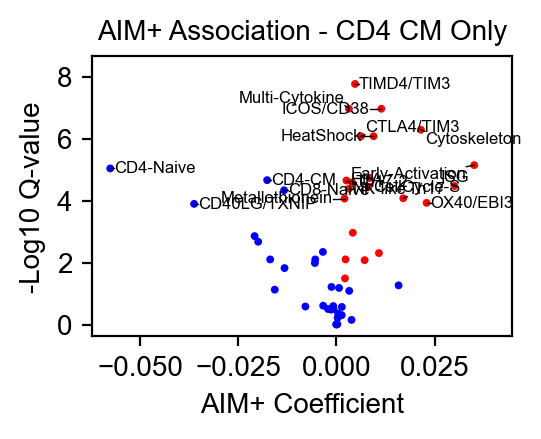

In [238]:
(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.2, 'top':0.9})
ind = (summary['Pos_B']>0) & (summary['Pos_Q']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')

xval = 'Pos_B'
yval = 'Pos_logQ'

ax.scatter(summary.loc[ind, xval], summary.loc[ind, yval], s=8, color='r', edgecolor='None')
ax.scatter(summary.loc[~ind, xval], summary.loc[~ind, yval], s=8, color='b', edgecolor='None')
ax.set_ylabel('-Log10 Q-value', fontsize=10)
ax.set_xlabel('AIM+ Coefficient', fontsize=10)
ax.set_title('AIM+ Association - CD4 CM Only', fontsize=10)

fs = 6



toplot = summary.index[(summary['Pos_logQ']>3.5)]

for i,g in enumerate(toplot):
    lab = summary.at[g, 'GEP']
    if lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'TNFRSF18+-Treg': lab = 'TNFRSF18+'
    elif lab == 'OX40/EBI3-Activation': lab = 'OX40/EBI3'
    elif lab == 'ICOS/CD38-Activation': lab = 'ICOS/CD38'
    elif lab == 'IL10/IL19-Secretion': lab = 'IL10/IL19'
    elif lab == 'TIMD4/TIM3-Activation': lab = 'TIMD4/TIM3'
    elif lab == 'CTLA4+/CD38+-Activation': lab='CTLA4/TIM3'

    
    if g in ['Metallothionein', 'HeatShock', 'ICOS/CD38-Activation', 'CD4-EM']: deltax = -0.003; deltay =0; ha='right'; va='center' ## Left
    elif g in ['CTLA4+/CD38+-Activation', 'CellCycle-G2M', 'Th17']: deltax = 0.001; deltay = .05; ha='left'; va='bottom' ## Upper-right
    elif g in ['CellCycle-S', 'Cytoskeleton']: deltax = 0.001; deltay = -.05; ha='left'; va='top' ## Lower-right
    elif g in ['Early-Activation']: deltax = -0.002; deltay =-0.05; ha='right'; va='top' ## Lower-Left
    elif g in ['ISG']: deltax = 0; deltay =0.05; ha='center'; va='bottom' ## Above
    elif g in ['Multi-Cytokine']: deltax = -0.001; deltay =0.1; ha='right'; va='bottom' ## Upper-Left
    else: deltax=.001; deltay=0; ha='left'; va='center' # Default to right

    if g not in ['Exhaustion', 'RGCC/MYADM']:
        ax.text(summary.at[g, xval]+deltax, summary.at[g, yval]+deltay, lab, ha=ha, va=va, fontsize=fs)
        ax.plot([summary.at[g, xval], summary.at[g, xval]+deltax], [summary.at[g, yval], summary.at[g, yval]+deltay], color='k', lw=.5)
        


ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.5)
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1]+.005)
'''

ax.fill_between([0, xlim[1]+.5], [ylim[1]+1, ylim[1]+1], color='.7', alpha=.15)
ax.set_ylim(-0.05, ylim[1]+.5)

#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.pdf'))
#plt.savefig(os.path.join(figdir, 'Volcano.TCRStim.Metaanalysis.png'))
'''

In [236]:
totest['lineage'].value_counts()

CD4_CM    9486
Name: lineage, dtype: int64

In [237]:
summary.loc[pos, :]

GEP    Stim_P         Pos_P  \
0                                                                          
HLA                                          HLA  0.004166  4.675732e-06   
ISG                                          ISG  0.000068  8.278599e-06   
CellCycle-S                          CellCycle-S  0.358284  3.176313e-06   
Early-Activation                Early-Activation  0.470478  9.480388e-07   
CCR10-Migration                  CCR10-Migration  0.246170  2.325863e-03   
MAIT                                        MAIT  0.415827  4.317610e-04   
Cytoskeleton                        Cytoskeleton  0.488874  3.917738e-08   
HeatShock                              HeatShock  0.241688  9.492537e-08   
Multi-Cytokine                    Multi-Cytokine  0.212899  4.170997e-09   
NK-like                                  NK-like  0.096821  1.181669e-05   
Metallothionein                  Metallothionein  0.007354  2.924043e-05   
Th17                                        Th17  0.014340  2.695925e-05   
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  0.039645  3.257518e-10   
Th2-2                                      Th2-2  0.678281  1.952384e-02   
ICOS/CD38-Activation        ICOS/CD38-Activation  0.000980  6.161637e-09   
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  0.559126  9.259467e-08   
CD8-Trm-Like                        CD8-Trm-Like  0.583054  3.952460e-03   
Th17-2                                    Th17-2  0.521746  5.859680e-06   
OX40/EBI3-Activation        OX40/EBI3-Activation  0.633069  4.237338e-05   
Tph                                          Tph  0.494448  4.576980e-03   
Exhaustion                            Exhaustion  0.086746  9.486991e-06   

                           Stim_B     Pos_B         Pos_Q    Stim_Q  Pos_logQ  
0                                                                              
HLA                      0.001141  0.002533  2.210346e-05  0.065077  4.655540  
ISG                      0.024138  0.030060  3.311440e-05  0.003536  4.479983  
CellCycle-S              0.000993  0.008454  1.835203e-05  0.582212  4.736316  
Early-Activation         0.002865  0.035103  7.042574e-06  0.676613  5.152269  
CCR10-Migration         -0.003428  0.010815  4.837795e-03  0.474105  2.315353  
MAIT                    -0.000729  0.004152  1.069123e-03  0.649627  2.970973  
Cytoskeleton             0.001256  0.021517  5.093059e-07  0.676613  6.293021  
HeatShock                0.001030  0.009447  8.226865e-07  0.474105  6.084766  
Multi-Cytokine           0.000280  0.003178  1.068017e-07  0.442830  6.971422  
NK-like                  0.000794  0.003147  4.096452e-05  0.251734  4.387592  
Metallothionein          0.001019  0.002057  8.447235e-05  0.065077  4.073285  
Th17                    -0.007422  0.017018  8.246358e-05  0.087676  4.083738  
TIMD4/TIM3-Activation    0.000586  0.004721  1.693909e-08  0.151632  7.771110  
Th2-2                    0.000342  0.002165  3.172624e-02  0.783791  1.498581  
ICOS/CD38-Activation     0.003433  0.011425  1.068017e-07  0.025481  6.971422  
CTLA4+/CD38+-Activation  0.000332  0.006244  8.226865e-07  0.709135  6.084766  
CD8-Trm-Like             0.000365  0.002302  7.743767e-03  0.721876  2.111048  
Th17-2                  -0.000343  0.003976  2.539195e-05  0.680530  4.595304  
OX40/EBI3-Activation     0.001799  0.022964  1.159692e-04  0.764489  3.935657  
Tph                      0.001454  0.007171  8.206999e-03  0.676613  2.085816  
Exhaustion               0.002074  0.008114  3.523740e-05  0.237411  4.452996

In [105]:
summary

GEP        Stim_P         Pos_P  \
0                                                                              
CellCycle-G2M                      CellCycle-G2M  2.084694e-02  1.908800e-09   
Translation                          Translation  6.306492e-01  1.296268e-01   
HLA                                          HLA  2.087536e-01  1.233146e-02   
ISG                                          ISG  8.920537e-07  3.091227e-05   
Mito                                        Mito  8.792772e-01  6.591374e-01   
Doublet-RBC                          Doublet-RBC  6.028504e-01  9.448175e-02   
gdT-Blood                              gdT-Blood  7.708196e-01  3.570253e-01   
CellCycle-S                          CellCycle-S  3.818362e-01  4.440070e-07   
Cytotoxic                              Cytotoxic  7.604233e-01  3.835746e-01   
Doublet-Platelet                Doublet-Platelet  9.021347e-01  1.096655e-01   
Early-Activation                Early-Activation  6.359834e-01  2.026976e-06   
CCR10-Migration                  CCR10-Migration  2.024314e-01  2.163376e-04   
MAIT                                        MAIT  7.769679e-01  6.885472e-01   
CellCycle-Late-S                CellCycle-Late-S  6.445845e-02  3.612265e-04   
Cytoskeleton                        Cytoskeleton  4.341868e-01  3.338420e-08   
HeatShock                              HeatShock  1.226102e-01  1.742728e-07   
Multi-Cytokine                    Multi-Cytokine  6.913251e-01  5.367446e-05   
NK-like                                  NK-like  8.370321e-01  9.867758e-01   
Doublet-Myeloid                  Doublet-Myeloid  9.955494e-01  9.455373e-01   
Metallothionein                  Metallothionein  1.534005e-03  3.362125e-09   
CD4-CM                                    CD4-CM  7.771079e-02  2.034165e-01   
IEG                                          IEG  1.969229e-02  5.754559e-01   
CD8-EM                                    CD8-EM  8.713155e-01  1.102215e-01   
IEG2                                        IEG2  1.675519e-01  1.705098e-01   
CD4-Naive                              CD4-Naive  3.054409e-02  2.064932e-05   
Treg                                        Treg  6.073749e-01  5.434726e-04   
Th17                                        Th17  3.116216e-02  3.300030e-07   
MALAT1                                    MALAT1  4.826295e-01  1.699623e-01   
CD8-Naive                              CD8-Naive  2.568100e-01  7.970603e-07   
RGCC/MYADM                            RGCC/MYADM  6.957513e-02  8.604898e-05   
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  1.183878e-01  5.021011e-04   
Doublet-Plasmablast          Doublet-Plasmablast  5.298599e-02  2.094825e-01   
BCL2-Survival                      BCL2-Survival  9.492480e-01  4.281481e-03   
IL10/IL19-Secretion          IL10/IL19-Secretion  1.178954e-02  5.451324e-01   
Th2-2                                      Th2-2  9.288427e-01  5.857801e-04   
Th2-1                                      Th2-1  6.381542e-02  5.610902e-01   
ICOS/CD38-Activation        ICOS/CD38-Activation  1.557222e-02  1.546815e-06   
Doublet-Bcell                      Doublet-Bcell  3.793838e-01  6.279543e-02   
CD4-EM                                    CD4-EM  4.504483e-02  7.520391e-05   
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  8.000081e-01  9.656554e-09   
CD8-Trm-Like                        CD8-Trm-Like  7.895894e-01  6.937014e-02   
Th17-2                                    Th17-2  4.069834e-01  2.149022e-03   
Tfh-2                                      Tfh-2  5.805604e-01  6.237063e-03   
OX40/EBI3-Activation        OX40/EBI3-Activation  6.567322e-01  2.614646e-05   
TXNIP/H1FX                            TXNIP/H1FX  6.031086e-01  5.426537e-02   
YPEL5/JUNB                            YPEL5/JUNB  1.860664e-01  5.202800e-01   
Doublet-Fibroblast            Doublet-Fibroblast  8.670744e-01  3.914768e-04   
SOX4/TOX2                              SOX4/TOX2  7.794573e-01  8.989011e-02   
CD40LG/TXNIP                        CD40LG/TX

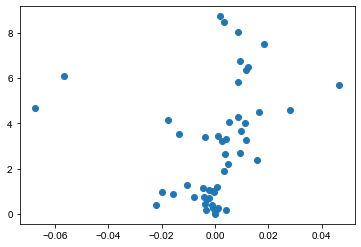

In [106]:
plt.scatter(summary['Pos_B'], summary['Pos_P'].apply(np.log10)*-1)

In [107]:
summary.sort_values(by='Pos_P')

GEP        Stim_P         Pos_P  \
0                                                                              
CellCycle-G2M                      CellCycle-G2M  2.084694e-02  1.908800e-09   
Metallothionein                  Metallothionein  1.534005e-03  3.362125e-09   
CTLA4+/CD38+-Activation  CTLA4+/CD38+-Activation  8.000081e-01  9.656554e-09   
Cytoskeleton                        Cytoskeleton  4.341868e-01  3.338420e-08   
HeatShock                              HeatShock  1.226102e-01  1.742728e-07   
Th17                                        Th17  3.116216e-02  3.300030e-07   
CellCycle-S                          CellCycle-S  3.818362e-01  4.440070e-07   
CD8-Naive                              CD8-Naive  2.568100e-01  7.970603e-07   
ICOS/CD38-Activation        ICOS/CD38-Activation  1.557222e-02  1.546815e-06   
Early-Activation                Early-Activation  6.359834e-01  2.026976e-06   
CD4-Naive                              CD4-Naive  3.054409e-02  2.064932e-05   
OX40/EBI3-Activation        OX40/EBI3-Activation  6.567322e-01  2.614646e-05   
ISG                                          ISG  8.920537e-07  3.091227e-05   
Multi-Cytokine                    Multi-Cytokine  6.913251e-01  5.367446e-05   
CD4-EM                                    CD4-EM  4.504483e-02  7.520391e-05   
RGCC/MYADM                            RGCC/MYADM  6.957513e-02  8.604898e-05   
Exhaustion                            Exhaustion  1.153752e-01  9.295476e-05   
CCR10-Migration                  CCR10-Migration  2.024314e-01  2.163376e-04   
CD40LG/TXNIP                        CD40LG/TXNIP  4.365942e-01  2.997621e-04   
CellCycle-Late-S                CellCycle-Late-S  6.445845e-02  3.612265e-04   
Doublet-Fibroblast            Doublet-Fibroblast  8.670744e-01  3.914768e-04   
TIMD4/TIM3-Activation      TIMD4/TIM3-Activation  1.183878e-01  5.021011e-04   
Treg                                        Treg  6.073749e-01  5.434726e-04   
Th2-2                                      Th2-2  9.288427e-01  5.857801e-04   
Tph                                          Tph  6.065331e-01  1.974148e-03   
Th17-2                                    Th17-2  4.069834e-01  2.149022e-03   
BCL2-Survival                      BCL2-Survival  9.492480e-01  4.281481e-03   
Tfh-2                                      Tfh-2  5.805604e-01  6.237063e-03   
HLA                                          HLA  2.087536e-01  1.233146e-02   
TXNIP/H1FX                            TXNIP/H1FX  6.031086e-01  5.426537e-02   
Doublet-Bcell                      Doublet-Bcell  3.793838e-01  6.279543e-02   
CD8-Trm-Like                        CD8-Trm-Like  7.895894e-01  6.937014e-02   
SOX4/TOX2                              SOX4/TOX2  7.794573e-01  8.989011e-02   
Doublet-RBC                          Doublet-RBC  6.028504e-01  9.448175e-02   
Doublet-Platelet                Doublet-Platelet  9.021347e-01  1.096655e-01   
CD8-EM                                    CD8-EM  8.713155e-01  1.102215e-01   
Translation                          Translation  6.306492e-01  1.296268e-01   
MALAT1                                    MALAT1  4.826295e-01  1.699623e-01   
IEG2                                        IEG2  1.675519e-01  1.705098e-01   
CD4-CM                                    CD4-CM  7.771079e-02  2.034165e-01   
Doublet-Plasmablast          Doublet-Plasmablast  5.298599e-02  2.094825e-01   
gdT-Blood                              gdT-Blood  7.708196e-01  3.570253e-01   
Cytotoxic                              Cytotoxic  7.604233e-01  3.835746e-01   
Tfh-1                                      Tfh-1  5.648703e-01  4.028475e-01   
YPEL5/JUNB                            YPEL5/JUNB  1.860664e-01  5.202800e-01   
IL10/IL19-Secretion          IL10/IL19-Secretion  1.178954e-02  5.451324e-01   
Th2-1                                      Th2-1  6.381542e-02  5.610902e-01   
IEG                                          IEG  1.969229e-02  5.754559e-01   
Mito                                        M

(0.02084693844128109,
 1.9088002502299868e-09,
 0.0002829142846167112,
 0.0016983512789011002)

In [96]:
res.params

CEFX_Stimulated    0.000283
CEFX_Pos           0.001698
Intercept          0.002279
dtype: float64

In [84]:

'''
average_usage_pos = average_usage.xs('-', axis=0, level=1)
average_usage_neg = average_usage.xs('U', axis=0, level=1)
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
mean_pos = average_usage_pos.mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)


summary_neg = pd.concat([Ps, Ts, lograt, mean_pos], axis=1)
summary_neg.columns = ['P', 'T', 'lograt', 'MeanPos']


r, summary_neg['Q'] = fdrcorrection(summary_neg['P'], alpha=0.05, method='indep', is_sorted=False)

summary_neg['renamed'] = [name_dict[x] for x in summary_neg.index]
summary_neg.index = summary_neg['renamed']

summary_neg['logP'] = summary_neg['Q'].apply(np.log10)*-1
summary_neg = summary_neg.sort_values(by='T', ascending=False)
'''

Biobank_ID Sort_Status
0    10033066           +
1    10033066           -
2    10033066           U
3    10041243           +
4    10041243           -
5    10041243           U
6    10042029           +
7    10042029           -
8    10042029           U
9    10049452           +
10   10049452           -
11   10049452           U
12   10057029           +
13   10057029           -
14   10057029           U

In [62]:
rf_usage_norm_annot
predicter = pd.get_dummies(rf_usage_norm_annot['Sort_Status'])
predicter['CEFX_Stimulated'] = predicter['+']  + predicter['-']
predicter['CEFX_Pos'] = predicter['+']
predicter = predicter[['CEFX_Stimulated', 'CEFX_Pos']]
predicter

CEFX_Stimulated  CEFX_Pos
3_AAACCTGAGACCGGAT                1         1
3_AAACCTGAGAGGGCTT                0         0
3_AAACCTGAGAGTCTGG                1         1
3_AAACCTGAGCTAGCCC                0         0
3_AAACCTGAGCTGCCCA                1         1
...                             ...       ...
2_TTTGTCATCAGGCCCA                0         0
2_TTTGTCATCATATCGG                1         1
2_TTTGTCATCATTATCC                1         0
2_TTTGTCATCGGCTACG                0         0
2_TTTGTCATCTCCAGGG                1         0

[43222 rows x 2 columns]

In [ ]:
mod = sm.OLS(spector_data.endog, spector_data.exog)

In [50]:
sm

NameError: name 'sm' is not defined

## Run test by lineage

In [160]:
rf_usage_norm_annot_ren = rf_usage_norm_annot.rename(columns=name_dict)

In [166]:
percelltype_summary = {}
for (k,g) in rf_usage_norm_annot_ren.groupby('lineage'):
    totest = g.loc[g['Sort_Status']!='U',:]
    totest['Sort_Status'] = totest['Sort_Status'].astype(str)
    average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
    average_usage_pos = average_usage.xs('+', axis=0, level=1)
    average_usage_neg = average_usage.xs('-', axis=0, level=1)
    Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)
    lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
    mean_pos = average_usage_pos.mean(axis=0)
    #lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)


    percelltype_summary[k] = pd.concat([Ps, Ts, lograt, mean_pos], axis=1)
    percelltype_summary[k].columns = ['P', 'T', 'lograt', 'MeanPos']
    r, percelltype_summary[k]['Q'] = fdrcorrection(percelltype_summary[k]['P'], alpha=0.05, method='indep', is_sorted=False)
    percelltype_summary[k]['gate'] = k 

/tmp/ipykernel_31792/2827799552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_31792/2827799552.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
/tmp/ipykernel_31792/2827799552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [167]:
percelltype_summary.keys()

dict_keys(['CD4_CM', 'CD4_EM', 'CD4_Naive', 'CD4_TEMRA', 'CD8_CM', 'CD8_EM', 'CD8_Naive', 'CD8_TEMRA', 'DN', 'DP', 'MAIT', 'Treg', 'gdT'])

In [171]:
lin = 'Treg'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P          T    lograt   MeanPos         Q  gate
ICOS/CD38-Activation   0.000102  15.482599  0.459060  0.018264  0.005282  Treg
Exhaustion             0.001172   8.259376  0.888893  0.015071  0.015241  Treg
HeatShock              0.002181   7.009124  0.605468  0.020330  0.018656  Treg
TIMD4/TIM3-Activation  0.002870   6.512132  0.919285  0.006189  0.018656  Treg
OX40/EBI3-Activation   0.001829   7.345930  2.023939  0.072480  0.018656  Treg
Tph                    0.002828   6.538272  1.033103  0.017705  0.018656  Treg
Cytoskeleton           0.007539   4.990892  1.267468  0.020485  0.035638  Treg
Early-Activation       0.012429   4.321882  1.276426  0.049932  0.046165  Treg
Th17-2                 0.010851   4.496618  1.062872  0.008723  0.046165  Treg

In [172]:
lin = 'CD4_Naive'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P          T    lograt   MeanPos         Q  \
OX40/EBI3-Activation     0.000241  12.434148  2.668536  0.023809  0.002098   
Cytoskeleton             0.000108  15.258349  2.725886  0.028371  0.002098   
Multi-Cytokine           0.000242  12.413342  1.112112  0.003614  0.002098   
Early-Activation         0.000299  11.762435  3.482790  0.070705  0.002220   
TIMD4/TIM3-Activation    0.000409  10.852564  1.608125  0.007322  0.002364   
Th2-2                    0.000403  10.893854  0.440055  0.005124  0.002364   
ICOS/CD38-Activation     0.000514  10.232992  0.977611  0.022957  0.002430   
Exhaustion               0.000496  10.327132  1.325072  0.012892  0.002430   
Tph                      0.000730   9.345214  1.388322  0.007325  0.002920   
CTLA4+/CD38+-Activation  0.000694   9.469176  0.814288  0.009006  0.002920   
Th17-2                   0.001057   8.487201  0.755452  0.004459  0.003615   
Metallothionein          0.001449   7.812710  1.799579  0.012829  0.004185   
HeatShock                0.002009   7.164709  1.294575  0.014145  0.005498   
Tfh-2                    0.003122   6.365787  0.452731  0.018715  0.008118   
CellCycle-S              0.003849   6.014086  1.889733  0.020265  0.009098   
CellCycle-G2M            0.006143   5.286516  0.969750  0.004755  0.013310   
CD8-Trm-Like             0.006613   5.178460  0.324397  0.006061  0.013756   
HLA                      0.011977   4.369025  0.903803  0.004744  0.023067   
BCL2-Survival            0.016927   3.942277  0.465298  0.043274  0.031437   
CCR10-Migration          0.028526   3.351615  1.067365  0.005767  0.049445   

                              gate  
OX40/EBI3-Activation     CD4_Naive  
Cytoskeleton             CD4_Naive  
Multi-Cytokine           CD4_Naive  
Early-Activation         CD4_Naive  
TIMD4/TIM3-Activation    CD4_Naive  
Th2-2                    CD4_Naive  
ICOS/CD38-Activation     CD4_Naive  
Exhaustion               CD4_Naive  
Tph                      CD4_Naive  
CTLA4+/CD38+-Activation  CD4_Naive  
Th17-2                   CD4_Naive  
Metallothionein          CD4_Naive  
HeatShock                CD4_Naive  
Tfh-2                    CD4_Naive  
CellCycle-S              CD4_Naive  
CellCycle-G2M            CD4_Naive  
CD8-Trm-Like             CD4_Naive  
HLA                      CD4_Naive  
BCL2-Survival            CD4_Naive  
CCR10-Migration          CD4_Naive

In [173]:
lin = 'CD8_Naive'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P          T    lograt   MeanPos         Q  \
HeatShock             0.000155  13.914866  1.704089  0.015704  0.008043   
Multi-Cytokine        0.000971   8.677120  1.739854  0.005811  0.016828   
OX40/EBI3-Activation  0.002952   6.462676  3.286643  0.024686  0.028151   
Exhaustion            0.003248   6.298070  1.601546  0.012351  0.028151   
Tph                   0.005468   5.460613  1.191358  0.004547  0.035542   
Early-Activation      0.008018   4.904509  4.317161  0.086514  0.041694   
BCL2-Survival         0.007247   5.046928  1.368856  0.027550  0.041694   

                           gate  
HeatShock             CD8_Naive  
Multi-Cytokine        CD8_Naive  
OX40/EBI3-Activation  CD8_Naive  
Exhaustion            CD8_Naive  
Tph                   CD8_Naive  
Early-Activation      CD8_Naive  
BCL2-Survival         CD8_Naive

In [175]:
lin = 'CD4_CM'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P          T    lograt   MeanPos         Q  \
ICOS/CD38-Activation     0.000013  25.959355  0.942146  0.023943  0.000340   
Exhaustion               0.000235  12.513656  1.499482  0.012690  0.001900   
CTLA4+/CD38+-Activation  0.000290  11.851200  0.654726  0.017184  0.001900   
TIMD4/TIM3-Activation    0.000228  12.610851  1.601432  0.007055  0.001900   
NK-like                  0.000378  11.078887  0.727031  0.007942  0.001926   
Multi-Cytokine           0.000407  10.864362  1.381098  0.005185  0.001926   
HeatShock                0.000513  10.237603  1.598931  0.014088  0.002224   
Cytoskeleton             0.000673   9.545344  2.712921  0.025403  0.002691   
Early-Activation         0.000782   9.181111  3.117766  0.039943  0.002710   
HLA                      0.000903   8.842143  0.910223  0.005499  0.002935   
CellCycle-S              0.001040   8.522187  1.548212  0.012784  0.003182   
ISG                      0.001252   8.117431  1.044165  0.057979  0.003428   
MAIT                     0.001517   7.718559  0.588063  0.012317  0.003943   
Metallothionein          0.002372   6.853783  0.810729  0.004807  0.005364   
Th17                     0.003061   6.399735  0.978465  0.034374  0.006633   
Th17-2                   0.003542   6.151836  1.030916  0.007781  0.007367   
OX40/EBI3-Activation     0.004154   5.890205  3.254897  0.025799  0.008308   
BCL2-Survival            0.004413   5.793497  0.576890  0.048009  0.008498   
Tph                      0.013970   4.175420  1.150807  0.012672  0.025049   
CCR10-Migration          0.021465   3.666058  0.889744  0.023468  0.037207   
CD8-Trm-Like             0.030902   3.266119  0.474195  0.007947  0.048694   

                           gate  
ICOS/CD38-Activation     CD4_CM  
Exhaustion               CD4_CM  
CTLA4+/CD38+-Activation  CD4_CM  
TIMD4/TIM3-Activation    CD4_CM  
NK-like                  CD4_CM  
Multi-Cytokine           CD4_CM  
HeatShock                CD4_CM  
Cytoskeleton             CD4_CM  
Early-Activation         CD4_CM  
HLA                      CD4_CM  
CellCycle-S              CD4_CM  
ISG                      CD4_CM  
MAIT                     CD4_CM  
Metallothionein          CD4_CM  
Th17                     CD4_CM  
Th17-2                   CD4_CM  
OX40/EBI3-Activation     CD4_CM  
BCL2-Survival            CD4_CM  
Tph                      CD4_CM  
CCR10-Migration          CD4_CM  
CD8-Trm-Like             CD4_CM

In [176]:
lin = 'CD4_EM'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P          T    lograt   MeanPos         Q  \
Exhaustion             0.000055  18.114607  1.461881  0.016187  0.001420   
CellCycle-S            0.000718   9.385947  1.814800  0.017676  0.006715   
Early-Activation       0.000868   8.933490  3.122730  0.054830  0.006715   
Multi-Cytokine         0.001033   8.537546  1.652420  0.009731  0.006715   
HeatShock              0.003596   6.126723  1.325683  0.016352  0.013754   
Metallothionein        0.003968   5.964620  1.027562  0.004581  0.013754   
OX40/EBI3-Activation   0.003728   6.066755  3.163811  0.038905  0.013754   
Cytoskeleton           0.004901   5.628713  2.079832  0.029226  0.015927   
BCL2-Survival          0.012093   4.356735  0.646821  0.035811  0.034935   
TIMD4/TIM3-Activation  0.015403   4.055712  0.905176  0.009992  0.042156   
ISG                    0.016665   3.960928  0.554278  0.041390  0.043328   
ICOS/CD38-Activation   0.021497   3.664376  0.463320  0.019138  0.048603   

                         gate  
Exhaustion             CD4_EM  
CellCycle-S            CD4_EM  
Early-Activation       CD4_EM  
Multi-Cytokine         CD4_EM  
HeatShock              CD4_EM  
Metallothionein        CD4_EM  
OX40/EBI3-Activation   CD4_EM  
Cytoskeleton           CD4_EM  
BCL2-Survival          CD4_EM  
TIMD4/TIM3-Activation  CD4_EM  
ISG                    CD4_EM  
ICOS/CD38-Activation   CD4_EM

In [179]:
lin = 'CD8_CM'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P          T    lograt   MeanPos         Q  \
CellCycle-S              0.000402  10.898410  1.493090  0.011998  0.008631   
Cytoskeleton             0.000304  11.707066  2.721301  0.016558  0.008631   
Exhaustion               0.004129   5.899816  2.091144  0.026175  0.032162   
Early-Activation         0.006006   5.319967  3.981178  0.045800  0.034803   
HeatShock                0.006904   5.116250  1.671732  0.013280  0.034803   
TIMD4/TIM3-Activation    0.007444   5.008874  1.206674  0.016608  0.034803   
CTLA4+/CD38+-Activation  0.008031   4.902173  1.042967  0.012042  0.034803   
OX40/EBI3-Activation     0.010861   4.495377  3.706413  0.023734  0.040341   
BCL2-Survival            0.011765   4.391901  1.045780  0.025854  0.040786   
Tph                      0.015085   4.081079  1.599221  0.011126  0.043579   

                           gate  
CellCycle-S              CD8_CM  
Cytoskeleton             CD8_CM  
Exhaustion               CD8_CM  
Early-Activation         CD8_CM  
HeatShock                CD8_CM  
TIMD4/TIM3-Activation    CD8_CM  
CTLA4+/CD38+-Activation  CD8_CM  
OX40/EBI3-Activation     CD8_CM  
BCL2-Survival            CD8_CM  
Tph                      CD8_CM

In [181]:
lin = 'CD8_TEMRA'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

Empty DataFrame
Columns: [P, T, lograt, MeanPos, Q, gate]
Index: []

In [182]:
lin = 'CD4_TEMRA'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

Empty DataFrame
Columns: [P, T, lograt, MeanPos, Q, gate]
Index: []

In [178]:
lin = 'CD8_EM'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P         T    lograt   MeanPos         Q    gate
Cytoskeleton  0.002640  6.660285  1.453157  0.006202  0.034318  CD8_EM
HeatShock     0.004070  5.923270  1.414570  0.012710  0.036037  CD8_EM
Exhaustion    0.005263  5.518682  1.565589  0.033541  0.039099  CD8_EM

In [174]:
lin = 'gdT'
ind = (percelltype_summary[lin]['Q']<.05) & (percelltype_summary[lin]['T']>0)
percelltype_summary[lin].loc[ind, :].sort_values(by='Q')

P         T    lograt   MeanPos         Q gate
Exhaustion  0.001016  8.575054  1.278901  0.038634  0.022987  gdT

In [68]:
rf_usage_norm_annot_ren = rf_usage_norm_annot.rename(columns=name_dict)

In [70]:
[x for x in rf_usage_norm_annot_ren.columns if 'CD4' in x]

['CD4-CM', 'CD4-Naive', 'CD4-EM', 'CD40LG/TXNIP']

In [155]:
cd4_tem = rf_usage_norm_annot_ren.index[(rf_usage_norm_annot_ren['CD4-EM']>.05) & rf_usage_norm_annot_ren['Sort_Status'].isin(['+', '-'])]
query_adata_tem = query_adata[cd4_tem, :]
sc.pp.normalize_per_cell(query_adata_tem)
sc.pp.log1p(query_adata_tem)
sc.tl.rank_genes_groups(query_adata_tem, groupby='Sort_Status')
query_adata_tem.obs['Sort_Status'].value_counts()

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


-    3330
+     916
Name: Sort_Status, dtype: int64

In [156]:
pd.DataFrame(query_adata_tem.uns['rank_genes_groups']['names']).head(50)

+           -
0     TMSB10        FTH1
1      PSME2     ZFP36L2
2       IL32        KLF2
3      PSME1      MALAT1
4      STAT1       SARAF
5       TYMP        IL7R
6       CISH        FCMR
7     TUBA1B        LYAR
8    TNFRSF4      PABPC1
9      HSPA8       YPEL3
10      ACTB   LINC00861
11      BST2       PNRC1
12      GBP4       RPL30
13      WARS       KLRK1
14  HSP90AB1        AOAH
15       PKM      PBXIP1
16       TXN      PIK3R1
17  C17orf49       RPS3A
18      TAP1        GAS5
19      CD74        CD52
20     SOCS1       SPON1
21      GBP1       S1PR1
22      CALR        CD8B
23       LTB       SESN3
24      GBP5     TSC22D3
25      PFN1    LEPROTL1
26       B2M       PTPRC
27      ENO1       DUSP2
28     IFI30         FYN
29     IFI35    HLA-DPB1
30    SAMHD1     PPP2R5C
31    HAPLN3       CXCR4
32      RGS1        PASK
33     PRDX1        TCF7
34      TUBB        RPS3
35    DNAJA1         FTL
36     ACTG1      CDKN1B
37     DUSP5        SELL
38     CLIC1       EVI2B
39    NFKBIA      RPS15A
40   BHLHE40  AC119396.1
41     ANXA2       EEF1D
42     PHPT1        CD55
43    LGALS1         ATM
44     EIF5A        KLF3
45    PSMB10       RASA3
46       VIM        RBL2
47  HSP90AA1       NELL2
48     PSMB8       RPL41
49       FAS      SNHG29

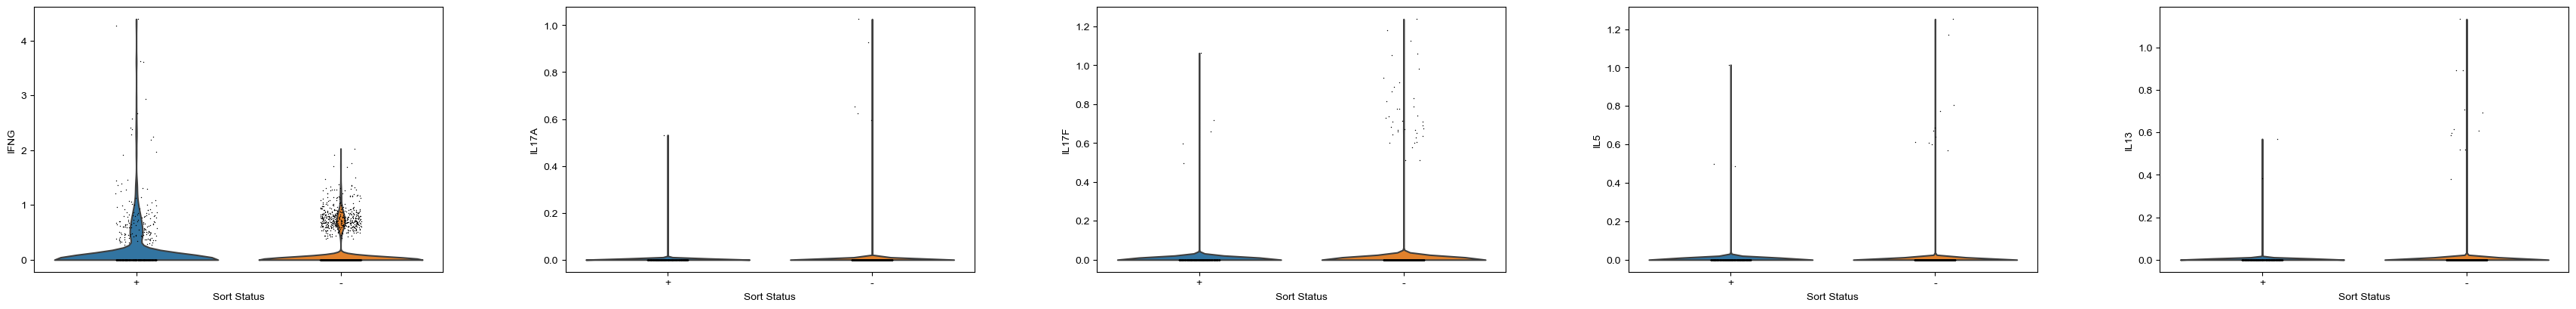

In [157]:
sc.pl.violin(query_adata_tem, keys=['IFNG', 'IL17A', 'IL17F', 'IL5', 'IL13'], groupby='Sort_Status')

/tmp/ipykernel_31792/1742578530.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_tem,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_31792/1742578530.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
/tmp/ipykernel_31792/1742578530.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)


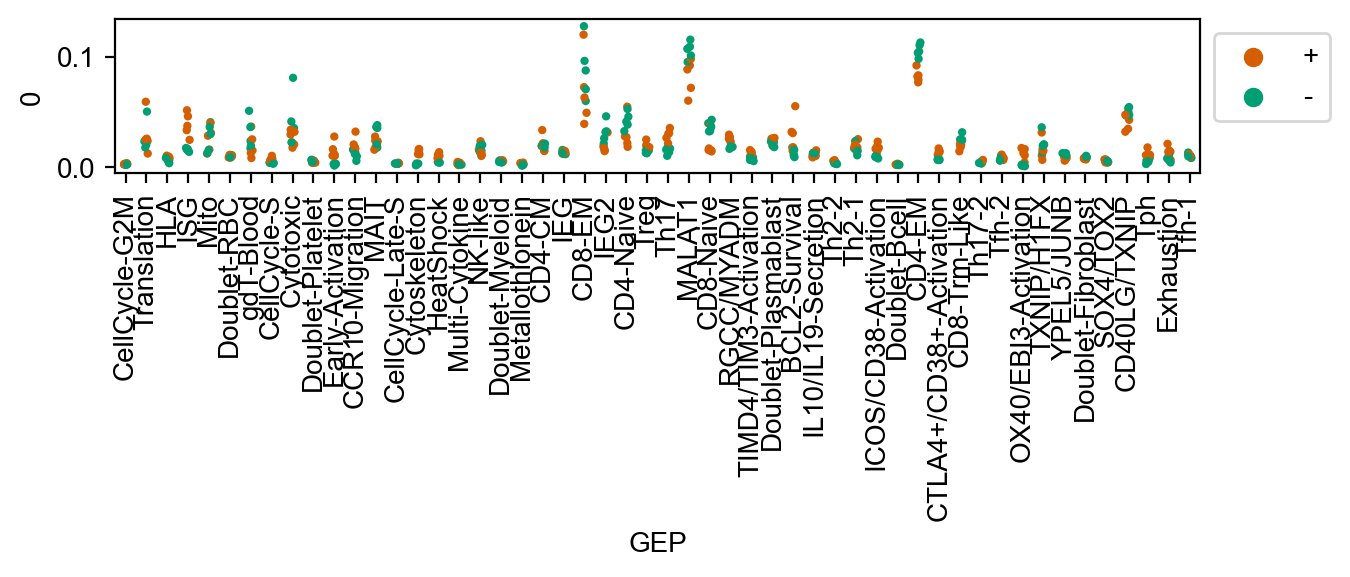

In [158]:
rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_tem,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat['GEP'] = rf_usage_norm_annot_flat['level_0'].replace(name_dict)
(fig,ax) = plt.subplots(1,1, figsize=(7,1), dpi=200)
sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
             hue_order=['+', '-'], order=rf_usage_norm_annot_ren.columns[:-3], ax=ax)

_ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)
ax.legend(bbox_to_anchor=(1,1))

#rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP'].isin(toplot),:]

In [151]:
cd4_th17 = rf_usage_norm_annot_ren.index[(rf_usage_norm_annot_ren['Th17']>.05) & rf_usage_norm_annot_ren['Sort_Status'].isin(['+', '-'])]
query_adata_tem = query_adata[cd4_th17, :]
sc.pp.normalize_per_cell(query_adata_tem)
sc.pp.log1p(query_adata_tem)
sc.tl.rank_genes_groups(query_adata_tem, groupby='Sort_Status')
query_adata_tem.obs['Sort_Status'].value_counts()

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


+    1624
-     379
Name: Sort_Status, dtype: int64

In [152]:
pd.DataFrame(query_adata_tem.uns['rank_genes_groups']['names']).head(50)

+          -
0     TNFRSF4       IL7R
1      TUBA1B    ZFP36L2
2       IL4I1       KLF2
3         LTA      SARAF
4        ACTB     MALAT1
5    MIR155HG     PABPC1
6        TYMP      PNRC1
7         PKM      YPEL3
8       ACTG1      RPL30
9       IL2RA       GAS5
10     TMSB10       TCF7
11     TUBA1C       FCMR
12       IL32       CD52
13       CALR      RPL34
14       TUBB      TXNIP
15      PSME2        FTL
16   TNFRSF18       NACA
17       WARS      RPS14
18        TXN      RPL32
19      CLIC1      NOP53
20     CD40LG      RPL18
21       ENO1      RPS27
22       RBM3       FTH1
23      PRDX1       RPS3
24      SNX10  LINC00861
25     LGALS1      RPL11
26    BHLHE40      RPL39
27   HSP90AB1      EEF1D
28      FURIN      RPS13
29      GNA15     RPL35A
30       PFN1      RPL26
31        DBI     CDKN1B
32      SOCS1     RPS15A
33       CISH     GIMAP2
34      ANXA2      FXYD5
35      VDAC1      RPS3A
36      ACTR3      S1PR1
37     NFKBIA   C12orf57
38      ATOX1       RPL3
39       NME1       SUN2
40      CCND2       RPL8
41     TUBB4B      ITM2B
42       RAC2      RPL36
43      DUSP5      RASA3
44     CORO1A      SNHG6
45  HNRNPA2B1      NELL2
46      EIF5A      RPS4X
47   HSP90AA1      RPL37
48      IL2RB      RPL29
49       PGK1    PIK3IP1

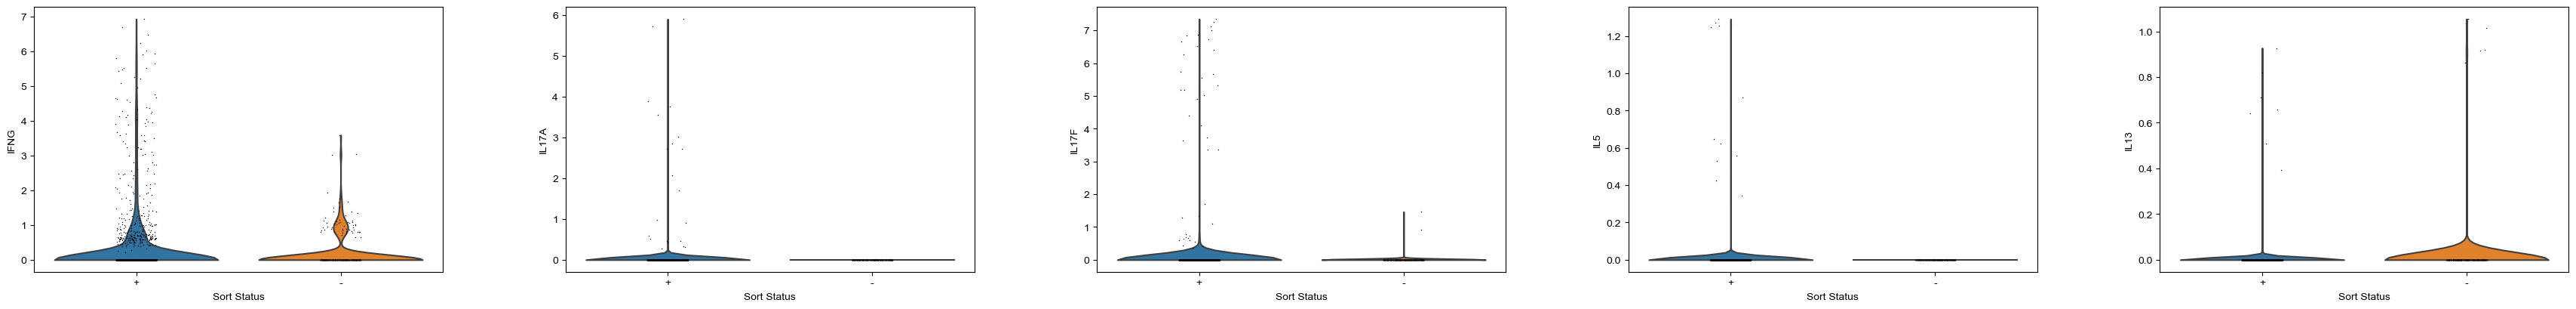

In [153]:
sc.pl.violin(query_adata_tem, keys=['IFNG', 'IL17A', 'IL17F', 'IL5', 'IL13'], groupby='Sort_Status')

/tmp/ipykernel_31792/3692322487.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_th17,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_31792/3692322487.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
/tmp/ipykernel_31792/3692322487.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)


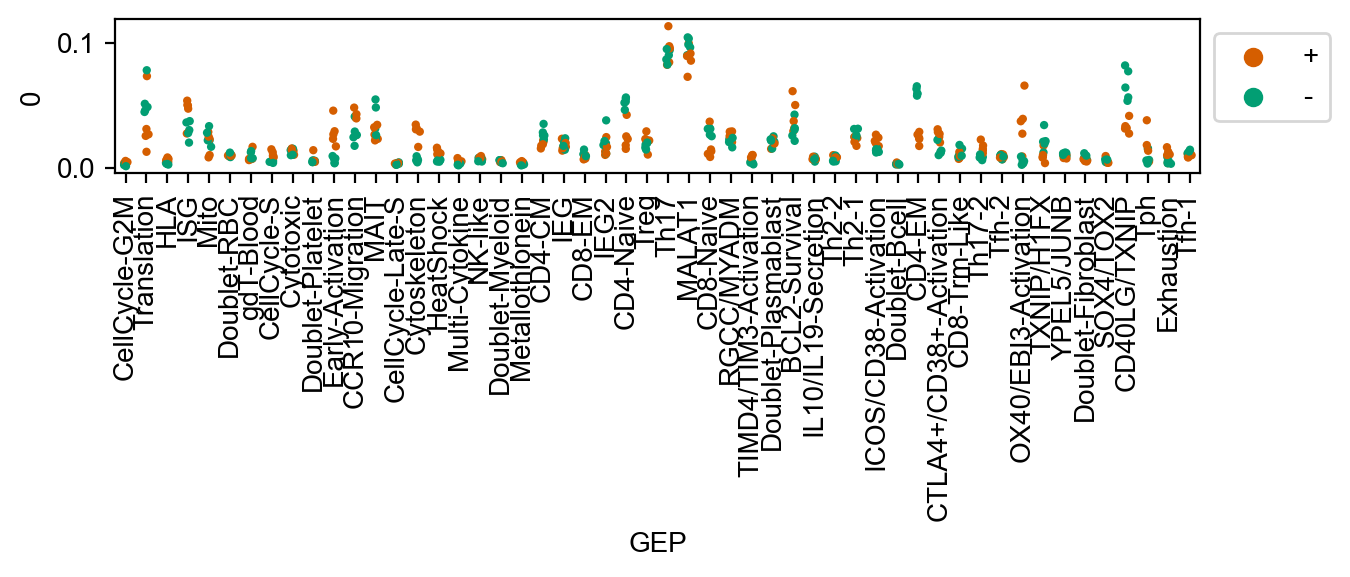

In [183]:
rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_th17,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat['GEP'] = rf_usage_norm_annot_flat['level_0'].replace(name_dict)
(fig,ax) = plt.subplots(1,1, figsize=(7,1), dpi=200)
sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
             hue_order=['+', '-'], order=rf_usage_norm_annot_ren.columns[:-3], ax=ax)

_ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)
ax.legend(bbox_to_anchor=(1,1))

#rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP'].isin(toplot),:]

In [189]:
rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP']=='Th17-2', :].sort_values(by=0).dropna()

level_0 Biobank_ID Sort_Status         0     GEP
622  IL26/CTSH   10042029           -  0.005912  Th17-2
619  IL26/CTSH   10041243           -  0.008037  Th17-2
616  IL26/CTSH   10033066           -  0.008401  Th17-2
628  IL26/CTSH   10057029           -  0.009311  Th17-2
625  IL26/CTSH   10049452           -  0.010464  Th17-2
618  IL26/CTSH   10041243           +  0.011461  Th17-2
615  IL26/CTSH   10033066           +  0.013712  Th17-2
624  IL26/CTSH   10049452           +  0.014992  Th17-2
627  IL26/CTSH   10057029           +  0.017610  Th17-2
621  IL26/CTSH   10042029           +  0.022377  Th17-2

In [190]:
rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP']=='Th2-2', :].sort_values(by=0).dropna()

level_0 Biobank_ID Sort_Status         0    GEP
517  CCR3+-Th2   10042029           -  0.004815  Th2-2
514  CCR3+-Th2   10041243           -  0.004997  Th2-2
511  CCR3+-Th2   10033066           -  0.005289  Th2-2
523  CCR3+-Th2   10057029           -  0.005435  Th2-2
522  CCR3+-Th2   10057029           +  0.008104  Th2-2
510  CCR3+-Th2   10033066           +  0.008186  Th2-2
516  CCR3+-Th2   10042029           +  0.008215  Th2-2
519  CCR3+-Th2   10049452           +  0.008334  Th2-2
520  CCR3+-Th2   10049452           -  0.009611  Th2-2
513  CCR3+-Th2   10041243           +  0.009901  Th2-2

In [147]:
cd4_th2 = rf_usage_norm_annot_ren.index[(rf_usage_norm_annot_ren['Th2-1']>.05) & rf_usage_norm_annot_ren['Sort_Status'].isin(['+', '-'])]
query_adata_tem = query_adata[cd4_th2, :]
sc.pp.normalize_per_cell(query_adata_tem)
sc.pp.log1p(query_adata_tem)
sc.tl.rank_genes_groups(query_adata_tem, groupby='Sort_Status')
query_adata_tem.obs['Sort_Status'].value_counts()

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


-    712
+    497
Name: Sort_Status, dtype: int64

In [148]:
pd.DataFrame(query_adata_tem.uns['rank_genes_groups']['names']).head(50)

+           -
0       IL32        KLF2
1      PSME2       SARAF
2     TMSB10      PABPC1
3       WARS        FTH1
4    TNFRSF4     ZFP36L2
5     TUBA1B        FCMR
6       ACTB      MALAT1
7       TYMP        IL7R
8       CISH       SESN3
9      HSPA8        PASK
10      PFN1       TXNIP
11     SOCS1       PNRC1
12  HSP90AB1       YPEL3
13     PSME1        GAS5
14      TUBB        TCF7
15      ENO1       SNED1
16       PKM        CD52
17      BST2     TSC22D3
18     CLIC1    LEPROTL1
19  HSP90AA1         FTL
20      CD74       RPL30
21       TXN     PPP2R5C
22     EIF5A  AC119396.1
23  C17orf49        CD55
24      TAP2        RGCC
25      RGS1      PBXIP1
26       MVP        SELL
27       DBI      RPS15A
28      GBP4       SNHG6
29     PRDX1      CDKN1B
30     IFI35       RPS27
31     IFI30       RASA3
32    DNAJA1       CXCR4
33  TNFRSF18   LINC00861
34     STAT1      RPL35A
35      TAP1         FYN
36      CD63       DPEP2
37   BHLHE40       S1PR4
38     PSMB3       RPL11
39    TUBA1C       RPS13
40   TNFSF10       RPL32
41    TUBB4B       RPL34
42       LTB       FXYD5
43     PRMT1        BTG1
44    NFKBIA        KLF3
45      IFI6       NEAT1
46    SYNGR2        LEF1
47     ATOX1     TCP11L2
48     PSMB6       EVI2B
49      LY6E        EEF2

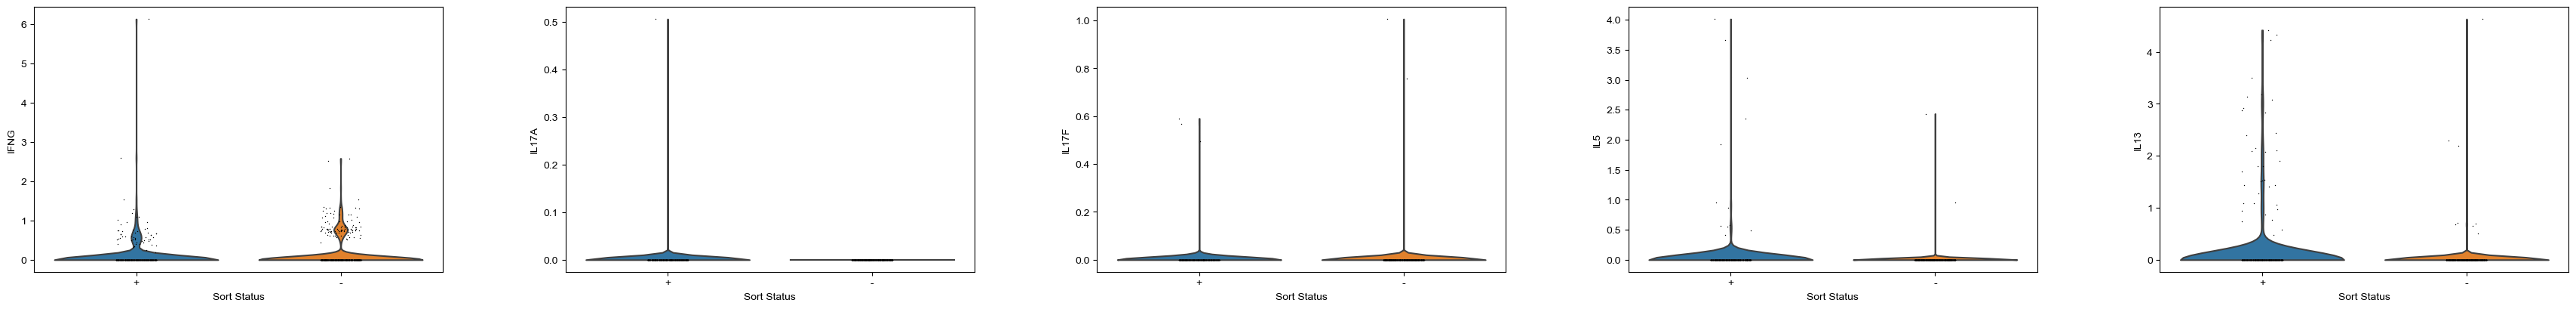

In [149]:
sc.pl.violin(query_adata_tem, keys=['IFNG', 'IL17A', 'IL17F', 'IL5', 'IL13'], groupby='Sort_Status')

/tmp/ipykernel_31792/13572838.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_th2,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_31792/13572838.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
/tmp/ipykernel_31792/13572838.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)


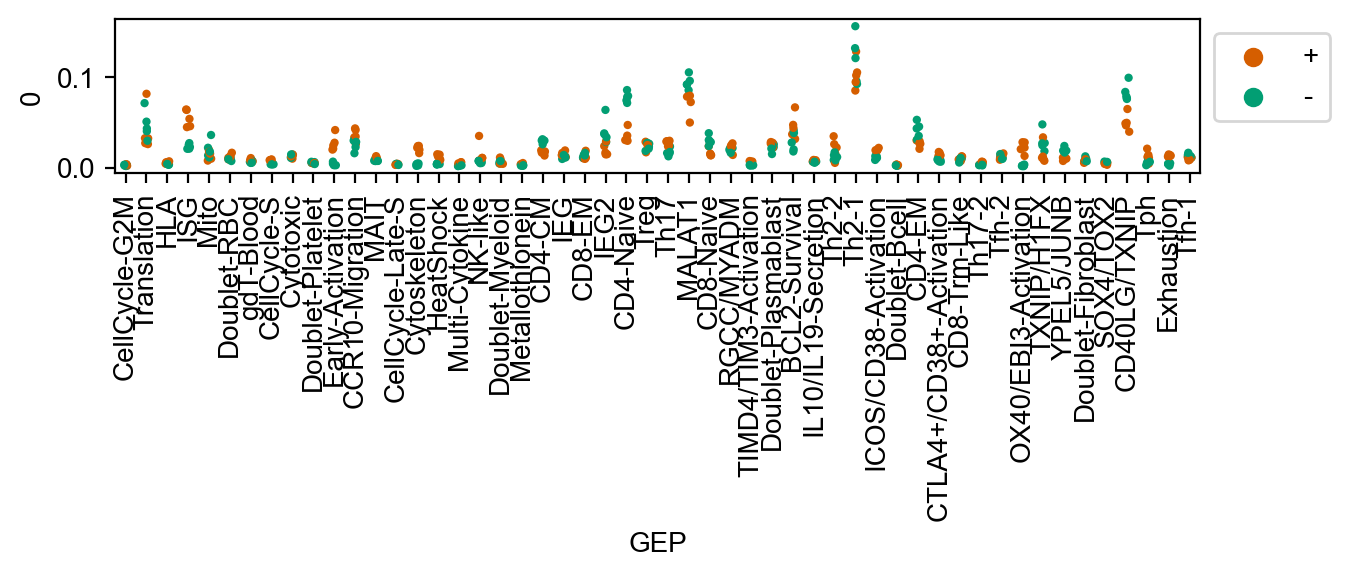

In [150]:
rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_th2,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat['GEP'] = rf_usage_norm_annot_flat['level_0'].replace(name_dict)
(fig,ax) = plt.subplots(1,1, figsize=(7,1), dpi=200)
sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
             hue_order=['+', '-'], order=rf_usage_norm_annot_ren.columns[:-3], ax=ax)

_ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)
ax.legend(bbox_to_anchor=(1,1))

#rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP'].isin(toplot),:]

/tmp/ipykernel_31792/2661064946.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_tem,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_31792/2661064946.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
/tmp/ipykernel_31792/2661064946.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)


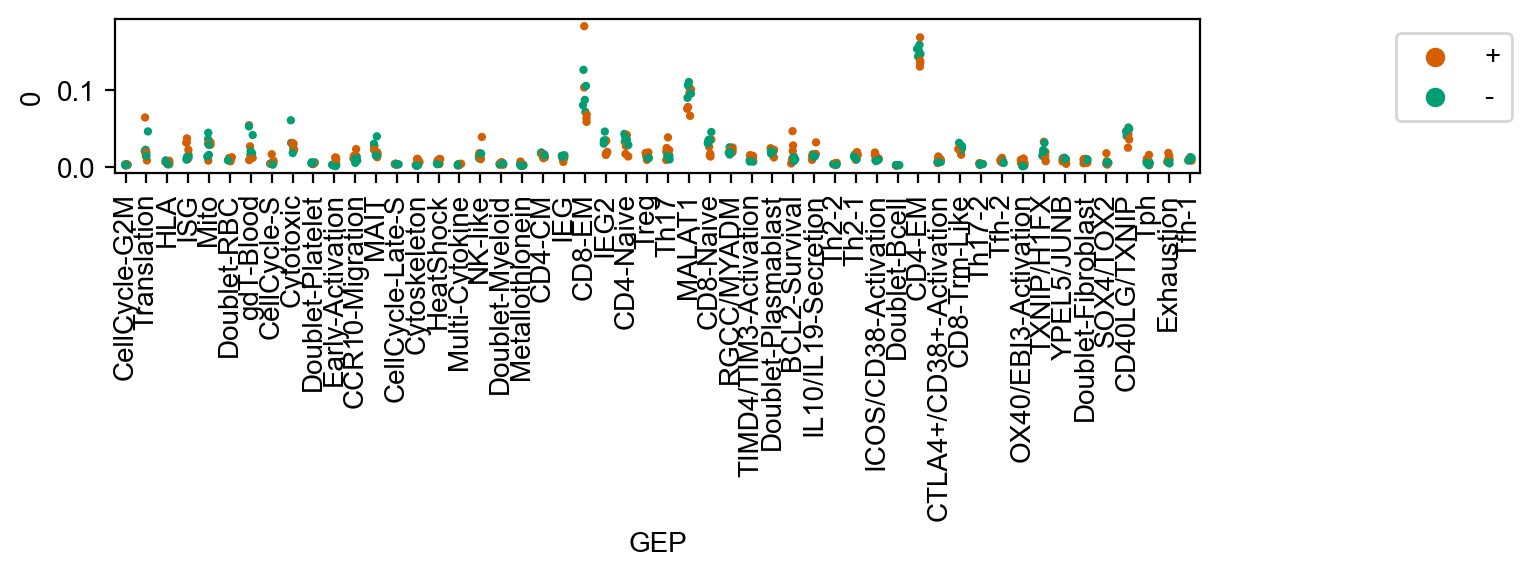

In [103]:
rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_tem,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat['GEP'] = rf_usage_norm_annot_flat['level_0'].replace(name_dict)
(fig,ax) = plt.subplots(1,1, figsize=(7,1), dpi=200)
sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
             hue_order=['+', '-'], order=rf_usage_norm_annot_ren.columns[:-3], ax=ax)

_ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)
ax.legend(bbox_to_anchor=(1.3, 1))

#rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP'].isin(toplot),:]

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


-    249
+    123
Name: Sort_Status, dtype: int64

In [108]:
pd.DataFrame(query_adata_tem.uns['rank_genes_groups']['names']).head(50)

+           -
0       IL32        KLF2
1    TNFRSF4       SARAF
2      PSME2        FTH1
3     TMSB10      PABPC1
4       WARS       PNRC1
5       TYMP        PASK
6       BST2    LEPROTL1
7       CISH       SESN3
8       ACTB     ZFP36L2
9     TUBA1B      MALAT1
10  HSP90AB1        IL7R
11     SOCS1        FCMR
12     HSPA8        KRT1
13      TUBB        SELL
14  HSP90AA1        RGCC
15     IL2RA        CD55
16      CD74  AC119396.1
17  TNFRSF18        TCF7
18       DBI       SNED1
19       MVP       YPEL3
20       TXN        GYPC
21    TUBA1C  AP000787.1
22      TPM3         FTL
23      TAP1       CXCR4
24  C17orf49        GAS5
25      RGS1     TSC22D3
26  PPP1R14B       SPON1
27     IFI30         FYN
28      CD63     PPP2R5C
29      PFN1        LEF1
30     EIF5A       TXNIP
31       RAN       RPL30
32    TUBB4B      PBXIP1
33      ENO1   LINC00861
34     PSME1        CD52
35     PRDX1       DPEP2
36     IFI35       RASA3
37   TNFSF10      SNHG32
38     PGAM1       ZFAS1
39     ATOX1         LY9
40     PSMA3     ARHGDIB
41      RBM3     PIK3IP1
42    HAPLN3        IL16
43   BHLHE40      CDKN1B
44     CLIC1       ERP29
45     ANXA2      SNHG29
46    CRELD2        EEF2
47     IFIT3       EVI2B
48    NFKBIA         ATM
49    NDFIP2      PIK3R1

/tmp/ipykernel_31792/2564757279.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_th2,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_31792/2564757279.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
/tmp/ipykernel_31792/2564757279.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)


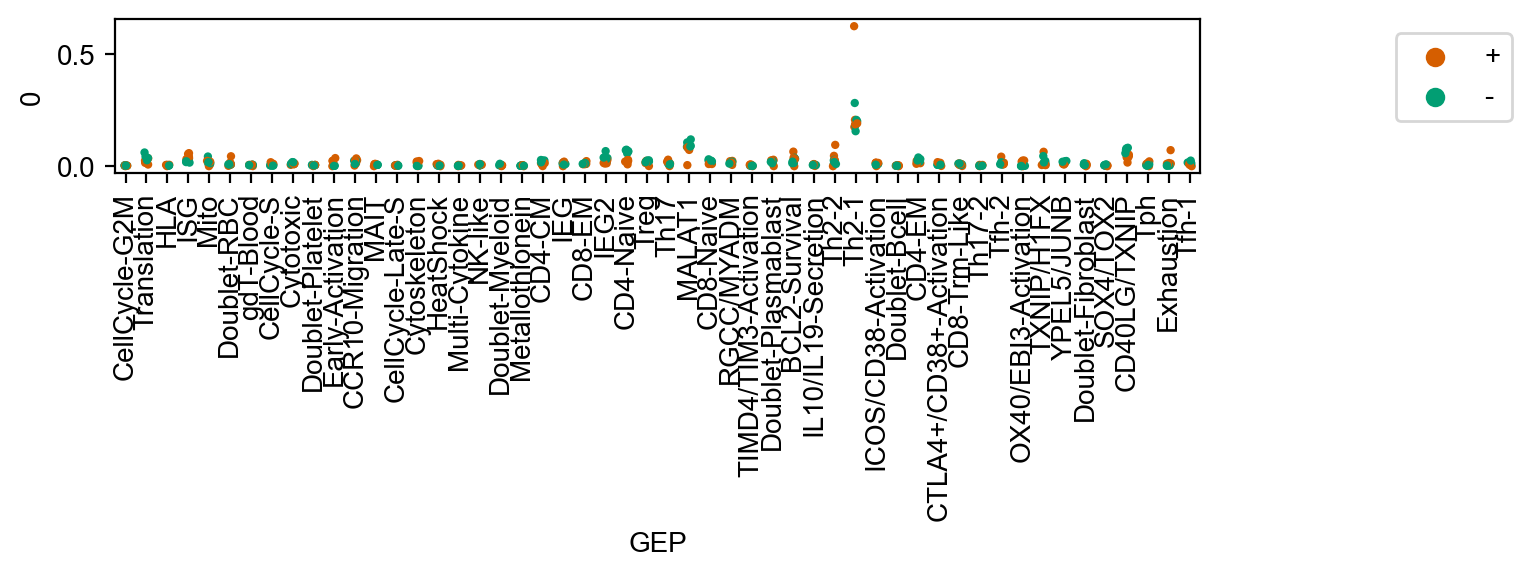

In [109]:
rf_usage_norm_annot_flat = rf_usage_norm_annot.loc[cd4_th2,:].groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat['GEP'] = rf_usage_norm_annot_flat['level_0'].replace(name_dict)
(fig,ax) = plt.subplots(1,1, figsize=(7,1), dpi=200)
sns.stripplot(x='GEP', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat,  s=3, palette=pal,
             hue_order=['+', '-'], order=rf_usage_norm_annot_ren.columns[:-3], ax=ax)

_ = ax.set_xticklabels(rf_usage_norm_annot_ren.columns[:-3], rotation=90)
ax.legend(bbox_to_anchor=(1.3, 1))

#rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['GEP'].isin(toplot),:]

['Early-Activation',
 'ISG',
 'BCL2-Survival',
 'Treg',
 'OX40/EBI3-Activation',
 'Cytoskeleton',
 'Th17',
 'ICOS/CD38-Activation',
 'Exhaustion',
 'RGCC/MYADM',
 'CCR10-Migration',
 'CellCycle-S',
 'Tfh-2',
 'CTLA4+/CD38+-Activation',
 'HeatShock',
 'Tph',
 'Multi-Cytokine',
 'TIMD4/TIM3-Activation',
 'Th17-2',
 'Th2-2',
 'Metallothionein',
 'CellCycle-Late-S',
 'CellCycle-G2M']

In [269]:
toplot

Index(['ICOS/CD38-Activation', 'Th17', 'Metallothionein', 'CellCycle-G2M',
       'Exhaustion', 'CTLA4+/CD38+-Activation', 'Cytoskeleton', 'HeatShock',
       'CellCycle-S', 'Early-Activation', 'OX40/EBI3-Activation',
       'Multi-Cytokine', 'RGCC/MYADM', 'ISG', 'CellCycle-Late-S', 'Tph',
       'CCR10-Migration', 'BCL2-Survival', 'Treg', 'TIMD4/TIM3-Activation',
       'Th2-2', 'Tfh-2', 'Th17-2'],
      dtype='object', name='renamed')

In [265]:
set(rf_usage_norm_annot_flat['GEP'].unique()).intersection(toplot)

{'BCL2-Survival',
 'CCR10-Migration',
 'CTLA4+/CD38+-Activation',
 'CellCycle-G2M',
 'CellCycle-Late-S',
 'CellCycle-S',
 'Cytoskeleton',
 'Early-Activation',
 'Exhaustion',
 'HeatShock',
 'ICOS/CD38-Activation',
 'ISG',
 'Metallothionein',
 'Multi-Cytokine',
 'OX40/EBI3-Activation',
 'RGCC/MYADM',
 'TIMD4/TIM3-Activation',
 'Tfh-2',
 'Th17',
 'Th17-2',
 'Th2-2',
 'Tph',
 'Treg'}

In [54]:
ind = (summary['P']<.01) &(summary['T']>0)
list(summary.loc[ind, 'renamed'])

['Th17',
 'HeatShock1',
 'CellCycle-S',
 'TNFRSF18+-Treg',
 'HeatShock2',
 'Cytoskeleton',
 'Metallothionein',
 'CTLA4+CD38+',
 'EBI3-Activation',
 'CellCycle-G2M',
 'IEG-Tissue',
 'High-Cytokine']

/tmp/ipykernel_54218/311072608.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.05).mean()).unstack().unstack().reset_index()
/tmp/ipykernel_54218/311072608.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)


Text(0.5, 1.0, 'TCR-Activation Associated GEPs')

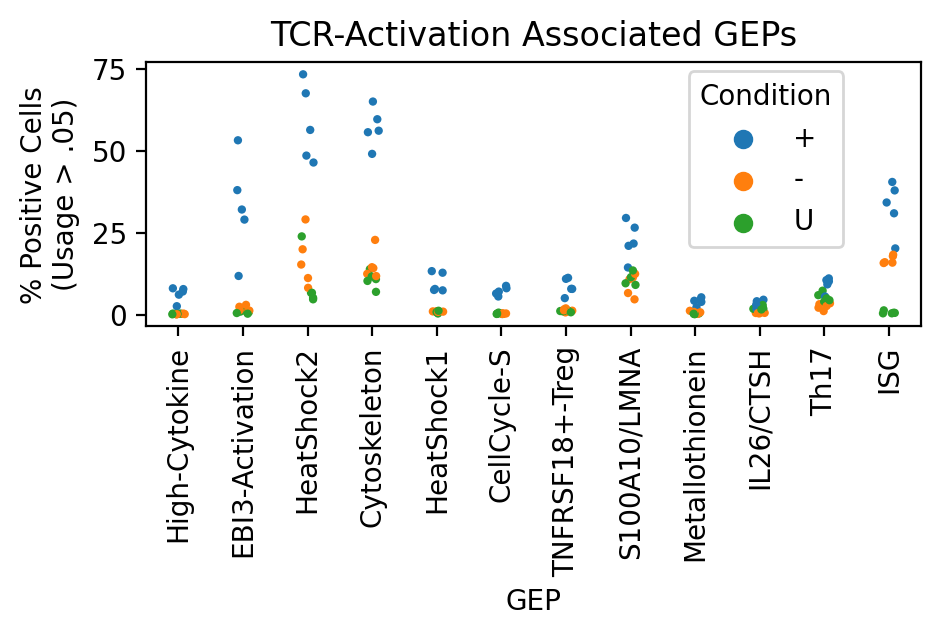

In [36]:
ind = (summary['P']<.05) & (summary['T']>0) & (summary['MeanPos']>0.01) & (summary['lograt']>np.log2(1.5))
toplot = list(summary.loc[ind, :].sort_values(by='lograt', ascending=False).index) + ['ISG']

rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.05).mean()).unstack().unstack().reset_index()
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['level_0'].isin(toplot),:]

(fig,ax) = plt.subplots(1,1, figsize=(5,4), dpi=200, gridspec_kw={'bottom':.55})
sns.stripplot(x='level_0', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=toplot, s=3)
ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)
ax.legend(loc=(.7,.3), title='Condition')
ax.set_xlabel('GEP', fontsize=10)
ax.set_ylabel('% Positive Cells\n(Usage > .05)', fontsize=10)
ax.set_title('TCR-Activation Associated GEPs', fontsize=12)
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.png'))
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.pdf'))

/tmp/ipykernel_54218/667793380.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.1).mean()).unstack().unstack().reset_index()
/tmp/ipykernel_54218/667793380.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)


Text(0.5, 1.0, 'TCR-Activation Associated GEPs')

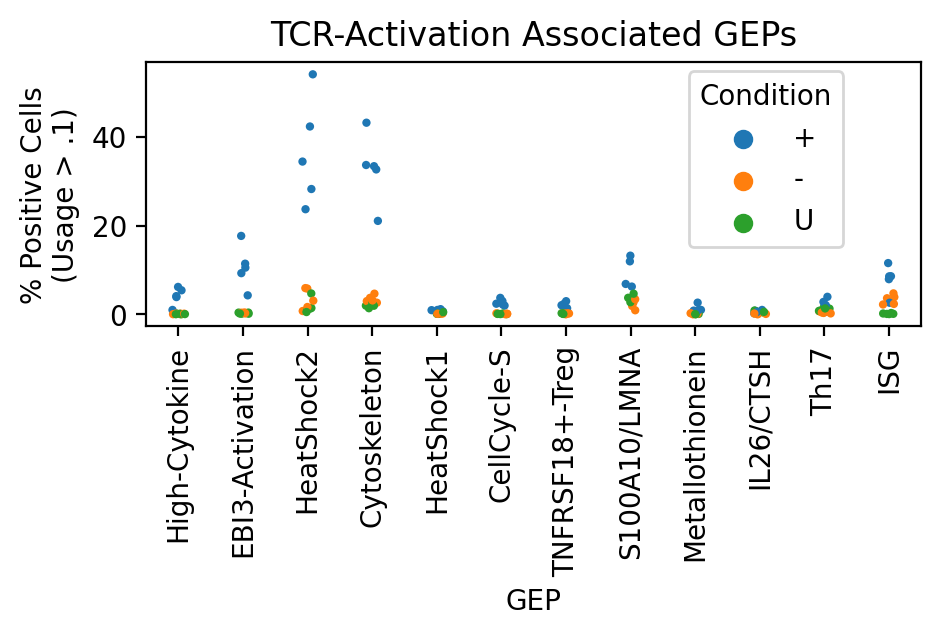

In [37]:
ind = (summary['P']<.05) & (summary['T']>0) & (summary['MeanPos']>0.01) & (summary['lograt']>np.log2(1.5))
toplot = list(summary.loc[ind, :].sort_values(by='lograt', ascending=False).index) + ['ISG']

rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.1).mean()).unstack().unstack().reset_index()
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['level_0'].isin(toplot),:]

(fig,ax) = plt.subplots(1,1, figsize=(5,4), dpi=200, gridspec_kw={'bottom':.55})
sns.stripplot(x='level_0', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=toplot, s=3)
ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)
ax.legend(loc=(.7,.3), title='Condition')
ax.set_xlabel('GEP', fontsize=10)
ax.set_ylabel('% Positive Cells\n(Usage > .1)', fontsize=10)
ax.set_title('TCR-Activation Associated GEPs', fontsize=12)
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.png'))
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.pdf'))

/tmp/ipykernel_54218/1444518009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_54218/1444518009.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


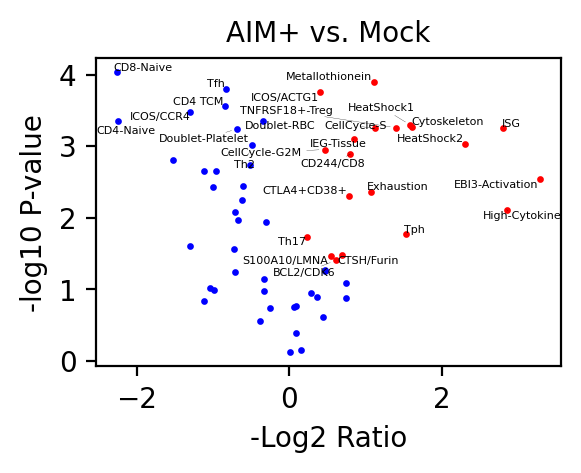

In [39]:
totest = rf_usage_norm_annot.loc[rf_usage_norm_annot['Sort_Status']!='-',:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('U', axis=0, level=1)
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. Mock', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.05) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

In [75]:
summary.head(15)['renamed'].values

array(['Th17', 'HeatShock1', 'CellCycle-S', 'TNFRSF18+-Treg',
       'HeatShock2', 'Cytoskeleton', 'Metallothionein', 'CTLA4+CD38+',
       'EBI3-Activation', 'CellCycle-G2M', 'IEG-Tissue', 'High-Cytokine',
       'Exhaustion', 'NK-Like-3', 'Tph'], dtype=object)

/tmp/ipykernel_53349/2994338576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/2994338576.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


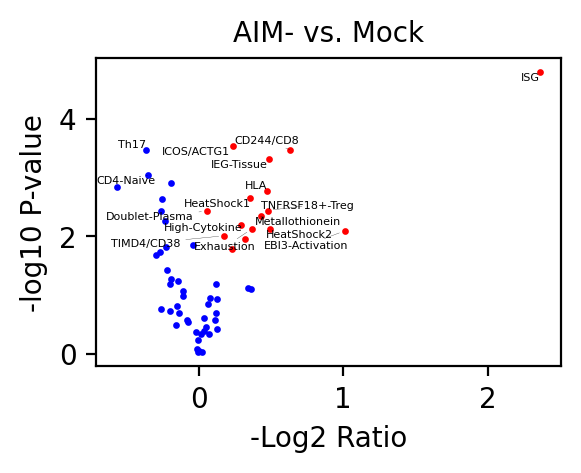

In [54]:
totest = rf_usage_norm_annot.loc[rf_usage_norm_annot['Sort_Status']!='+',:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('-', axis=0, level=1)
average_usage_neg = average_usage.xs('U', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM- vs. Mock', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.01) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

## Repeat after subsetting on CD4 memory

/tmp/ipykernel_53349/3780681386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/3780681386.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


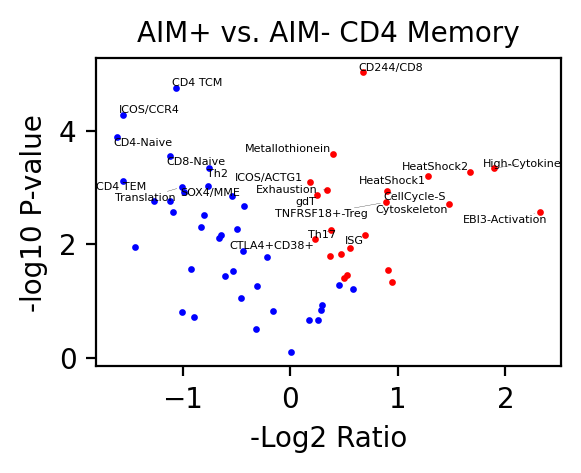

In [191]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['CD4_CM', 'CD4_EM', 'CD4_TEMRA'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- CD4 Memory', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.01) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

/tmp/ipykernel_53349/1119556912.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_53349/1119556912.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)


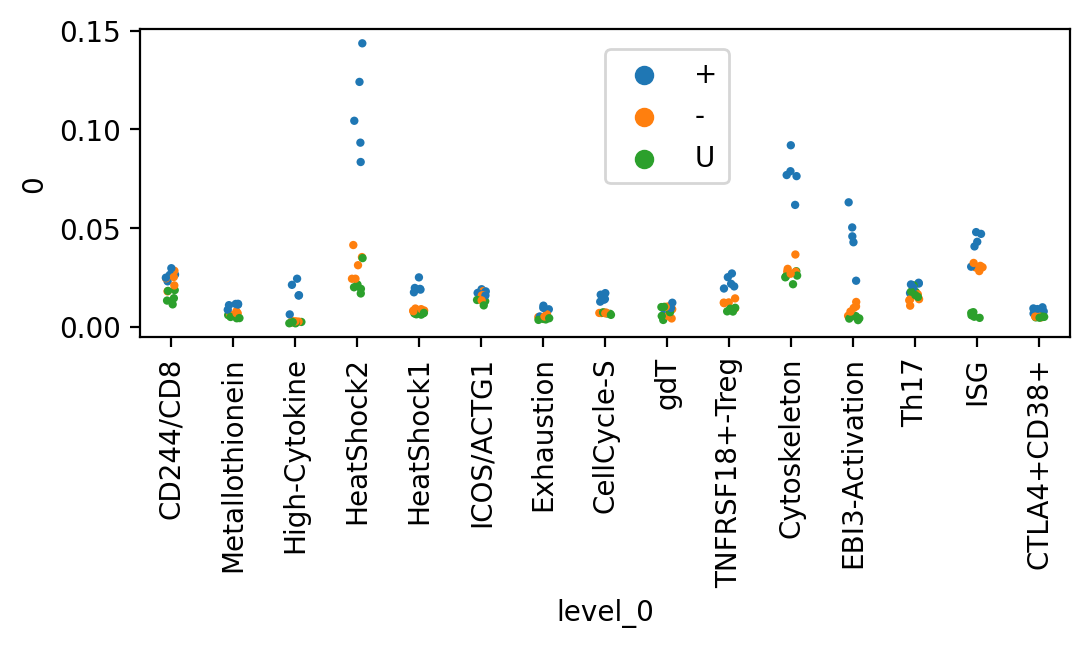

In [192]:
toplot = summary.head(15).index

rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['level_0'].isin(toplot),:]

(fig,ax) = plt.subplots(1,1, figsize=(6,2), dpi=200)
sns.stripplot(x='level_0', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=toplot, s=3)
ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)
ax.legend(loc=(.5,.5))



/tmp/ipykernel_53349/1476780415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/1476780415.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


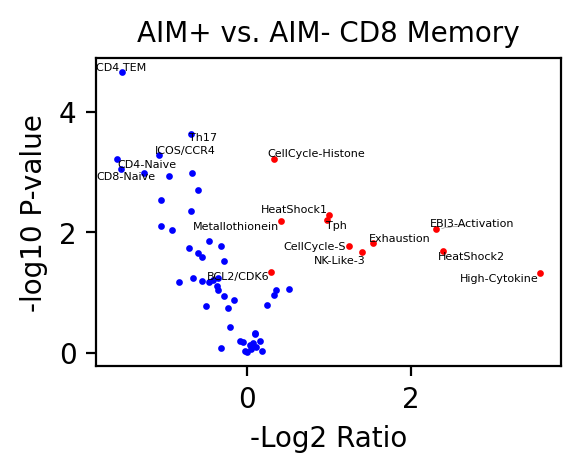

In [193]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['CD8_CM', 'CD8_EM', 'CD8_TEMRA'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- CD8 Memory', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.05) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

/tmp/ipykernel_53349/2563975046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/2563975046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


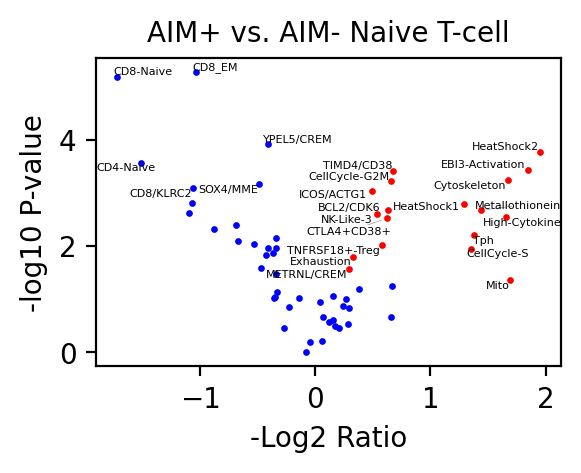

In [194]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['CD8_Naive', 'CD4_Naive'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- Naive T-cell', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.05) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

In [89]:
summary

P          T  \
CellCycle-Histone_CellCycle-Histone2_CellCycle_...  0.000602   9.822946   
HeatShock                                           0.005115   5.562625   
AMP-RA:Tph_Single                                   0.006224   5.267095   
Metallothionein                                     0.006514   5.200436   
EBI3                                                0.008793   4.777243   
Pan-Cancer:Tex_Single                               0.015239   4.068727   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B            0.016815   3.950208   
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5           0.020563   3.715065   
Pan-Tissue:NK-like_Single                           0.021271   3.676401   
?BCL2/CDK6_BCL2/CDK6                                0.044696   2.887042   
CytokineHigh_IL17A/IFNG_TNF/IFNG                    0.047032   2.836546   
Cytoskeleton                                        0.087615   2.250308   
IEG_IEG2                                            0.088893   2.237249   
Pan-Cancer:Treg/TNFRSF18_Single                     0.107278   2.069605   
CellCycle-G2M_CellCycle_G2M                         0.161607   1.714395   
AB_CD278/LGMN/IL21_LAG3/CD38                        0.456309   0.823855   
?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid  0.479174   0.779606   
Doublet_DC_HLA                                      0.640679   0.504118   
AB_CD86/TIMD4_dnT1/CD38                             0.677485   0.447792   
ISG                                                 0.722466   0.381158   
Tfh                                                 0.802353   0.267442   
Pan-Cancer:CTSH/FURIN_Single                        0.974653   0.033804   
KLRC2/GNLY_NK-like_gdT_gdT/Tk                       0.925596  -0.099409   
Th2                                                 0.913119  -0.116167   
PoorQuality_PoorQuality1                            0.869476  -0.175142   
Mito                                                0.833819  -0.223882   
Pan-Tissue:CD244+CD8_Single                         0.644818  -0.497693   
HIV-Vaccine:Doublet_Plasmablast_Single              0.639664  -0.505697   
?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory...  0.366524  -1.017332   
Treg                                                0.178022  -1.631970   
CD8_CD160high_CD8_class2_HLA                        0.166742  -1.687699   
?RGCC/MYADM/TNFAIP3_KLF6/CXCR4                      0.130238  -1.900004   
HIV-Vaccine:?NK-Like_Single                         0.114277  -2.013998   
?AB_CD278/ACTG1_AB_CD278/ACTG1                      0.091431  -2.211919   
AMP-RA_CD38_dnT_dnT/IL10+CD38+                      0.078427  -2.351029   
gdT                                                 0.067501  -2.489766   
Cytotoxic_TE                                        0.066821  -2.499244   
?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G          0.062811  -2.557396   
?SOX4/MME_SOX4/MME                                  0.061004  -2.585016   
Doublet_Bcell_Doublet_Plasmablast                   0.057727  -2.637562   
HIV-Vaccine:?KLRC2/GNLY_Single                      0.057661  -2.638657   
Doublet_RBC                                         0.030160  -3.291964   
IEG_IEG1_KLF6/CXCR4                                 0.025644  -3.467422   
IL26/CTSH_IL26/RORC/CTSH                            0.021570  -3.660565   
IEG2                                                0.018262  -3.852623   
Pan-Tissue:?METRNL/CREM/LDLRAD4_Single              0.016544  -3.969628   
YPEL5/CREM                                          0.013878  -4.183638   
?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK                 0.009130  -4.726194   
CD8A/GNLY_Memory                                    0.007695  -4.962098   
Doublet_Platelet                                    0.004406  -5.796025   
Pan-Tissue:?CH25H/DDIT4/SOCS3_Single                0.002852  -6.523228   
CRTH2/GATA3_KRT1/CCR4_Th2                           0.001959  -7.212699   
Doublet_Plasmablast                                 0.001181  -8.242976   
MAIT     

/tmp/ipykernel_53349/3181211915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/3181211915.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


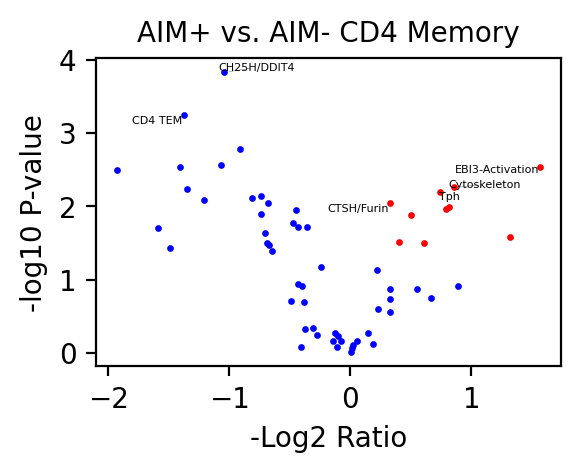

In [92]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['Treg'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- CD4 Memory', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.01) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

In [93]:
summary

P          T  \
EBI3                                                0.002905   6.490685   
Cytoskeleton                                        0.005493   5.453737   
AMP-RA:Tph_Single                                   0.006316   5.245732   
Pan-Cancer:CTSH/FURIN_Single                        0.009065   4.735810   
AB_CD278/LGMN/IL21_LAG3/CD38                        0.010317   4.562796   
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5           0.011045   4.473452   
HeatShock                                           0.013155   4.250338   
CytokineHigh_IL17A/IFNG_TNF/IFNG                    0.025985   3.452923   
AB_CD86/TIMD4_dnT1/CD38                             0.030561   3.277913   
IL26/CTSH_IL26/RORC/CTSH                            0.031542   3.244406   
Pan-Tissue:CD244+CD8_Single                         0.073788   2.407078   
Metallothionein                                     0.123833   1.943819   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B            0.132181   1.887176   
Pan-Cancer:Treg/TNFRSF18_Single                     0.134498   1.872141   
IEG_IEG2                                            0.176116   1.641123   
?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory...  0.181396   1.616012   
CD4_CM-2_PTPN13/TNFRSF4_Th17                        0.251620   1.338928   
Th2                                                 0.275329   1.262588   
PoorQuality_PoorQuality1                            0.530144   0.686466   
MAIT                                                0.676992   0.448535   
Pan-Tissue:NK-like_Single                           0.743626   0.350525   
?AB_CD278/ACTG1_AB_CD278/ACTG1                      0.785624   0.290849   
?RGCC/MYADM/TNFAIP3_KLF6/CXCR4                      0.982583  -0.023225   
Pan-Cancer:Tex_Single                               0.864816  -0.181480   
Doublet_Platelet                                    0.840261  -0.215032   
Doublet_DC_HLA                                      0.815837  -0.248704   
ISG                                                 0.696544  -0.419287   
Doublet_RBC                                         0.689425  -0.429886   
KLRC2/GNLY_NK-like_gdT_gdT/Tk                       0.579423  -0.602348   
?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid  0.567319  -0.622540   
CellCycle-G2M_CellCycle_G2M                         0.535139  -0.677697   
Doublet_Bcell_Doublet_Plasmablast                   0.466349  -0.804216   
Mito                                                0.450552  -0.835270   
AMP-RA_CD38_dnT_dnT/IL10+CD38+                      0.199734  -1.534333   
HIV-Vaccine:?NK-Like_Single                         0.193437  -1.561480   
gdT                                                 0.122373  -1.954147   
CRTH2/GATA3_KRT1/CCR4_Th2                           0.114545  -2.011941   
CellCycle-Histone_CellCycle-Histone2_CellCycle_...  0.066315  -2.506356   
?SOX4/MME_SOX4/MME                                  0.040347  -2.989786   
Tfh                                                 0.036757  -3.084860   
HIV-Vaccine:Doublet_Plasmablast_Single              0.033523  -3.180368   
?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G          0.031479  -3.246520   
CD8A/GNLY_Memory                                    0.022779  -3.598989   
Ribo_Translation                                    0.020026  -3.745476   
Cytotoxic_TE                                        0.018964  -3.808557   
IEG2                                                0.018954  -3.809179   
Pan-Tissue:?METRNL/CREM/LDLRAD4_Single              0.017138  -3.927558   
?BCL2/CDK6_BCL2/CDK6                                0.012842  -4.280508   
IEG_IEG1_KLF6/CXCR4                                 0.011144  -4.461868   
YPEL5/CREM                                          0.008962  -4.751402   
Doublet_Plasmablast                                 0.008294  -4.857589   
Treg                                                0.007784  -4.945922   
HIV-Vaccine:?KLRC2/GNLY_Single                      0.007162  -5.063762   
CD8_Naive

In [85]:
summary['renamed']

Pan-Tissue:CD244+CD8_Single                                               CD244/CD8
Metallothionein                                                     Metallothionein
CytokineHigh_IL17A/IFNG_TNF/IFNG                                      High-Cytokine
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                                HeatShock2
HeatShock                                                                HeatShock1
?AB_CD278/ACTG1_AB_CD278/ACTG1                                           ICOS/ACTG1
Pan-Cancer:Tex_Single                                                    Exhaustion
CellCycle-Sphase_CellCycle_S_DTL/FAM111B                                CellCycle-S
KLRC2/GNLY_NK-like_gdT_gdT/Tk                                                   gdT
Pan-Cancer:Treg/TNFRSF18_Single                                      TNFRSF18+-Treg
Cytoskeleton                                                           Cytoskeleton
EBI3                                                                EBI3-Act

In [61]:
rf_usage_norm_annot['lineage'].isin(['CD4_CM', 'CD4_EM', 'CD4_TEMRA'])

3_AAACCTGAGACCGGAT     True
3_AAACCTGAGAGGGCTT    False
3_AAACCTGAGAGTCTGG     True
3_AAACCTGAGCTAGCCC     True
3_AAACCTGAGCTGCCCA     True
                      ...  
2_TTTGTCATCAGGCCCA     True
2_TTTGTCATCATATCGG    False
2_TTTGTCATCATTATCC    False
2_TTTGTCATCGGCTACG    False
2_TTTGTCATCTCCAGGG    False
Name: lineage, Length: 43222, dtype: bool

In [ ]:
rf_usage_norm_annot = pd.concat([rf_usage_norm, query_adata.obs[['Manual_Gating', 'Sort_Status', 'Biobank_ID']]], axis=1)
res = []
res_costim = []
all_averages = []
for ct, ctusage in rf_usage_norm_annot.groupby('Manual_Gating'):
    ctusage_mean = ctusage.groupby(['Sort_Status', 'Biobank_ID']).mean().replace(np.nan, 0)
    ctusage_mean_flat = ctusage_mean.unstack().unstack().reset_index()
    ctusage_mean_flat.columns = ['GEP', 'IDV', 'Condition', 'Usage']
    ctusage_mean_flat['Celltype'] = ct
    all_averages.append(ctusage_mean_flat)
    
    for g in ctusage_mean.columns:
        H, P = ranksums(ctusage_mean.loc['+', g], ctusage_mean.loc[['-', 'U'], g])
        res.append([ct, g, H, P])
        H, P = ranksums(ctusage_mean.loc['U', g], ctusage_mean.loc[['-', '+'], g])
        res_costim.append([ct, g, H, P])        
        
        
res = pd.DataFrame(res, columns=['Celltype', 'gep', 'Z', 'P'])
res_costim = pd.DataFrame(res_costim, columns=['Celltype', 'gep', 'Z', 'P'])

all_averages = pd.concat(all_averages, axis=0)
all_averages = all_averages.loc[~all_averages['Celltype'].isin(['B', 'Myeloid']), :]
res.loc[~res['Celltype'].isin(['B', 'Myeloid']), :]
res_costim.loc[~res_costim['Celltype'].isin(['B', 'Myeloid']), :]

<AxesSubplot: ylabel='Manual_Gating'>

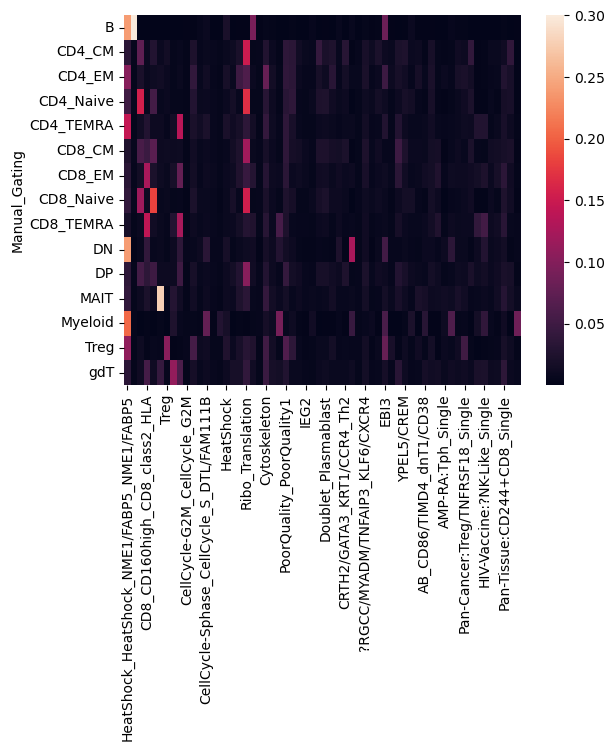

In [11]:
Z = rf_usage_norm.groupby(query_adata.obs['Manual_Gating']).mean()
order = ['HeatShock_HeatShock_NME1/FABP5_NME1/FABP5',
         'Doublet_Bcell_Doublet_Plasmablast',
         'CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive', 'CD8_CD160high_CD8_class2_HLA', 'CD8_Naive', 'MAIT', 'Treg', 'gdT', 
        'Cytotoxic_TE']
order += [x for x in Z.columns if x not in order]

sns.heatmap(Z.loc[:,order], vmax=0.3)

In [31]:
from scipy.stats import ranksums

In [108]:
rf_usage_norm_annot = pd.concat([rf_usage_norm, query_adata.obs[['Manual_Gating', 'Sort_Status', 'Biobank_ID']]], axis=1)
res = []
res_costim = []
all_averages = []
for ct, ctusage in rf_usage_norm_annot.groupby('Manual_Gating'):
    ctusage_mean = ctusage.groupby(['Sort_Status', 'Biobank_ID']).mean().replace(np.nan, 0)
    ctusage_mean_flat = ctusage_mean.unstack().unstack().reset_index()
    ctusage_mean_flat.columns = ['GEP', 'IDV', 'Condition', 'Usage']
    ctusage_mean_flat['Celltype'] = ct
    all_averages.append(ctusage_mean_flat)
    
    for g in ctusage_mean.columns:
        H, P = ranksums(ctusage_mean.loc['+', g], ctusage_mean.loc[['-', 'U'], g])
        res.append([ct, g, H, P])
        H, P = ranksums(ctusage_mean.loc['U', g], ctusage_mean.loc[['-', '+'], g])
        res_costim.append([ct, g, H, P])        
        
        
res = pd.DataFrame(res, columns=['Celltype', 'gep', 'Z', 'P'])
res_costim = pd.DataFrame(res_costim, columns=['Celltype', 'gep', 'Z', 'P'])

all_averages = pd.concat(all_averages, axis=0)
all_averages = all_averages.loc[~all_averages['Celltype'].isin(['B', 'Myeloid']), :]
res.loc[~res['Celltype'].isin(['B', 'Myeloid']), :]
res_costim.loc[~res_costim['Celltype'].isin(['B', 'Myeloid']), :]

Celltype                                       gep         Z         P
60    CD4_CM               CellCycle-G2M_CellCycle_G2M -0.979796  0.327187
61    CD4_CM                                       ISG -3.061862  0.002200
62    CD4_CM                                       gdT -0.612372  0.540291
63    CD4_CM                           Metallothionein -2.816913  0.004849
64    CD4_CM  CellCycle-Sphase_CellCycle_S_DTL/FAM111B  0.857321  0.391267
..       ...                                       ...       ...       ...
895      gdT    HIV-Vaccine:Doublet_Plasmablast_Single  1.102270  0.270344
896      gdT    Pan-Tissue:?METRNL/CREM/LDLRAD4_Single -0.367423  0.713303
897      gdT               Pan-Tissue:CD244+CD8_Single -2.449490  0.014306
898      gdT      Pan-Tissue:?CH25H/DDIT4/SOCS3_Single  1.102270  0.270344
899      gdT                 Pan-Tissue:NK-like_Single -0.122474  0.902523

[780 rows x 4 columns]

In [90]:
res.sort_values(by='P', ascending=True).head(10)

Celltype                                                gep         Z  \
795       Treg                                       Cytoskeleton  3.061862   
103     CD4_CM                                 ?SOX4/MME_SOX4/MME -3.061862   
102     CD4_CM                                         YPEL5/CREM -3.061862   
101     CD4_CM                          Effector_Memory_LYAR/GZMK -3.061862   
178     CD4_EM               Pan-Tissue:?CH25H/DDIT4/SOCS3_Single -3.061862   
180  CD4_Naive                        CellCycle-G2M_CellCycle_G2M  3.061862   
183  CD4_Naive                                    Metallothionein  3.061862   
864        gdT                                               IEG2 -3.061862   
184  CD4_Naive           CellCycle-Sphase_CellCycle_S_DTL/FAM111B  3.061862   
94      CD4_CM  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra... -3.061862   

          P  
795  0.0022  
103  0.0022  
102  0.0022  
101  0.0022  
178  0.0022  
180  0.0022  
183  0.0022  
864  0.0022  
184  0.0022  
94   0.0022

In [91]:
res.loc[res['Z']>0, :].sort_values(by='P', ascending=True).head(20)

Celltype                                        gep         Z       P
301     CD8_CM                                        ISG  3.061862  0.0022
367     CD8_EM                                  HeatShock  3.061862  0.0022
795       Treg                               Cytoskeleton  3.061862  0.0022
124     CD4_EM   CellCycle-Sphase_CellCycle_S_DTL/FAM111B  3.061862  0.0022
278  CD4_TEMRA                                       EBI3  3.061862  0.0022
262  CD4_TEMRA  HeatShock_HeatShock_NME1/FABP5_NME1/FABP5  3.061862  0.0022
243  CD4_TEMRA                            Metallothionein  3.061862  0.0022
237  CD4_Naive                Pan-Tissue:CD244+CD8_Single  3.061862  0.0022
229  CD4_Naive                      Pan-Cancer:Tex_Single  3.061862  0.0022
226  CD4_Naive             ?AB_CD278/ACTG1_AB_CD278/ACTG1  3.061862  0.0022
225  CD4_Naive                    AB_CD86/TIMD4_dnT1/CD38  3.061862  0.0022
218  CD4_Naive                                       EBI3  3.061862  0.0022
212  CD4_Naive           CytokineHigh_IL17A/IFNG_TNF/IFNG  3.061862  0.0022
202  CD4_Naive  HeatShock_HeatShock_NME1/FABP5_NME1/FABP5  3.061862  0.0022
61      CD4_CM                                        ISG  3.061862  0.0022
198  CD4_Naive              KLRC2/GNLY_NK-like_gdT_gdT/Tk  3.061862  0.0022
67      CD4_CM                                  HeatShock  3.061862  0.0022
195  CD4_Naive                               Cytoskeleton  3.061862  0.0022
127     CD4_EM                                  HeatShock  3.061862  0.0022
135     CD4_EM                               Cytoskeleton  3.061862  0.0022

/tmp/ipykernel_44566/20617627.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


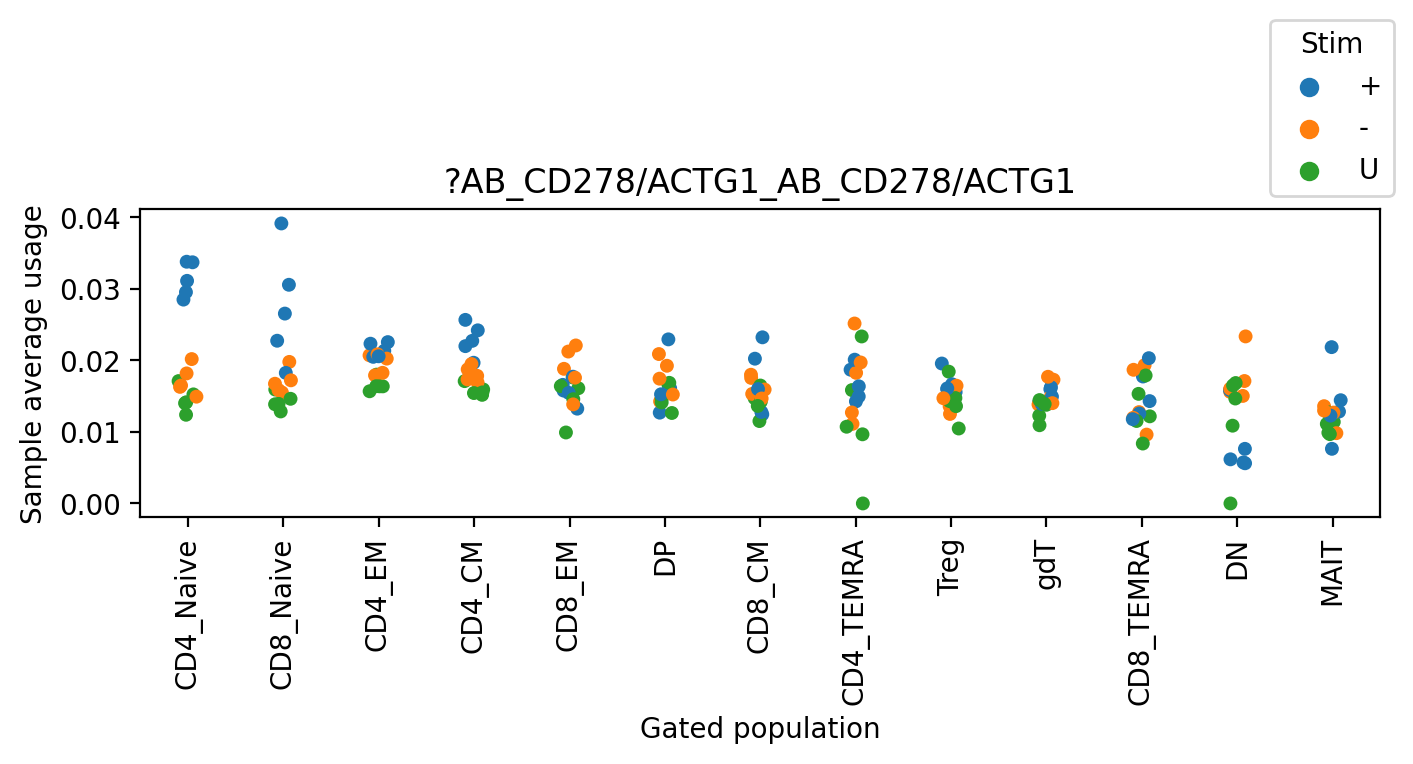

In [94]:
gep = '?AB_CD278/ACTG1_AB_CD278/ACTG1' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(.9,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/3406832750.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


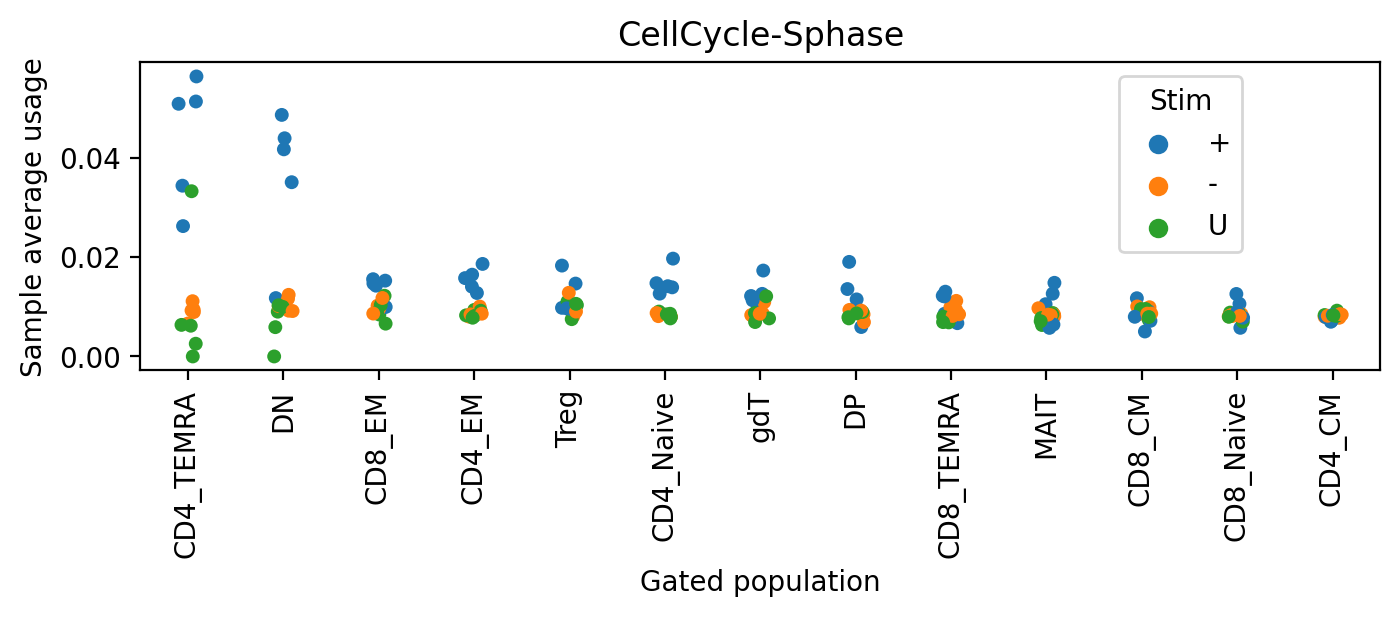

In [96]:
gep = 'CellCycle-Sphase_CellCycle_S_DTL/FAM111B' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep.split('_')[0])
ax.legend(bbox_to_anchor=(.9,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/806140850.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


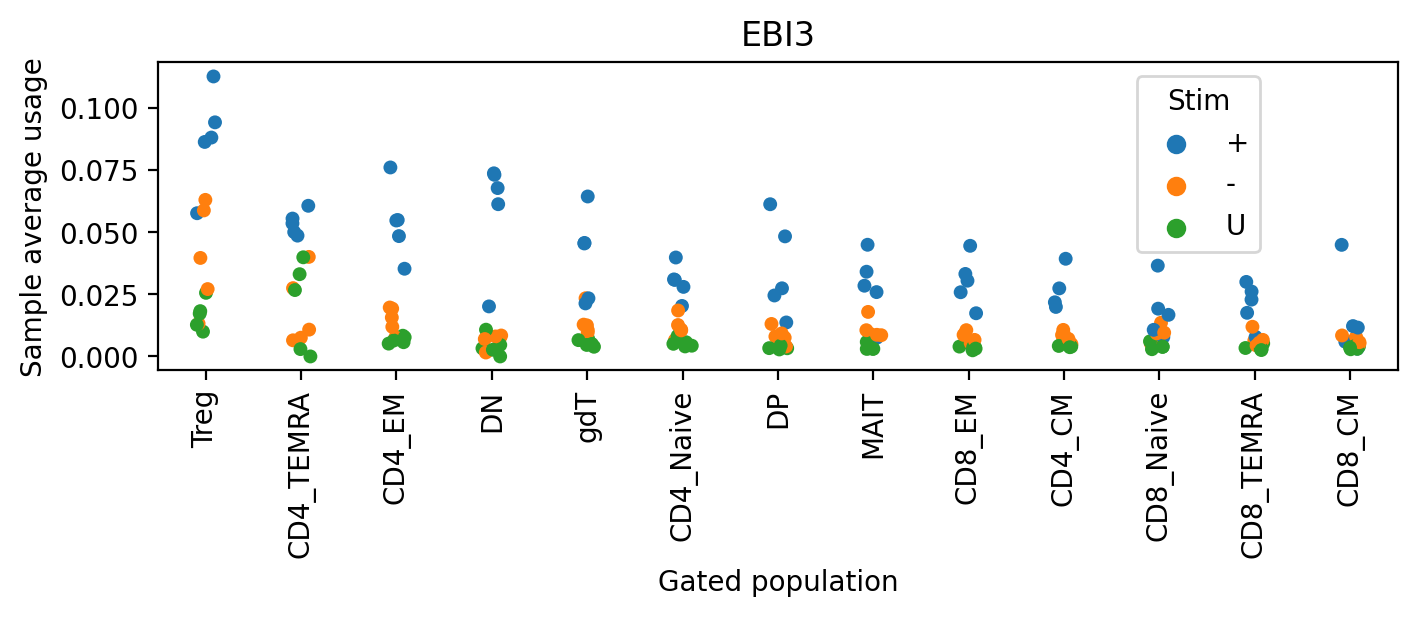

In [98]:
gep = 'EBI3' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(.9,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/844715558.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


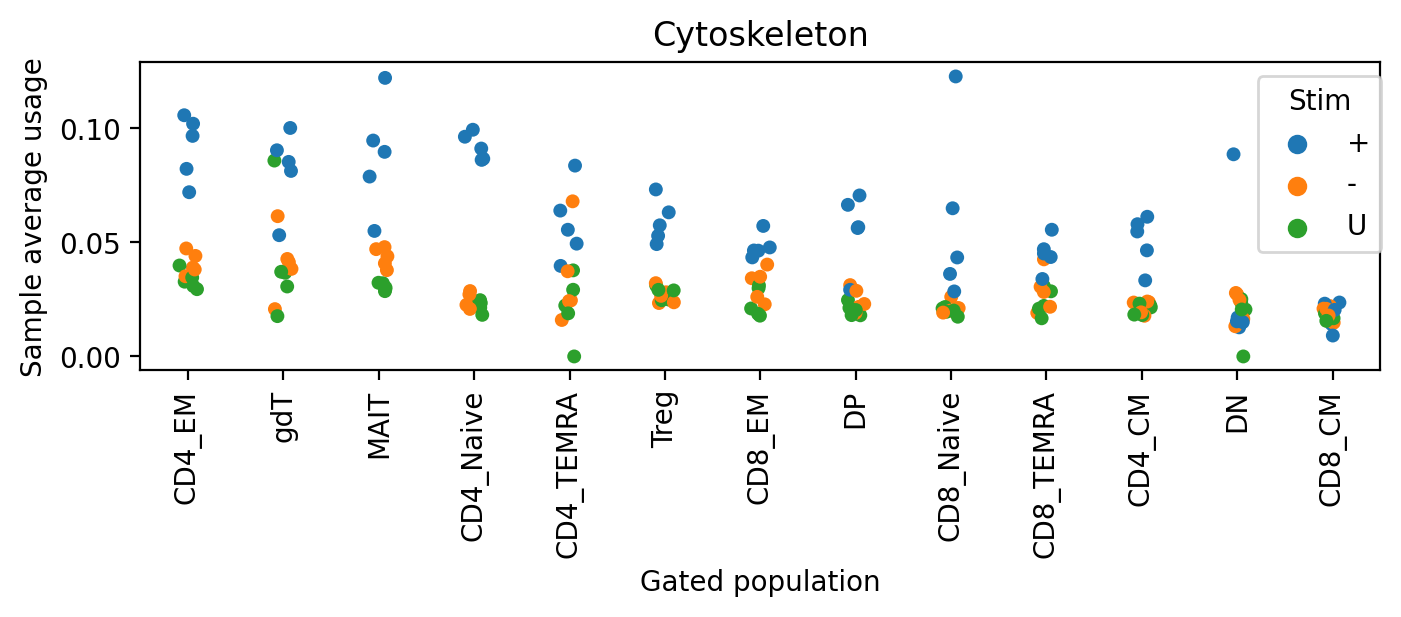

In [103]:
gep = 'Cytoskeleton' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(.89,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/1016044447.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


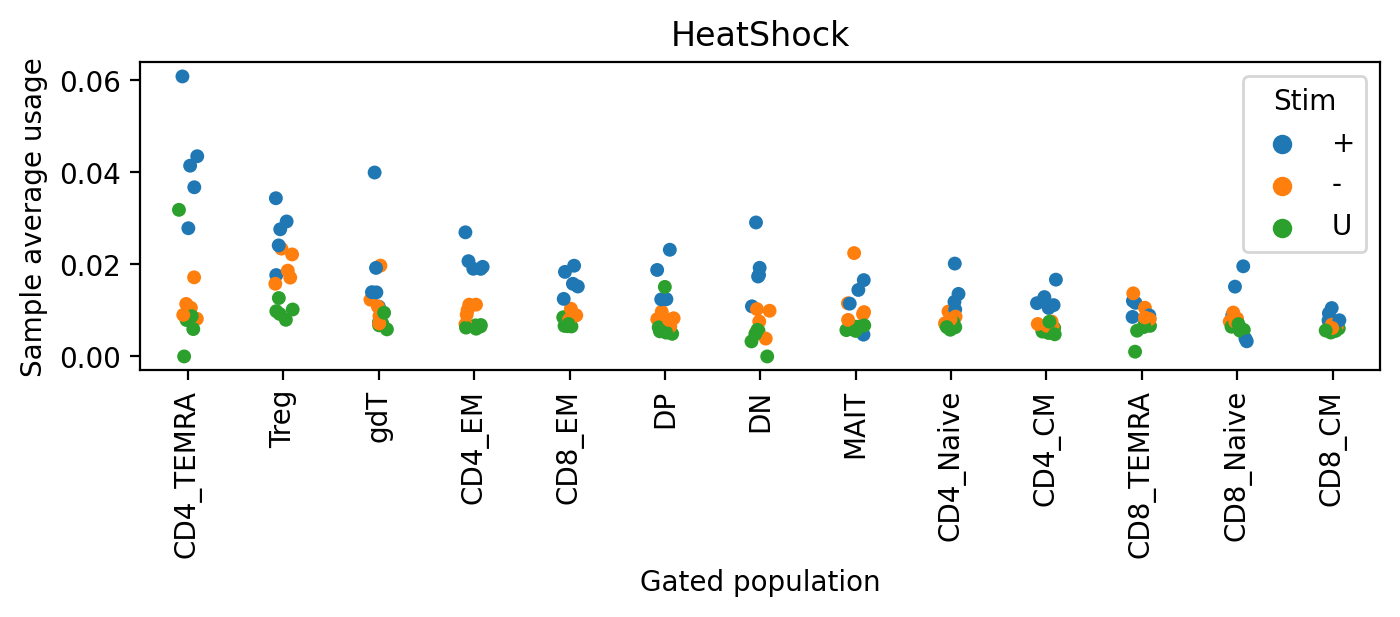

In [104]:
gep = 'HeatShock' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(1,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/2109853767.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


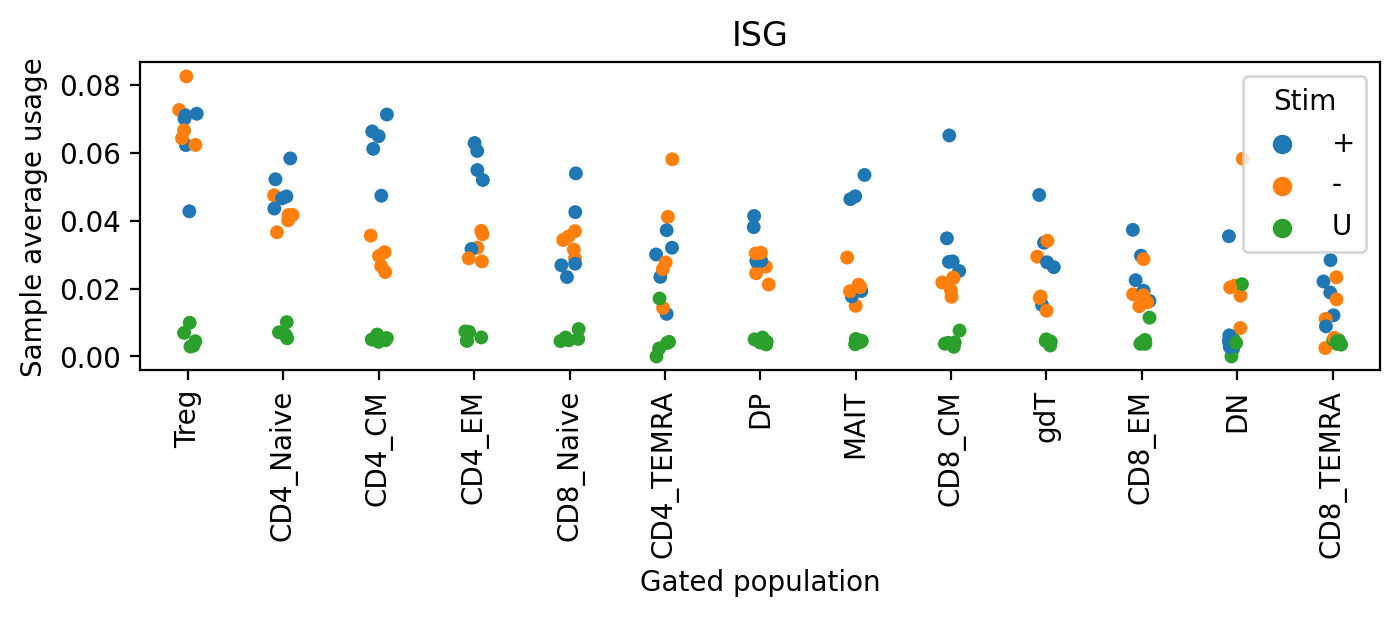

In [106]:
gep = 'ISG' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(1,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')


pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/1525888154.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


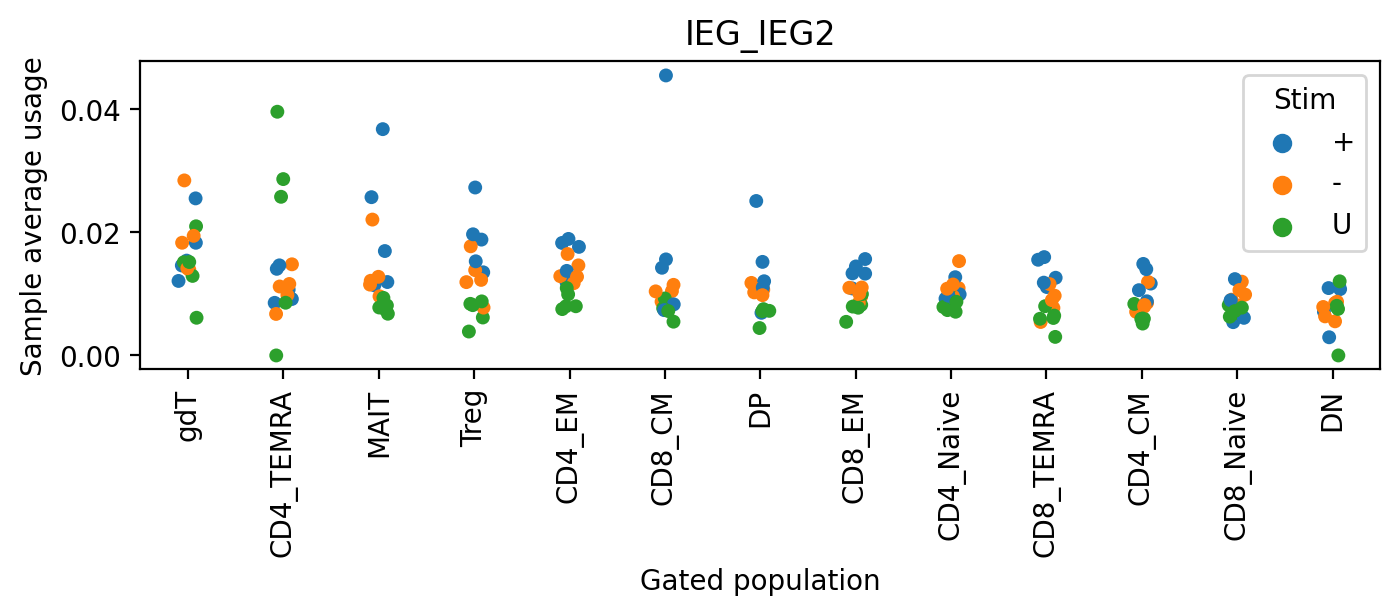

In [117]:
gep = 'IEG_IEG2' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(1,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')


pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

In [114]:
res_costim.sort_values(by='P').head(30)

Celltype                                                gep         Z  \
127     CD4_EM                                          HeatShock -3.061862   
382     CD8_EM          HeatShock_HeatShock_NME1/FABP5_NME1/FABP5 -3.061862   
141     CD4_EM                               ?BCL2/CDK6_BCL2/CDK6 -3.061862   
137     CD4_EM                                           IEG_IEG2 -3.061862   
136     CD4_EM                                               MAIT  3.061862   
214  CD4_Naive  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...  3.061862   
802       Treg          HeatShock_HeatShock_NME1/FABP5_NME1/FABP5 -3.061862   
454  CD8_Naive  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...  3.061862   
229  CD4_Naive                              Pan-Cancer:Tex_Single -3.061862   
361     CD8_EM                                                ISG -3.061862   
121     CD4_EM                                                ISG -3.061862   
117     CD4_CM                        Pan-Tissue:CD244+CD8_Single -3.061862   
237  CD4_Naive                        Pan-Tissue:CD244+CD8_Single -3.061862   
330     CD8_CM                     AMP-RA_CD38_dnT_dnT/IL10+CD38+  3.061862   
115     CD4_CM             HIV-Vaccine:Doublet_Plasmablast_Single  3.061862   
675       MAIT                                       Cytoskeleton -3.061862   
61      CD4_CM                                                ISG -3.061862   
781       Treg                                                ISG -3.061862   
814       Treg  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...  3.061862   
690       MAIT                     AMP-RA_CD38_dnT_dnT/IL10+CD38+  3.061862   
677       MAIT                                           IEG_IEG2 -3.061862   
841        gdT                                                ISG -3.061862   
301     CD8_CM                                                ISG -3.061862   
787       Treg                                          HeatShock -3.061862   
73      CD4_CM                                     Doublet_DC_HLA -3.061862   
812       Treg                   CytokineHigh_IL17A/IFNG_TNF/IFNG -3.061862   
792       Treg                                               Treg  3.061862   
698       MAIT                                               EBI3 -3.061862   
837       Treg                        Pan-Tissue:CD244+CD8_Single -3.061862   
181  CD4_Naive                                                ISG -3.061862   

          P  
127  0.0022  
382  0.0022  
141  0.0022  
137  0.0022  
136  0.0022  
214  0.0022  
802  0.0022  
454  0.0022  
229  0.0022  
361  0.0022  
121  0.0022  
117  0.0022  
237  0.0022  
330  0.0022  
115  0.0022  
675  0.0022  
61   0.0022  
781  0.0022  
814  0.0022  
690  0.0022  
677  0.0022  
841  0.0022  
301  0.0022  
787  0.0022  
73   0.0022  
812  0.0022  
792  0.0022  
698  0.0022  
837  0.0022  
181  0.0022

In [23]:
ctusage.groupby(query_adata.obs.loc[ctusage.index, ['Sort_Status', 'Biobank_ID']]).mean()

ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional

In [18]:
ctusage

CellCycle-G2M_CellCycle_G2M           ISG           gdT  \
3_AAAGATGAGAGGTACC                 3.830878e-04  8.616138e-05  2.480817e-05   
3_ACCTTTAGTGTAATGA                 1.414043e-05  9.438384e-06  2.063477e-07   
3_ACTGCTCCAACGCACC                 3.277263e-03  3.670183e-03  3.058715e-04   
3_AGAGCGAAGCCTCGTG                 9.104401e-10  1.270513e-10  1.004466e-09   
3_AGAGCTTGTCTAGAGG                 3.382738e-04  4.637917e-04  3.553408e-05   
...                                         ...           ...           ...   
4_TGCTACCCACCTATCC                 3.514746e-03  4.754730e-04  2.330045e-04   
4_TGGCCAGGTCTTGATG                 3.052875e-03  2.357927e-04  7.343159e-05   
4_TGTGTTTGTCAGAATA                 6.784318e-05  2.269013e-06  4.159017e-06   
4_TTCGGTCTCATCGCTC                 3.690695e-04  1.493598e-04  7.313380e-05   
4_TTGACTTCACGCGAAA                 2.735847e-04  2.499056e-06  2.001843e-05   

                    Metallothionein  CellCycle-Sphase_CellCycle_S_DTL/FAM111B  \
3_AAAGATGAGAGGTACC     1.367540e-04                              1.446426e-02   
3_ACCTTTAGTGTAATGA     7.121246e-07                              3.222157e-06   
3_ACTGCTCCAACGCACC     5.823454e-04                              7.021951e-03   
3_AGAGCGAAGCCTCGTG     6.989653e-09                              5.638214e-09   
3_AGAGCTTGTCTAGAGG     4.558749e-03                              1.146633e-03   
...                             ...                                       ...   
4_TGCTACCCACCTATCC     4.925166e-03                              1.061419e-02   
4_TGGCCAGGTCTTGATG     7.272889e-04                              2.628233e-02   
4_TGTGTTTGTCAGAATA     2.466362e-05                              2.319316e-04   
4_TTCGGTCTCATCGCTC     1.238963e-02                              8.460876e-03   
4_TTGACTTCACGCGAAA     1.549095e-04                              3.552735e-03   

                     Doublet_RBC  \
3_AAAGATGAGAGGTACC  4.820877e-05   
3_ACCTTTAGTGTAATGA  3.288167e-07   
3_ACTGCTCCAACGCACC  5.894002e-04   
3_AGAGCGAAGCCTCGTG  1.277554e-08   
3_AGAGCTTGTCTAGAGG  3.905025e-05   
...                          ...   
4_TGCTACCCACCTATCC  4.767339e-04   
4_TGGCCAGGTCTTGATG  1.845728e-04   
4_TGTGTTTGTCAGAATA  1.083523e-05   
4_TTCGGTCTCATCGCTC  3.182410e-04   
4_TTGACTTCACGCGAAA  5.789463e-05   

                    CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone  \
3_AAAGATGAGAGGTACC                                       1.041786e-03        
3_ACCTTTAGTGTAATGA                                       9.957748e-07        
3_ACTGCTCCAACGCACC                                       2.512479e-03        
3_AGAGCGAAGCCTCGTG                                       2.368753e-09        
3_AGAGCTTGTCTAGAGG                                       2.670520e-04        
...                                                               ...        
4_TGCTACCCACCTATCC                                       2.381967e-03        
4_TGGCCAGGTCTTGATG                                       1.812652e-03        
4_TGTGTTTGTCAGAATA                                       1.059197e-04        
4_TTCGGTCTCATCGCTC                                       4.357425e-04        
4_TTGACTTCACGCGAAA                                       3.049974e-04        

                       HeatShock          Mito  \
3_AAAGATGAGAGGTACC  1.601785e-03  1.563120e-09   
3_ACCTTTAGTGTAATGA  7.125690e-06  1.280352e-12   
3_ACTGCTCCAACGCACC  3.435472e-02  1.231988e-09   
3_AGAGCGAAGCCTCGTG  4.666047e-11  5.336048e-14   
3_AGAGCTTGTCTAGAGG  7.002615e-03  1.854949e-11   
...                          ...           ...   
4_TGCTACCCACCTATCC  9.761201e-03  7.731225e-09   
4_TGGCCAGGTCTTGATG  3.254269e-02  2.858824e-10   
4_TGTGTTTGTCAGAATA  2.908612e-04  5.920163e-11   
4_TTCGGTCTCATCGCTC  2.288070e-02  2.233300e-09   
4_TTGACTTCACGCGAAA  7.721058e-03  2.159475e-09   

                    ?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory_LGALS1/S100A10  \
3_AAAGATGAGAGGTACC                       

In [21]:
query_adata.obs.columns

Index(['barcode', 'BRI', 'Run', 'Well', 'Batch', 'Biobank_ID', 'Sort_Status',
       'HTO_Status', 'Demuxlet_Assignment', 'Total_RNA_Count',
       'Total_ADT_Count', 'Total_HTO_Count', 'frac_ADT', 'A_cdr3', 'B_cdr3',
       'DEMUX_RD.UNIQ', 'DEMUX_N.SNP', 'DEMUX_BEST', 'DEMUX_SNG.1ST',
       'DEMUX_SNG.LLK1', 'DEMUX_DBL.1ST', 'DEMUX_DBL.2ND', 'DEMUX_LLK12',
       'DEMUX_PRB.DBL', 'DEMUX_PRB.SNG1', 'batch_name', 'B_is_cell',
       'B_high_confidence', 'B_full_length', 'B_productive', 'B_length',
       'B_v_gene', 'B_d_gene', 'B_j_gene', 'B_c_gene', 'B_cdr1', 'B_cdr2',
       'B_cdr3_nt', 'B_reads', 'B_umis', 'B_raw_clonotype_id',
       'B_raw_consensus_id', 'B_Num_Hits_In_Barcode',
       'B_Next_Highest_ReadCount', 'B_Num_Productive_In_Barcode',
       'B_Has_Unproductive', 'A_is_cell', 'A_high_confidence', 'A_full_length',
       'A_productive', 'A_length', 'A_v_gene', 'A_d_gene', 'A_j_gene',
       'A_c_gene', 'A_cdr1', 'A_cdr2', 'A_cdr3_nt', 'A_reads', 'A_umis',
       'A_raw_

In [130]:
Z.loc['CD3_NAi', :].sort_values(ascending=False)

CD8_CD160high_CD8_class2_HLA                                      0.141742
Cytotoxic_TE                                                      0.124082
KLRC2/GNLY_NK-like_gdT_gdT/Tk                                     0.055458
HIV-Vaccine:?NK-Like_Single                                       0.052841
HIV-Vaccine:?KLRC2/GNLY_Single                                    0.039501
Pan-Tissue:CD244+CD8_Single                                       0.032551
Cytoskeleton                                                      0.030916
Ribo_Translation                                                  0.028734
gdT                                                               0.028153
Doublet_DC_HLA                                                    0.025786
CD8A/GNLY_Memory                                                  0.025267
PoorQuality_PoorQuality1                                          0.023471
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                         0.018559
Effector_Memory_LYAR/GZMK

In [ ]:
lineages = ['CellCycle-G2M_CellCycle_G2M', 'ISG', 'gdT', 'Metallothionein',
       'CellCycle-Sphase_CellCycle_S_DTL/FAM111B', 'Doublet_RBC',
       'CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone', 'HeatShock',
       'Mito',
       '?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory_LGALS1/S100A10',
       'Ribo_Translation', 'Cytotoxic_TE', 'Treg', 'Doublet_DC_HLA',
       'Doublet_Platelet', 'Cytoskeleton', 'MAIT', 'IEG_IEG2',
       'KLRC2/GNLY_NK-like_gdT_gdT/Tk', 'CD8_CD160high_CD8_class2_HLA',
       'PoorQuality_PoorQuality1', '?BCL2/CDK6_BCL2/CDK6',
       'HeatShock_HeatShock_NME1/FABP5_NME1/FABP5', 'IEG_IEG1_KLF6/CXCR4',
       'IEG2', '?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid',
       'CD8_Naive', '?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK',
       'Doublet_Plasmablast', 'CD4_CM-2_PTPN13/TNFRSF4_Th17',
       'AMP-RA_CD38_dnT_dnT/IL10+CD38+', 'CRTH2/GATA3_KRT1/CCR4_Th2',
       'CytokineHigh_IL17A/IFNG_TNF/IFNG', 'Th2',
       'CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive',
       '?RGCC/MYADM/TNFAIP3_KLF6/CXCR4',
       '?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G', 'Tfh', 'EBI3',
       'Doublet_Bcell_Doublet_Plasmablast', 'AB_CD278/LGMN/IL21_LAG3/CD38',
       'Effector_Memory_LYAR/GZMK', 'YPEL5/CREM', '?SOX4/MME_SOX4/MME',
       'IL26/CTSH_IL26/RORC/CTSH', 'AB_CD86/TIMD4_dnT1/CD38',
       '?AB_CD278/ACTG1_AB_CD278/ACTG1', 'CD8A/GNLY_Memory',
       'AMP-RA:Tph_Single', 'Pan-Cancer:Tex_Single',
       'Pan-Cancer:CTSH/FURIN_Single', 'Pan-Cancer:Treg/TNFRSF18_Single',
       'TBRU:ICOS/CCR4_Single', 'HIV-Vaccine:?KLRC2/GNLY_Single',
       'HIV-Vaccine:?NK-Like_Single', 'HIV-Vaccine:Doublet_Plasmablast_Single',
       'Pan-Tissue:?METRNL/CREM/LDLRAD4_Single', 'Pan-Tissue:CD244+CD8_Single',
       'Pan-Tissue:?CH25H/DDIT4/SOCS3_Single', 'Pan-Tissue:NK-like_Single']

In [55]:
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

In [62]:
(rf_usage_norm>.1).sum(axis=0).sort_values(ascending=True)

?AB_CD278/ACTG1_AB_CD278/ACTG1                                        5
CellCycle-G2M_CellCycle_G2M                                           6
Doublet_RBC                                                          14
AMP-RA:Tph_Single                                                    21
IEG2                                                                 25
CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone               29
Doublet_Platelet                                                     37
Doublet_Plasmablast                                                  42
HIV-Vaccine:Doublet_Plasmablast_Single                               47
IEG_IEG1_KLF6/CXCR4                                                  47
Pan-Tissue:NK-like_Single                                            48
?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G                           55
AB_CD86/TIMD4_dnT1/CD38                                              56
YPEL5/CREM                                                      

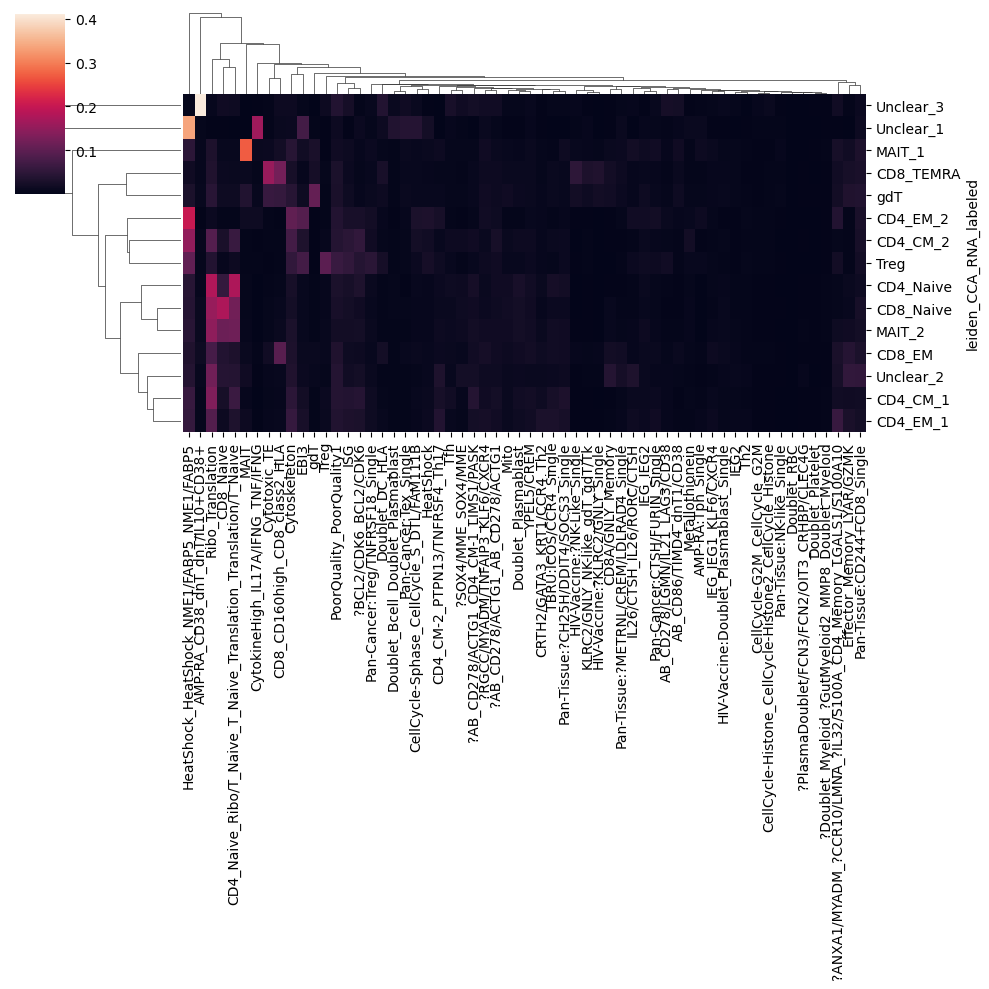

In [64]:
sns.clustermap(rf_usage_norm.groupby(query_adata.obs['leiden_CCA_RNA_labeled']).mean(), xticklabels=True, yticklabels=True)

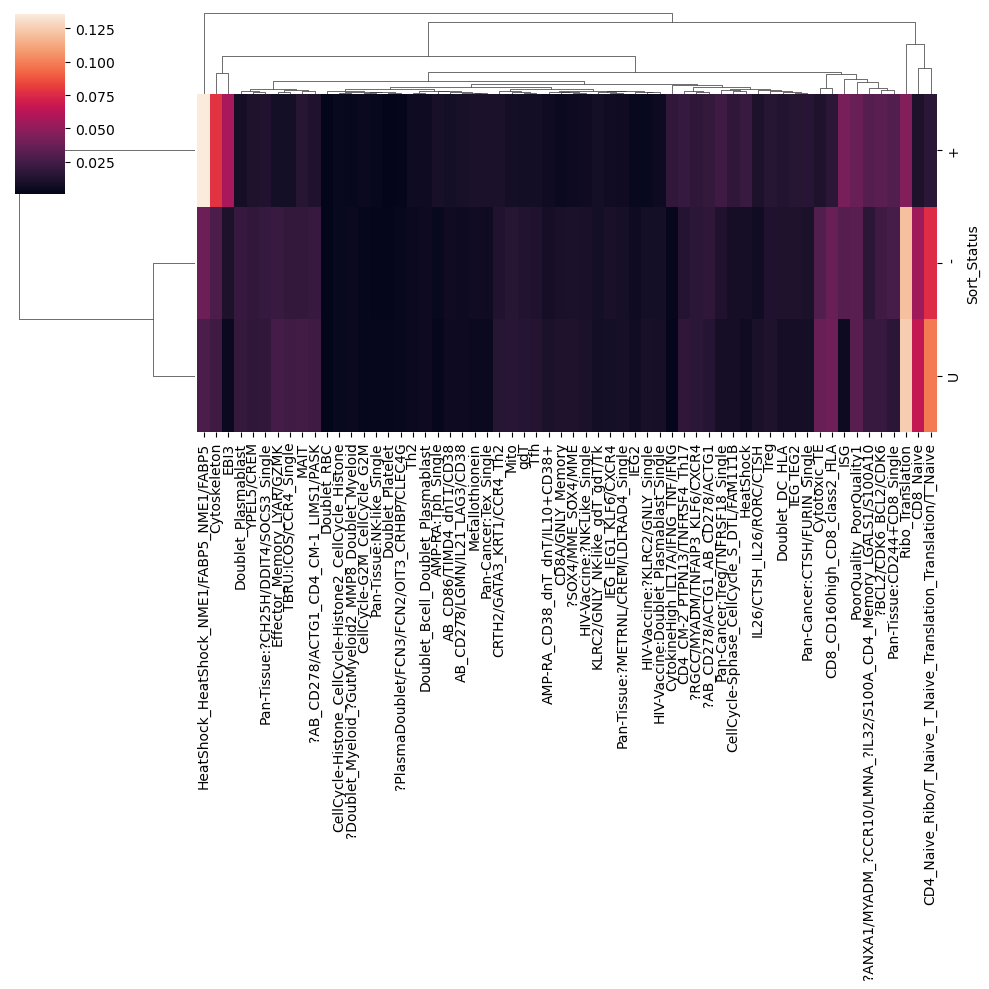

In [65]:
sns.clustermap(rf_usage_norm.groupby(query_adata.obs['Sort_Status']).mean(), xticklabels=True)

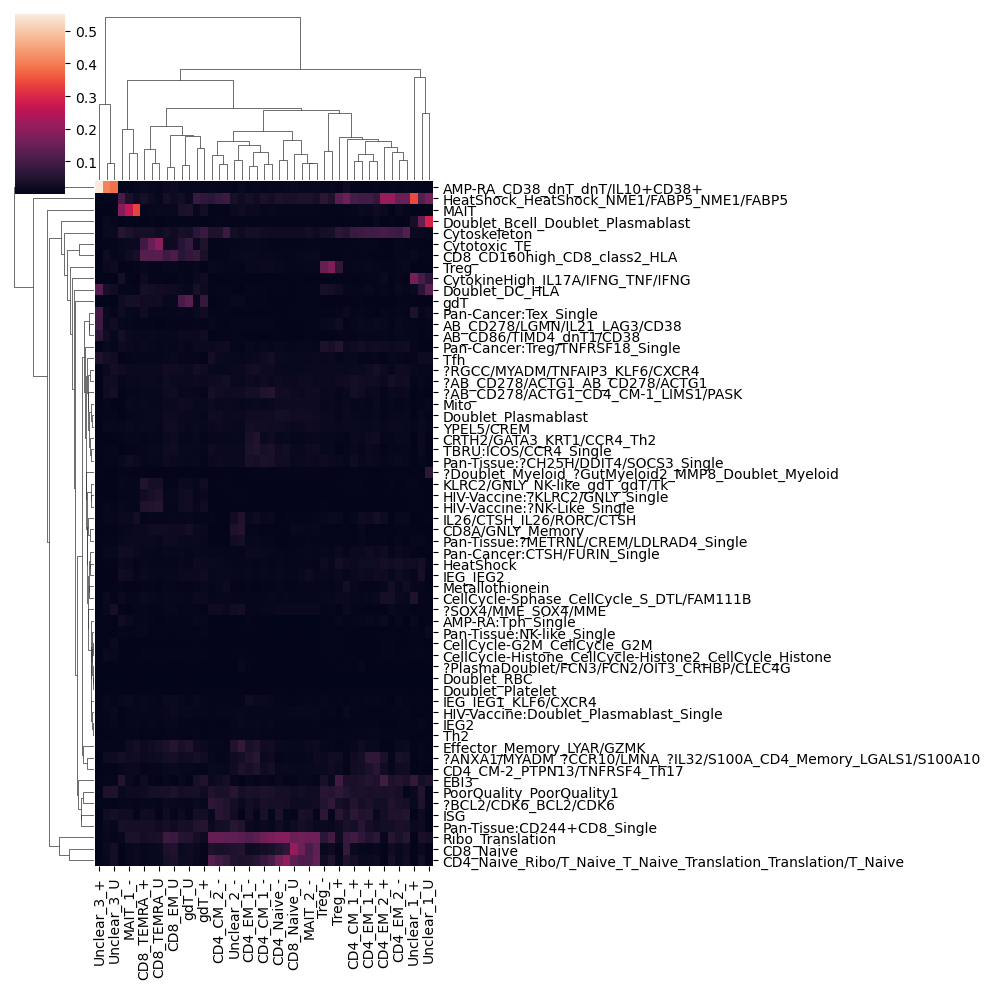

In [75]:
lab = query_adata.obs['leiden_CCA_RNA_labeled'].astype(str) + '_' + query_adata.obs['Sort_Status'].astype(str)
sns.clustermap(rf_usage_norm.groupby(lab).mean().T, yticklabels=True)

In [71]:
query_adata.obs['leiden_CCA_RNA_labeled'].astype(str) + '_' + query_adata.obs['Sort_Status'].astype(str)

3_AAACCTGAGAGGGCTT    CD4_Naive_U
3_AAACCTGAGAGTCTGG     CD4_EM_2_+
3_AAACCTGAGCTAGCCC     CD4_CM_1_U
3_AAACCTGAGCTGCCCA     CD4_EM_1_+
3_AAACCTGAGGCTCATT     CD4_EM_2_+
                         ...     
2_TTTGTCAGTTCCACTC         Treg_+
2_TTTGTCATCAGGCCCA     CD4_CM_1_U
2_TTTGTCATCATATCGG    CD8_TEMRA_+
2_TTTGTCATCATTATCC    CD8_Naive_-
2_TTTGTCATCTCCAGGG          gdT_-
Length: 40661, dtype: object

Text(0, 0.5, 'Score')

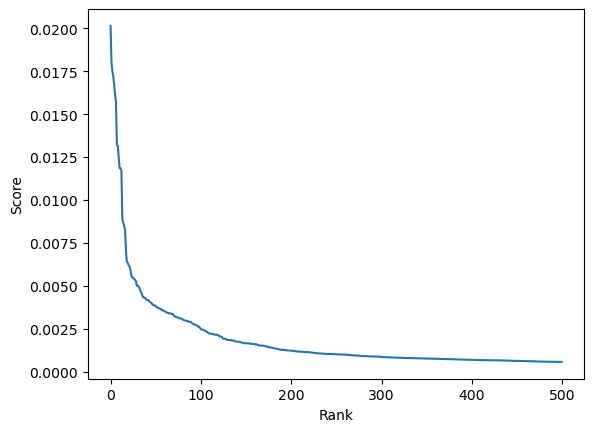

In [148]:
z = pd.read_csv('/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/XTissueImmuneAtlas/T_Script_AllT_XTissue_20220824/T_Script_AllT_XTissue_20220824.gene_spectra_score.k_49.dt_0_2.labeled.txt', sep='\t', index_col=0)['IEG'].sort_values(ascending=False)
plt.plot(np.arange(500), z.values[:500])
plt.xlabel('Rank')
plt.ylabel('Score')

In [147]:
z.to_csv('ieg.tsv', sep='\t')

In [14]:
query_adata

AnnData object with n_obs × n_vars = 40661 × 36738
    obs: 'barcode', 'BRI', 'Run', 'Well', 'Batch', 'Biobank_ID', 'Sort_Status', 'HTO_Status', 'Demuxlet_Assignment', 'Total_RNA_Count', 'Total_ADT_Count', 'Total_HTO_Count', 'frac_ADT', 'A_cdr3', 'B_cdr3', 'DEMUX_RD.UNIQ', 'DEMUX_N.SNP', 'DEMUX_BEST', 'DEMUX_SNG.1ST', 'DEMUX_SNG.LLK1', 'DEMUX_DBL.1ST', 'DEMUX_DBL.2ND', 'DEMUX_LLK12', 'DEMUX_PRB.DBL', 'DEMUX_PRB.SNG1', 'batch_name', 'B_is_cell', 'B_high_confidence', 'B_full_length', 'B_productive', 'B_length', 'B_v_gene', 'B_d_gene', 'B_j_gene', 'B_c_gene', 'B_cdr1', 'B_cdr2', 'B_cdr3_nt', 'B_reads', 'B_umis', 'B_raw_clonotype_id', 'B_raw_consensus_id', 'B_Num_Hits_In_Barcode', 'B_Next_Highest_ReadCount', 'B_Num_Productive_In_Barcode', 'B_Has_Unproductive', 'A_is_cell', 'A_high_confidence', 'A_full_length', 'A_productive', 'A_length', 'A_v_gene', 'A_d_gene', 'A_j_gene', 'A_c_gene', 'A_cdr1', 'A_cdr2', 'A_cdr3_nt', 'A_reads', 'A_umis', 'A_raw_clonotype_id', 'A_raw_consensus_id', 'A_Num_H

gene_sybmol            gene_name  \
gene_sybmol                                                     
ENSG00000000003          ENSG00000000003               TSPAN6   
ENSG00000000005          ENSG00000000005                 TNMD   
ENSG00000000419          ENSG00000000419                 DPM1   
ENSG00000000457          ENSG00000000457                SCYL3   
ENSG00000000460          ENSG00000000460             C1orf112   
...                                  ...                  ...   
TCRVa7.2_prot              TCRVa7.2_prot        TCRVa7.2_prot   
TCRVd2_prot                  TCRVd2_prot          TCRVd2_prot   
TCRa_or_b_prot            TCRa_or_b_prot       TCRa_or_b_prot   
TIGIT_or_VSTM3_prot  TIGIT_or_VSTM3_prot  TIGIT_or_VSTM3_prot   
integrinb7_prot          integrinb7_prot      integrinb7_prot   

                         feature_type  
gene_sybmol                            
ENSG00000000003       Gene Expression  
ENSG00000000005       Gene Expression  
ENSG00000000419       Gene Expression  
ENSG00000000457       Gene Expression  
ENSG00000000460       Gene Expression  
...                               ...  
TCRVa7.2_prot        Antibody Capture  
TCRVd2_prot          Antibody Capture  
TCRa_or_b_prot       Antibody Capture  
TIGIT_or_VSTM3_prot  Antibody Capture  
integrinb7_prot      Antibody Capture  

[36738 rows x 3 columns]